# Tune GPT2 to generate controlled sentiment reviews
> Optimise GPT2 to produce IMDB movie reviews with controlled sentiment using a BERT sentiment classifier for rewards.

**WARNING:** We often experienced loss spikes in this examples which caused model training to fail or slow down. There is a [GitHub issue](https://github.com/lvwerra/trl/issues/101) to track the issue.

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-setup.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The yellow arrows are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


The experiment setup is very similar to the positive sentiment notebook. However, in this notebook we fine-tune GPT2 (small) to generate **controlled** movie reviews based on the IMDB dataset. The model gets the target sentiment and 5 tokens from a real review and is tasked to produce continuations with the targeted sentiment. The reward for the continuations is calculated with the logits of a BERT sentiment classifier. That reward is then used for PPO training.

## Setup experiment

### Import dependencies

In [1]:
# !pip install trl==0.11.4

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
import random
import torch
import wandb
import time
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from random import choices
import matplotlib.pyplot as plt
import sys
sys.path.append('/root/autodl-tmp/CommitFit')
from sklearn.model_selection import train_test_split
import ensemble_model.preprocesser as preprocesser 
import ensemble_model.combined_model as cm 
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import torch.nn.functional as F
tqdm.pandas()
import sys
sys.path.append('/root/autodl-tmp/commit_generative_reinforcement_learning')
# from datasets import load_dataset

from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM

from trl import (
    PPOTrainer,
    PPOConfig,
    AutoModelForCausalLMWithValueHead,
    create_reference_model,
)
from trl import AutoModelForSeq2SeqLMWithValueHead
# from trl.experimental.ppo import PPOTrainer

2026-01-08 00:10:39.578275: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 00:10:39.635331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-08 00:10:40.665866: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/root/miniconda3/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8:

### Configuration

In [4]:
# commit_pipe_kwargs = {"top_k": None, "function_to_apply": "none"}

config = PPOConfig(
    model_name="./outputs/checkpoint-780",
    steps=51200,
    learning_rate=1.41e-5,
    remove_unused_columns=False,
    log_with="wandb",
    batch_size=4,
    mini_batch_size=4,
)

txt_in_len = 2048
txt_out_len = 512


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(


You can see that we load a GPT2 model called `gpt2_imdb`. This model was additionally fine-tuned on the IMDB dataset for 1 epoch with the huggingface [script](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py) (no special settings). The other parameters are mostly taken from the original paper ["Fine-Tuning Language Models from Human Preferences"](
https://huggingface.co/papers/1909.08593). This model as well as the BERT model is available in the Huggingface model zoo [here](https://huggingface.co/models). The following code should automatically download the models.

## Load data and models

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [5]:
policy_name = config.model_name
tokenizer = AutoTokenizer.from_pretrained(policy_name)

# 1) policy / ref policy: Seq2Seq + value head
policy = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(policy_name)
ref_policy = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(policy_name)

In [6]:
# 确保 eos_token_id 是正数
print("eos_token_id:", tokenizer.eos_token_id)
print("pad_token_id:", tokenizer.pad_token_id)

eos_token_id: 2
pad_token_id: 0


### Load IMDB dataset
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 500 characters long and take the first 1000 characters of each comment. The first filter we apply to avoid comments that are less than `txt_in_len` token long and the second to avoid tokenizing way more text than we actually need.

In [7]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
# =========================
# 0) 配置
# =========================
CSV_PATH = "/root/autodl-tmp/CommitFit/dataset/Ghadhab/dataset.csv"
MODEL_NAME = "/root/autodl-tmp/models/codet5-base"

# =========================
# 2) 读 CSV -> Dataset -> split
# =========================
df = pd.read_csv(CSV_PATH)
label2id={'Adaptive':0, 'Corrective':1, 'Perfective':2}
df = df.replace({"labels": label2id})
df

import re

def compress_diff_minimal(
    diff_text: str,
    max_changed_lines: int = 120,   # 最多保留多少条 +/-
    max_chars: int = 3500,          # 最终硬截断（字符）
) -> str:
    if not diff_text:
        return ""

    lines = diff_text.splitlines()
    kept = []
    changed_cnt = 0

    for ln in lines:
        # 文件头
        if ln.startswith("diff --git "):
            kept.append(ln)
            continue

        # 跳过噪声行
        if ln.startswith(("index ", "new file mode", "deleted file mode", "similarity index", "rename from", "rename to")):
            continue
        if ln.startswith(("--- ", "+++ ")):  # 这两行通常很长且重复文件名，可选保留；这里跳过以更“最小”
            continue
        if "GIT binary patch" in ln:
            continue

        # hunk 头
        if ln.startswith("@@"):
            kept.append(ln)
            continue

        # 只保留变更行（排除+++ / ---）
        if (ln.startswith("+") and not ln.startswith("+++")) or (ln.startswith("-") and not ln.startswith("---")):
            kept.append(ln)
            changed_cnt += 1
            if changed_cnt >= max_changed_lines:
                kept.append("... (diff truncated: too many changed lines)")
                break
            continue

        # 其他上下文行：不保留（最小改动版）
        # 如果你想保留少量上下文，把这里改成“遇到变更行附近保留1-2行”即可

    out = "\n".join(kept).strip()
    if len(out) > max_chars:
        out = out[:max_chars] + "\n... (diff truncated: max_chars)"
    return out


def build_prompt(diff_compact: str) -> str:
    return (
        "Please write a concise commit message that summarizes the following code changes:"
        "<DIFF>\n"
        f"{diff_compact}\n"
        "</DIFF>\n\n"
        "Commit message:"
    )



df["diff_compact"] = df["diffs"].map(compress_diff_minimal)
df["gen_prompt"] = df["diff_compact"].map(build_prompt)   # 不要 label 版本

df = df.rename(columns={'msgs':'target_text','gen_prompt':'source_text'})
label2id={'Adaptive':0, 'Corrective':1, 'Perfective':2}
df = df.replace({"labels": label2id})
df

user              repo                                    commit  \
0       ponsonio            RxJava  0531b8bff5c14d9504beefb4ad47f473e3a22932   
1       ponsonio            RxJava  0950c46beda335819928585f1262dfe1dca78a0b   
2       ponsonio            RxJava  0f92fdd8e6422d5b79c610a7fd8409d222315a49   
3       ponsonio            RxJava  100f571c9a2835d5a30a55374b9be74c147e031f   
4       ponsonio            RxJava  191f023cf5253ea90647bc091dcaf55ccdce81cc   
...          ...               ...                                       ...   
1776   jenkinsci  clearcase-plugin  51e9da224f80254476a7dc446bca817b505381d8   
1777        jexp      batch-import  609d6c4b1eea2c33d9fb950fcbb9ba9dc1f80fc3   
1778        hdiv              hdiv  19b650c78a1c76f4fd90274d7f163f863c0d39e4   
1779  casidiablo       persistence  d7bf95159df37a3d338ca267dddd3d26b38ec37c   
1780         jhy             jsoup  d6fd1637307f6b088eb226c3f979085725530f32   

      labels                                        target_text  \
0          2              Change hasException to hasThrowable--   
1          0  Trying to extend the Scheduler interface accor...   
2          0   RunAsync method for outputting multiple values--   
3          1  forEach with Action1 but not Observer--I re-re...   
4          1  1.x: Fix Completable swallows- OnErrorNotImple...   
...      ...                                                ...   
1776       2  Use a temporary file to decrease memory consum...   
1777       2  added a more memory efficient structure for st...   
1778       2               Memory and performance optimizations   
1779       2  Now it is possible to specify the sqlite open ...   
1780       2            Performance improvment for Element.text   

                                                  diffs  \
0     diff --git a/rxjava-core/src/main/java/rx/Noti...   
1     diff --git a/rxjava-core/src/main/java/rx/Sche...   
2     diff --git a/rxjava-contrib/rxjava-async-util/...   
3     diff --git a/language-adaptors/rxjava-groovy/s...   
4     diff --git a/src/main/java/rx/Completable.java...   
...                                                 ...   
1776  diff --git a/src/main/java/hudson/plugins/clea...   
1777  diff --git a/src/main/java/org/neo4j/batchimpo...   
1778  diff --git a/hdiv-config/src/main/java/org/hdi...   
1779  diff --git a/pom.xml b/pom.xml\nindex 394263b....   
1780  diff --git a/src/main/java/org/jsoup/helper/St...   

                                                feature  \
0     [1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     [2, 44, 0, 0, 30, 0, 0, 1, 18, 0, 0, 0, 0, 0, ...   
2     [2, 53, 0, 0, 42, 0, 0, 1, 45, 1, 0, 0, 0, 0, ...   
3     [1, 5, 122, 9, 10, 9, 4, 1, 5, 18, 2, 0, 0, 0,...   
4     [1, 1, 0, 0, 0, 0, 0, 1, 21, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
1776  [2, 12, 0, 4, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...   
1777  [10, 159, 29, 35, 9, 2, 1, 5, 106, 0, 4, 8, 0,...   
1778  [31, 302, 131, 140, 170, 89, 53, 7, 88, 14, 17...   
1779  [5, 57, 20, 9, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1780  [3, 11, 11, 9, 13, 0, 0, 1, 0, 8, 0, 0, 1, 0, ...   

                                           diff_compact  \
0     diff --git a/rxjava-core/src/main/java/rx/Noti...   
1     diff --git a/rxjava-core/src/main/java/rx/Sche...   
2     diff --git a/rxjava-contrib/rxjava-async-util/...   
3     diff --git a/language-adaptors/rxjava-groovy/s...   
4     diff --git a/src/main/java/rx/Completable.java...   
...                                                 ...   
1776  diff --git a/src/main/java/hudson/plugins/clea...   
1777  diff --git a/src/main/java/org/neo4j/batchimpo...   
1778  diff --git a/hdiv-config/src/main/java/org/hdi...   
1779  diff --git a/pom.xml b/pom.xml\n@@ -23,5 +23,5...   
1780  diff --git a/src/main/java/org/jsoup/helper/St...   

                                            source_text  
0     Please write a concise commit message that sum...  
1  

In [8]:

train, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val, test = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = Dataset.from_pandas(train)
valid_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

ds_splits = DatasetDict({
    "train": train_dataset,
    "valid": valid_dataset,
    "test":  test_dataset,
})

# =========================
# 4) 只处理 train split
# =========================
train_ds = ds_splits["train"]

train_ds = train_ds.map(
    lambda x: {
        "input_ids": tokenizer.encode(
            x["source_text"],
            truncation=True,
            max_length=txt_in_len,
        )
    },
    batched=False,
)

train_ds = train_ds.map(
    lambda x: {
        "query": tokenizer.decode(x["input_ids"], skip_special_tokens=False)
    },
    batched=False,
)

# =========================
# 5) 设置 PyTorch 格式
# =========================
train_ds.set_format(
    type="torch",
    columns=["input_ids", "query","labels"],  # ✅ 加上 query
)

print(train_ds)
print(train_ds[0])

Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

Dataset({
    features: ['user', 'repo', 'commit', 'labels', 'target_text', 'diffs', 'feature', 'diff_compact', 'source_text', '__index_level_0__', 'input_ids', 'query'],
    num_rows: 1246
})
{'labels': tensor(0), 'input_ids': tensor([    1,  8496,  1045,   279, 20570,   784,  3294,   883,   716,  2142,
         3684,  3128,   326,  3751,   981,  3478, 22292,  2565,  2246,    34,
          203,  5413,  1493,  6845,   279,    19,    90,  2425,    19,    75,
         2941,    17,    22,    18,    20,    18,    90,  2425,   324,    19,
           90,  2425,    19,    75,  2941,    17,    22,    18,    20,    18,
           90,  2425,   203, 30989,   300,  4033,  3247,    16,    24,   397,
         4033,  3247,    16,    28, 22175,  1981,   611,  5664,   288,   203,
           15,   202,   202,    63,    39,  1085,   261,    71,   529,   273,
          315,    75,    67,  1594,    67,  4327,    67,  8082,  1578,    67,
         2704,    67,  7814,  7923,    65,   203,    15,   202,   202,

In [9]:
# train_ds['query']

### Tokenize IMDB reviews

We tokenize all IMDB in advance to avoid tokenizing twice. In the first step we encode the queries and slice the first `txt_in_len` tokens. In a second step we decode these tokens back to text for later display.

In [10]:
# dataset[3]["input_ids"]

In [11]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [12]:
ppo_trainer = PPOTrainer(
    config, policy, ref_policy, tokenizer, train_ds, data_collator=collator
)

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tongjiajun1992 (tongjiajun1992-china-university-of-mining-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Load BERT classifier
We load a BERT classifier fine-tuned on the IMDB dataset.

In [13]:
from transformers import AutoModelForSequenceClassification
# 自动选择设备（GPU 优先）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load BERT and CodeBERT models and tokenizers
bert_model = BertModel.from_pretrained('/root/autodl-tmp/models/google-bert/bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('/root/autodl-tmp/models/google-bert/bert-base-uncased')

codebert_model = RobertaModel.from_pretrained('/root/autodl-tmp/models/codebert-base')
codebert_tokenizer = RobertaTokenizer.from_pretrained('/root/autodl-tmp/models/codebert-base')

# 加载
ckpt = torch.load("/root/autodl-tmp/CommitFit/notebooks/E-3-best(70%)/reward_model_combined.pt")
# 重新构建结构（必须和训练时一致）
base_model1 = cm.BaseModel(bert_model)
base_model2 = cm.BaseModel(codebert_model)
reward_model = cm.CombinedModel(
    base_model1=base_model1,
    base_model2=base_model2
    # hidden_dim=???  如果你的 __init__ 需要，就得你自己传训练时的值
).to(device)

reward_model.load_state_dict(ckpt["model_state_dict"])
reward_model.eval()

CombinedModel(
  (base_model1): BaseModel(
    (transformer_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=76

In [14]:
id2label = {
    0: "Adaptive",
    1: "Corrective",
    2: "Perfective",
}

In [15]:
@torch.no_grad()
def commit_pipe(messages, diffs, batch_size=16):
    """
    messages: List[str]
    diffs:    List[str]
    return:   List[Dict]  (和 HF pipeline 输出风格一致)
    """
    outputs = []

    for i in range(0, len(messages), batch_size):
        batch_msg = messages[i:i+batch_size]
        batch_diff = diffs[i:i+batch_size]

        msg_inputs = bert_tokenizer(
            batch_msg,
            padding=True,
            truncation=True,
            return_tensors="pt",
        ).to(device)

        diff_inputs = codebert_tokenizer(
            batch_diff,
            padding=True,
            truncation=True,
            return_tensors="pt",
        ).to(device)

        logits, _ = reward_model(
            msg_inputs,
            diff_inputs,
        )

        probs = torch.softmax(logits, dim=-1)
        scores, labels = probs.max(dim=-1)

        for s, l, p in zip(scores, labels, probs):
            outputs.append(
                {
                    "label": id2label[l.item()],
                    "score": s.item(),
                    "probs": p.tolist(),
                }
            )

    return outputs


In [16]:
train['source_text'], train['target_text'], train['labels']

(1507    Please write a concise commit message that sum...
 84      Please write a concise commit message that sum...
 1497    Please write a concise commit message that sum...
 1001    Please write a concise commit message that sum...
 1573    Please write a concise commit message that sum...
                               ...                        
 1130    Please write a concise commit message that sum...
 1294    Please write a concise commit message that sum...
 860     Please write a concise commit message that sum...
 1459    Please write a concise commit message that sum...
 1126    Please write a concise commit message that sum...
 Name: source_text, Length: 1246, dtype: object,
 1507    glib-2.0: add GLib.IOChannel.win32_socket and ...
 84      HBASE-7703 Eventually all online snapshots fai...
 1497    x11: fix type mismatch warning in X.Display.ge...
 1001                              Improve {@inheritDoc}\n
 1573    [AESH-53]\nadd support to find option name com...
       

In [17]:
# diff_compact

In [18]:
# id2label = {
#     0: "Adaptive",
#     1: "Perfective",
#     2: "Corrective",
# }

text = train['target_text'][1507]
diff = train['source_text'][1507]  # 这里放真实 diff 文本也可以

output = commit_pipe([text], [diff])  # 注意：都要用 list 包起来
print(output[0])

{'label': 'Adaptive', 'score': 0.9972736239433289, 'probs': [0.9972736239433289, 0.0023697412107139826, 0.0003566741361282766]}


The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [19]:
text = train['target_text'][1130]
diff = train['source_text'][1130]  # 这里放真实 diff 文本也可以

output = commit_pipe([text], [diff])  # 注意：都要用 list 包起来
print(output[0])

{'label': 'Perfective', 'score': 0.9990866184234619, 'probs': [0.0005514068761840463, 0.0003619072958827019, 0.9990866184234619]}


In [20]:
text = train['target_text'][1459]
diff = train['source_text'][1459]  # 这里放真实 diff 文本也可以

output = commit_pipe([text], [diff])  # 注意：都要用 list 包起来
print(output[0])

{'label': 'Corrective', 'score': 0.9124297499656677, 'probs': [0.08077561855316162, 0.9124297499656677, 0.006794615648686886]}


In [21]:
text = "RunAsync method for outputting multiple values--"
diff = ".."  # 这里放真实 diff 文本也可以
output = commit_pipe([text], [diff])  # 注意：都要用 list 包起来
output

[{'label': 'Adaptive',
  'score': 0.9678235650062561,
  'probs': [0.9678235650062561, 0.01315357256680727, 0.019022779539227486]}]

The resulting reward signal:

In [22]:
def extract_pipe_output(outputs):
    logits_dicts = []
    for out in outputs:    # 每个样本
        logits = {element["label"]: element["score"] for element in out}
        logits_dicts.append(logits)
    return logits_dicts

In [23]:
# output[1]["score"]

### Control token dict
We will append the control token at the beginning of each query to signal the model what the target sentiment is. Each control sequence consists of three tokens:

In [24]:
# # import torch
# # 定义控制标签
ctrl_str = ["[Adaptive]", "[Corrective]", "[Perfective]"]


In [25]:
ctrl_str

['[Adaptive]', '[Corrective]', '[Perfective]']

### Reward function

In [26]:
num_labels = 3

The following examples show the rewards for the cases where the classifier logit is 4, -4 and 0 for the three targets ['Adaptive','Perfective','Corrective']. The scaling is not perfect as it differs between neutral and the other two classes. This is something to further investigate in the future. Ideally, one would use the logit output for each class individually, but since there is no dedicated class for neutral this is a workaround.

In [27]:
# print(ctrl_str)

In [28]:
def mean_or_nan(xs):
    """xs can be list[tensor] / list[float]"""
    if len(xs) == 0:
        return float("nan")
    if torch.is_tensor(xs[0]):
        return float(torch.stack(xs).mean().detach().cpu())
    return float(torch.tensor(xs, dtype=torch.float32).mean().cpu())

def to_float(x):
    """stats value may be python float / numpy / torch"""
    try:
        if torch.is_tensor(x):
            return float(x.detach().cpu())
        return float(x)
    except Exception:
        return float("nan")

### Generation settings

In [29]:
generation_kwargs = {
    "min_length": 1,   # -1 会报错，改成 1 或 0
    "top_k": 0,        # 设为 0 表示不启用 top-k
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": txt_out_len,
    "eos_token_id": tokenizer.eos_token_id,
}

## Optimize model

**Steps**

The training loop consists of the following steps:
1. Get a batch of queries and create random controls
2. Get the query responses from the policy
3. Join query and responses and tokenize for BERT analysis
4. Get sentiments for query/responses from BERT
5. Optimize policy with PPO using the (query, response, reward) triplet
6. Log all the training statistics

**Training time**

This step takes **~2h** on a P6000 GPU with the above specified settings.

In [30]:
from collections import Counter
def length_reward(text, min_len=10):
    L = len(text.split())
    return min(L / min_len, 1.0)
def repetition_penalty(text, n=2):
    """
    Penalize repeated n-grams.
    Return a non-negative float (0 = no repetition).
    """
    tokens = text.lower().split()
    if len(tokens) < n:
        return 0.0

    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
    counts = Counter(ngrams)

    # number of extra repetitions
    repeats = sum(c - 1 for c in counts.values() if c > 1)
    return float(repeats)
def word_len(text: str) -> int:
    return len(text.strip().split())

def short_penalty_words(text, min_words=6):
    w = len(text.strip().split())
    if w >= min_words:
        return 0.0
    return (min_words - w) / min_words  # 0~1

def language_quality_reward(text: str) -> float:
    """
    Heuristic language quality reward.
    Returns a scalar float (can be negative).
    """
    if text is None:
        return -0.5
    text = text.strip()
    if len(text) == 0:
        return -0.5

    # 1) 长度约束（过短通常是碎片）
    if len(text.split()) < 5:
        return -0.3

    # 2) 禁止 URL / License / Copyright 等噪声
    blacklist = ["http", "www", "license", "copyright", "©"]
    low = text.lower()
    if any(b in low for b in blacklist):
        return -0.5

    # 3) 简单句子结构奖励（首字母大写）
    if text[0].isupper():
        return 0.2

    return 0.0

In [31]:
# -------------------------
# PPO train loop (epoch summary)
# -------------------------
for epoch in range(30):
    print(f"\n========== Epoch {epoch+1}/30 ==========")

    # ---- epoch meters ----
    epoch_rewards = []        # final reward (tensor cpu)
    epoch_rewards_cls = []    # cls reward (tensor cpu)
    epoch_rewards_lang = []   # lang reward (python float)

    epoch_ctrl_rewards = {cs: [] for cs in ctrl_str}  # per-control final reward (tensor cpu)

    # PPO internal stats (floats)
    epoch_kl = []
    epoch_pg_loss = []
    epoch_vf_loss = []
    epoch_entropy = []
    epoch_mean_return = []
    epoch_mean_adv = []

    for batch in tqdm(ppo_trainer.dataloader):
        logs, game_data = dict(), dict()

        # ---- prepend random control token ----
        bs = len(batch["input_ids"])  # ✅ last batch may be smaller than config.batch_size
        task_list = choices(ctrl_str, k=bs)

        game_data["query"] = [q for q in batch["query"]]
        # print(game_data["query"])
        query_tensors = batch["input_ids"]

        # ---- generate ----
        response_tensors = []
        for query in query_tensors:
            response = ppo_trainer.generate(query, **generation_kwargs)
            # print(response)
            response_tensors.append(response.squeeze())

        game_data["response"] = [
            tokenizer.decode(
                r.squeeze(),
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )
            for r in response_tensors
        ]
        # print(game_data["response"])
        # =========================
        # ✅ reward model inputs: (message, diff)
        # =========================
        if "diffs" in batch:
            diffs = batch["diff_compact"]
        elif "diff" in batch:
            diffs = batch["diff_compact"]
        else:
            diffs = batch["query"]  # fallback (not recommended)

        # 1) classification reward: CombinedModel(message, diff)
        pipe_out = commit_pipe(game_data["response"], diffs, batch_size=4)  # List[Dict]
        probs_list = [o["probs"] for o in pipe_out]                          # List[List[float]]
        
        probs = torch.tensor(probs_list, dtype=torch.float32, device=device)  # (bs, num_labels)
        
        # ✅ 选择用哪个类当 reward（按你的任务改）
        # 方案A：用“预测最大概率”作为 reward（对应你 commit_pipe 里的 score）
        # rewards_cls = probs.max(dim=-1).values                               # (bs,)
        # 2) true labels
        y = batch["labels"] if "labels" in batch else batch["label"]
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, device=device)
        y = y.to(device).long()  # (bs,)
        
        # 3) cls reward = p_true  (or margin/log)
        p_true = probs.gather(1, y.unsqueeze(1)).squeeze(1)  # (bs,)
        rewards_cls = p_true
        
        # 方案B：用某个固定目标类（比如 "Corrective"）的概率作为 reward
        # target_id = label2id["Corrective"]
        # rewards_cls = probs[:, target_id]
        rewards = []
        r_lang_list = []
        
        for r_cls, text in zip(rewards_cls, game_data["response"]):
            # 这些是 python float（OK）
            L = word_len(text)
            r_lang = float(language_quality_reward(text))
            r_len  = float(length_reward(text, min_len=10))          # 如果你加了
            r_rep  = float(repetition_penalty(text, n=2))            # 如果你加了
            sp = float(short_penalty_words(text, min_words=6))
    
            final_r = (
                1.0 * r_cls
                + 0.2 * r_lang
                + 0.2 * r_len          # len 还可以保留，但权重可以小点
                - 1.0 * sp               # ✅ 关键：短句直接扣
                - 0.1 * r_rep
            )
        
            # final_r = float(r_cls) + 0.2*r_lang + 0.5*r_len - 0.1*r_rep
            final_r = torch.tensor(final_r, dtype=torch.float32, device=device)
            print(f"words={L:2d}  cls={float(r_cls):.3f}  lang={r_lang:+.3f}  len={r_len:.3f}  rep={r_rep:.3f}  final={final_r:.3f}")
        
            rewards.append(final_r)
            r_lang_list.append(r_lang)
        print("===============rewards==============",rewards)
        # ---- PPO step ----
        stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

        # ---- per-control keys (keep your original logging style) ----
        for cs in ctrl_str:
            key = "env/reward_" + cs.strip("[]")
            vals = [r for r, t in zip(rewards, task_list) if t == cs]
            if len(vals) > 0:
                stats[key] = float(torch.stack(vals).mean().detach().cpu())

        # ---- trainer logging (step-level) ----
        ppo_trainer.log_stats(stats, game_data, rewards)

        # =========================
        # ✅ accumulate epoch meters
        # =========================
        # rewards (move to cpu)
        epoch_rewards.extend([r.detach().cpu() for r in rewards])
        epoch_rewards_cls.extend(list(rewards_cls.detach().cpu()))
        # epoch_rewards_lang.extend(r_lang_list)

        # per-control rewards
        for r, t in zip(rewards, task_list):
            # ensure key exists even if ctrl_str changed
            if t not in epoch_ctrl_rewards:
                epoch_ctrl_rewards[t] = []
            epoch_ctrl_rewards[t].append(r.detach().cpu())

        # PPO internal stats (best-effort; keys vary by TRL version)
        epoch_kl.append(to_float(stats.get("kl", stats.get("objective/kl", float("nan")))))
        epoch_pg_loss.append(
            to_float(stats.get("policy_loss", stats.get("ppo/loss/policy", stats.get("objective/policy_loss", float("nan")))))
        )
        epoch_vf_loss.append(
            to_float(stats.get("value_loss", stats.get("ppo/loss/value", stats.get("objective/value_loss", float("nan")))))
        )
        epoch_entropy.append(to_float(stats.get("entropy", stats.get("objective/entropy", float("nan")))))
        epoch_mean_return.append(to_float(stats.get("mean_return", stats.get("returns/mean", float("nan")))))
        epoch_mean_adv.append(to_float(stats.get("mean_advantage", stats.get("advantages/mean", float("nan")))))

    # =========================
    # ✅ epoch summary (print)
    # =========================
    print("\n----- Epoch Summary -----")
    print(f"Reward (total): {mean_or_nan(epoch_rewards):.4f}")
    print(f"Reward (cls):   {mean_or_nan(epoch_rewards_cls):.4f}")
    # print(f"Reward (lang):  {mean_or_nan(epoch_rewards_lang):.4f}")

    for cs in ctrl_str:
        vals = epoch_ctrl_rewards.get(cs, [])
        print(f"Reward [{cs}]:  {mean_or_nan(vals):.4f} (n={len(vals)})")

    print(f"KL:           {mean_or_nan(epoch_kl):.4f}")
    print(f"Policy loss:  {mean_or_nan(epoch_pg_loss):.4f}")
    print(f"Value loss:   {mean_or_nan(epoch_vf_loss):.4f}")
    print(f"Entropy:      {mean_or_nan(epoch_entropy):.4f}")
    print(f"Mean return:  {mean_or_nan(epoch_mean_return):.4f}")
    print(f"Mean adv:     {mean_or_nan(epoch_mean_adv):.4f}")
    print("-------------------------\n")



========== Epoch 1/30 ==========


  0%|          | 0/311 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/tmp/ipykernel_2193/1177702050.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_r = torch.tensor(final_r, dtype=torch.float32, device=device)


words= 9  cls=0.997  lang=+0.000  len=0.900  rep=0.000  final=1.177
words=14  cls=0.000  lang=-0.500  len=1.000  rep=0.000  final=0.100
words=20  cls=0.063  lang=+0.200  len=1.000  rep=0.000  final=0.303
words=16  cls=0.838  lang=+0.000  len=1.000  rep=1.000  final=0.938
===============rewards============== [tensor(1.1775, device='cuda:0'), tensor(0.1004, device='cuda:0'), tensor(0.3027, device='cuda:0'), tensor(0.9377, device='cuda:0')]


/tmp/ipykernel_2193/3548838325.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(x)


words=102  cls=0.003  lang=+0.200  len=1.000  rep=1.000  final=0.143
words=16  cls=0.003  lang=+0.200  len=1.000  rep=0.000  final=0.243
words= 6  cls=0.967  lang=+0.000  len=0.600  rep=0.000  final=1.087
words=10  cls=0.999  lang=+0.200  len=1.000  rep=0.000  final=1.239
===============rewards============== [tensor(0.1433, device='cuda:0'), tensor(0.2427, device='cuda:0'), tensor(1.0869, device='cuda:0'), tensor(1.2386, device='cuda:0')]
words=26  cls=0.724  lang=+0.200  len=1.000  rep=0.000  final=0.964
words=18  cls=0.004  lang=+0.200  len=1.000  rep=0.000  final=0.244
words= 8  cls=0.995  lang=-0.500  len=0.800  rep=0.000  final=1.055
words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.493
===============rewards============== [tensor(0.9645, device='cuda:0'), tensor(0.2439, device='cuda:0'), tensor(1.0555, device='cuda:0'), tensor(0.4926, device='cuda:0')]
words=75  cls=0.010  lang=-0.500  len=1.000  rep=1.000  final=0.010
words= 9  cls=0.888  lang=+0.200  len=0.900  re

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.07) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.978  lang=+0.200  len=0.800  rep=0.000  final=1.178
words=11  cls=0.999  lang=+0.000  len=1.000  rep=0.000  final=1.199
words=12  cls=0.998  lang=-0.500  len=1.000  rep=0.000  final=1.098
words=18  cls=0.009  lang=-0.500  len=1.000  rep=0.000  final=0.109
===============rewards============== [tensor(1.1776, device='cuda:0'), tensor(1.1992, device='cuda:0'), tensor(1.0979, device='cuda:0'), tensor(0.1094, device='cuda:0')]
words= 7  cls=0.972  lang=+0.200  len=0.700  rep=0.000  final=1.152
words= 4  cls=0.754  lang=-0.300  len=0.400  rep=0.000  final=0.440
words= 4  cls=0.051  lang=-0.300  len=0.400  rep=0.000  final=-0.262
words= 7  cls=0.996  lang=+0.200  len=0.700  rep=0.000  final=1.176
===============rewards============== [tensor(1.1520, device='cuda:0'), tensor(0.4403, device='cuda:0'), tensor(-0.2623, device='cuda:0'), tensor(1.1756, device='cuda:0')]
words=12  cls=0.384  lang=+0.000  len=1.000  rep=0.000  final=0.584
words=11  cls=0.001  lang=+0.200  len=1.000  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (55.45) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (109.82) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=1.118
words= 8  cls=0.014  lang=+0.200  len=0.800  rep=0.000  final=0.214
words= 6  cls=0.713  lang=+0.000  len=0.600  rep=0.000  final=0.833
words= 8  cls=0.976  lang=+0.000  len=0.800  rep=0.000  final=1.136
===============rewards============== [tensor(1.1181, device='cuda:0'), tensor(0.2139, device='cuda:0'), tensor(0.8326, device='cuda:0'), tensor(1.1364, device='cuda:0')]
words= 6  cls=0.996  lang=+0.200  len=0.600  rep=0.000  final=1.156
words=21  cls=0.057  lang=+0.200  len=1.000  rep=0.000  final=0.297
words= 4  cls=0.003  lang=-0.300  len=0.400  rep=0.000  final=-0.310
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.311
===============rewards============== [tensor(1.1563, device='cuda:0'), tensor(0.2971, device='cuda:0'), tensor(-0.3101, device='cuda:0'), tensor(-0.3115, device='cuda:0')]
words= 4  cls=0.918  lang=-0.300  len=0.400  rep=0.000  final=0.604
words= 8  cls=0.009  lang=+0.000  len=0.800 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (26.09) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (41.85) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.686
words= 6  cls=0.995  lang=+0.200  len=0.600  rep=0.000  final=1.155
words= 7  cls=0.936  lang=+0.000  len=0.700  rep=0.000  final=1.076
words= 5  cls=0.953  lang=+0.000  len=0.500  rep=0.000  final=0.886
===============rewards============== [tensor(0.6859, device='cuda:0'), tensor(1.1551, device='cuda:0'), tensor(1.0756, device='cuda:0'), tensor(0.8864, device='cuda:0')]
words= 2  cls=0.653  lang=-0.300  len=0.200  rep=0.000  final=-0.033
words= 7  cls=0.001  lang=+0.200  len=0.700  rep=0.000  final=0.181
words= 8  cls=0.995  lang=+0.000  len=0.800  rep=0.000  final=1.155
words= 4  cls=0.018  lang=-0.300  len=0.400  rep=0.000  final=-0.296
===============rewards============== [tensor(-0.0332, device='cuda:0'), tensor(0.1808, device='cuda:0'), tensor(1.1550, device='cuda:0'), tensor(-0.2957, device='cuda:0')]


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (64.38) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (515.52) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=10  cls=0.546  lang=+0.200  len=1.000  rep=0.000  final=0.786
words= 3  cls=0.038  lang=-0.300  len=0.300  rep=0.000  final=-0.462
words= 7  cls=0.002  lang=+0.000  len=0.700  rep=0.000  final=0.142
words= 7  cls=0.002  lang=+0.000  len=0.700  rep=0.000  final=0.142
===============rewards============== [tensor(0.7861, device='cuda:0'), tensor(-0.4619, device='cuda:0'), tensor(0.1422, device='cuda:0'), tensor(0.1420, device='cuda:0')]
words= 3  cls=0.011  lang=-0.300  len=0.300  rep=0.000  final=-0.489
words= 8  cls=0.994  lang=+0.200  len=0.800  rep=0.000  final=1.194
words= 7  cls=0.016  lang=+0.000  len=0.700  rep=0.000  final=0.156
words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.683
===============rewards============== [tensor(-0.4889, device='cuda:0'), tensor(1.1937, device='cuda:0'), tensor(0.1559, device='cuda:0'), tensor(0.6830, device='cuda:0')]
words=17  cls=0.990  lang=+0.200  len=1.000  rep=0.000  final=1.230
words= 2  cls=0.017  lang=-0.300  len=0.200 

  0%|          | 0/311 [00:00<?, ?it/s]

words= 5  cls=0.048  lang=+0.000  len=0.500  rep=0.000  final=-0.019
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.970
words=11  cls=0.997  lang=+0.200  len=1.000  rep=0.000  final=1.237
===============rewards============== [tensor(-0.0188, device='cuda:0'), tensor(0.6846, device='cuda:0'), tensor(0.9703, device='cuda:0'), tensor(1.2374, device='cuda:0')]
words= 4  cls=0.804  lang=-0.300  len=0.400  rep=0.000  final=0.490
words= 5  cls=0.026  lang=+0.000  len=0.500  rep=0.000  final=-0.040
words= 4  cls=0.828  lang=-0.300  len=0.400  rep=0.000  final=0.514
words= 3  cls=0.800  lang=-0.300  len=0.300  rep=0.000  final=0.300
===============rewards============== [tensor(0.4903, device='cuda:0'), tensor(-0.0404, device='cuda:0'), tensor(0.5142, device='cuda:0'), tensor(0.3004, device='cuda:0')]
words= 5  cls=0.002  lang=+0.000  len=0.500  rep=0.000  final=-0.065
words= 5  cls=0.960  lang=+0.200  len=0.500

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.09) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (17.89) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.007  lang=+0.200  len=0.600  rep=0.000  final=0.167
words= 6  cls=0.036  lang=+0.200  len=0.600  rep=0.000  final=0.196
words= 6  cls=0.936  lang=+0.200  len=0.600  rep=0.000  final=1.096
words=12  cls=0.040  lang=+0.200  len=1.000  rep=0.000  final=0.280
===============rewards============== [tensor(0.1674, device='cuda:0'), tensor(0.1961, device='cuda:0'), tensor(1.0957, device='cuda:0'), tensor(0.2801, device='cuda:0')]
words= 2  cls=0.018  lang=-0.300  len=0.200  rep=0.000  final=-0.669
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 6  cls=0.995  lang=+0.200  len=0.600  rep=0.000  final=1.155
words=14  cls=0.992  lang=+0.000  len=1.000  rep=0.000  final=1.192
===============rewards============== [tensor(-0.6689, device='cuda:0'), tensor(0.9323, device='cuda:0'), tensor(1.1547, device='cuda:0'), tensor(1.1920, device='cuda:0')]
words= 3  cls=0.990  lang=-0.300  len=0.300  rep=0.000  final=0.490
words= 5  cls=0.994  lang=+0.000  len=0.500  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (94.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (100.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (101.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.005  lang=-0.300  len=0.300  rep=0.000  final=-0.495
words= 6  cls=0.005  lang=+0.200  len=0.600  rep=0.000  final=0.165
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 5  cls=0.029  lang=+0.000  len=0.500  rep=0.000  final=-0.037
===============rewards============== [tensor(-0.4950, device='cuda:0'), tensor(0.1647, device='cuda:0'), tensor(0.9706, device='cuda:0'), tensor(-0.0374, device='cuda:0')]
words= 3  cls=0.004  lang=-0.300  len=0.300  rep=0.000  final=-0.496
words= 5  cls=0.954  lang=+0.200  len=0.500  rep=0.000  final=0.928
words= 4  cls=0.088  lang=-0.300  len=0.400  rep=0.000  final=-0.225
words= 5  cls=0.083  lang=+0.000  len=0.500  rep=0.000  final=0.016
===============rewards============== [tensor(-0.4959, device='cuda:0'), tensor(0.9275, device='cuda:0'), tensor(-0.2253, device='cuda:0'), tensor(0.0160, device='cuda:0')]
words= 7  cls=0.005  lang=+0.200  len=0.700  rep=0.000  final=0.185
words= 5  cls=0.997  lang=+0.000  len=0.

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (316.84) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (317.38) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (318.95) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.003  lang=+0.200  len=0.500  rep=0.000  final=-0.024
words= 6  cls=0.006  lang=+0.200  len=0.600  rep=0.000  final=0.166
words= 9  cls=0.020  lang=+0.200  len=0.900  rep=0.000  final=0.240
words= 6  cls=0.005  lang=+0.200  len=0.600  rep=0.000  final=0.165
===============rewards============== [tensor(-0.0239, device='cuda:0'), tensor(0.1661, device='cuda:0'), tensor(0.2404, device='cuda:0'), tensor(0.1651, device='cuda:0')]
words= 5  cls=0.032  lang=+0.200  len=0.500  rep=0.000  final=0.006
words= 7  cls=0.973  lang=+0.000  len=0.700  rep=0.000  final=1.113
words= 3  cls=0.003  lang=-0.300  len=0.300  rep=0.000  final=-0.497
words= 8  cls=0.992  lang=+0.200  len=0.800  rep=0.000  final=1.192
===============rewards============== [tensor(0.0057, device='cuda:0'), tensor(1.1130, device='cuda:0'), tensor(-0.4967, device='cuda:0'), tensor(1.1923, device='cuda:0')]
words= 1  cls=0.668  lang=-0.300  len=0.100  rep=0.000  final=-0.206
words= 3  cls=0.559  lang=-0.300  len=0.300

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 2  cls=0.998  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 3  cls=0.995  lang=-0.300  len=0.300  rep=0.000  final=0.495
words= 6  cls=0.966  lang=+0.200  len=0.600  rep=0.000  final=1.126
words= 5  cls=0.029  lang=+0.200  len=0.500  rep=0.000  final=0.002
===============rewards============== [tensor(0.3117, device='cuda:0'), tensor(0.4949, device='cuda:0'), tensor(1.1265, device='cuda:0'), tensor(0.0022, device='cuda:0')]
words=10  cls=0.002  lang=+0.200  len=1.000  rep=0.000  final=0.242
words= 3  cls=0.005  lang=-0.300  len=0.300  rep=0.000  final=-0.495
words= 8  cls=0.002  lang=+0.200  len=0.800  rep=0.000  final=0.202
words= 4  cls=0.006  lang=-0.300  len=0.400  rep=0.000  final=-0.308
===============rewards============== [tensor(0.2420, device='cuda:0'), tensor(-0.4953, device='cuda:0'), tensor(0.2019, device='cuda:0'), tensor(-0.3077, device='cuda:0')]
words= 4  cls=0.003  lang=-0.300  len=0.400  rep=0.000  final=-0.310
words= 4  cls=0.994  lang=-0.300  len=0.400

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.10) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=12  cls=0.997  lang=+0.200  len=1.000  rep=0.000  final=1.237
words= 5  cls=0.002  lang=+0.000  len=0.500  rep=0.000  final=-0.065
words= 7  cls=0.008  lang=+0.200  len=0.700  rep=0.000  final=0.188
words= 2  cls=0.849  lang=-0.300  len=0.200  rep=0.000  final=0.162
===============rewards============== [tensor(1.2374, device='cuda:0'), tensor(-0.0647, device='cuda:0'), tensor(0.1880, device='cuda:0'), tensor(0.1623, device='cuda:0')]
words= 2  cls=0.016  lang=-0.300  len=0.200  rep=0.000  final=-0.670
words=10  cls=0.415  lang=+0.000  len=1.000  rep=0.000  final=0.615
words= 6  cls=0.221  lang=+0.200  len=0.600  rep=0.000  final=0.381
words= 8  cls=0.995  lang=+0.200  len=0.800  rep=0.000  final=1.195
===============rewards============== [tensor(-0.6704, device='cuda:0'), tensor(0.6145, device='cuda:0'), tensor(0.3813, device='cuda:0'), tensor(1.1949, device='cuda:0')]
words= 7  cls=0.003  lang=+0.200  len=0.700  rep=0.000  final=0.183
words= 3  cls=0.997  lang=-0.300  len=0.300 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.48) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.34) exceeds threshold 10.00. Skipping batch.
  warnings.warn(



----- Epoch Summary -----
Reward (total): 0.4207
Reward (cls):   0.5261
Reward [[Adaptive]]:  0.4469 (n=432)
Reward [[Corrective]]:  0.4200 (n=420)
Reward [[Perfective]]:  0.3925 (n=392)
KL:           11.2063
Policy loss:  -0.0691
Value loss:   0.6081
Entropy:      31.1482
Mean return:  nan
Mean adv:     nan
-------------------------


========== Epoch 3/30 ==========


  0%|          | 0/311 [00:00<?, ?it/s]

words= 7  cls=0.021  lang=+0.000  len=0.700  rep=0.000  final=0.161
words= 2  cls=0.832  lang=-0.300  len=0.200  rep=0.000  final=0.146
words= 7  cls=0.018  lang=+0.000  len=0.700  rep=0.000  final=0.158
words= 6  cls=0.294  lang=+0.000  len=0.600  rep=0.000  final=0.414
===============rewards============== [tensor(0.1605, device='cuda:0'), tensor(0.1458, device='cuda:0'), tensor(0.1577, device='cuda:0'), tensor(0.4140, device='cuda:0')]
words= 7  cls=0.668  lang=+0.200  len=0.700  rep=0.000  final=0.848
words= 9  cls=0.989  lang=+0.200  len=0.900  rep=0.000  final=1.209
words= 7  cls=0.006  lang=+0.200  len=0.700  rep=0.000  final=0.186
words= 7  cls=0.597  lang=-0.500  len=0.700  rep=0.000  final=0.637
===============rewards============== [tensor(0.8482, device='cuda:0'), tensor(1.2089, device='cuda:0'), tensor(0.1857, device='cuda:0'), tensor(0.6371, device='cuda:0')]
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 6  cls=0.986  lang=+0.200  len=0.600  rep

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.91) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.27) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.999  lang=+0.000  len=0.800  rep=0.000  final=1.159
words= 4  cls=0.990  lang=-0.300  len=0.400  rep=0.000  final=0.676
words= 2  cls=0.997  lang=-0.300  len=0.200  rep=0.000  final=0.311
words= 7  cls=0.002  lang=+0.200  len=0.700  rep=0.000  final=0.182
===============rewards============== [tensor(1.1594, device='cuda:0'), tensor(0.6762, device='cuda:0'), tensor(0.3106, device='cuda:0'), tensor(0.1824, device='cuda:0')]
words= 5  cls=0.989  lang=+0.200  len=0.500  rep=0.000  final=0.962
words= 5  cls=0.993  lang=+0.200  len=0.500  rep=0.000  final=0.966
words= 6  cls=1.000  lang=+0.200  len=0.600  rep=0.000  final=1.160
words=11  cls=0.995  lang=+0.200  len=1.000  rep=0.000  final=1.235
===============rewards============== [tensor(0.9620, device='cuda:0'), tensor(0.9661, device='cuda:0'), tensor(1.1595, device='cuda:0'), tensor(1.2353, device='cuda:0')]


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.14) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.45) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 9  cls=0.157  lang=+0.200  len=0.900  rep=0.000  final=0.377
words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.686
words= 7  cls=0.079  lang=+0.200  len=0.700  rep=0.000  final=0.259
words= 7  cls=0.117  lang=+0.000  len=0.700  rep=0.000  final=0.257
===============rewards============== [tensor(0.3770, device='cuda:0'), tensor(0.6859, device='cuda:0'), tensor(0.2592, device='cuda:0'), tensor(0.2569, device='cuda:0')]
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 5  cls=0.646  lang=+0.200  len=0.500  rep=0.000  final=0.619
words= 3  cls=0.994  lang=-0.300  len=0.300  rep=0.000  final=0.494
words= 7  cls=0.414  lang=+0.200  len=0.700  rep=0.000  final=0.594
===============rewards============== [tensor(0.9718, device='cuda:0'), tensor(0.6190, device='cuda:0'), tensor(0.4944, device='cuda:0'), tensor(0.5944, device='cuda:0')]


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.05) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (833.46) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 6  cls=0.990  lang=+0.200  len=0.600  rep=0.000  final=1.150
words=10  cls=0.002  lang=+0.200  len=1.000  rep=0.000  final=0.242
words= 8  cls=0.994  lang=+0.000  len=0.800  rep=0.000  final=1.154
===============rewards============== [tensor(-0.3115, device='cuda:0'), tensor(1.1503, device='cuda:0'), tensor(0.2421, device='cuda:0'), tensor(1.1538, device='cuda:0')]
words=13  cls=0.286  lang=+0.000  len=1.000  rep=0.000  final=0.486
words= 8  cls=0.976  lang=+0.200  len=0.800  rep=0.000  final=1.176
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 6  cls=0.992  lang=-0.500  len=0.600  rep=0.000  final=1.012
===============rewards============== [tensor(0.4865, device='cuda:0'), tensor(1.1758, device='cuda:0'), tensor(0.9326, device='cuda:0'), tensor(1.0119, device='cuda:0')]
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.931
words= 4  cls=0.998  lang=-0.300  len=0.400  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.24) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.995  lang=+0.200  len=0.700  rep=0.000  final=1.175
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 3  cls=0.264  lang=-0.300  len=0.300  rep=0.000  final=-0.236
words= 9  cls=0.003  lang=+0.200  len=0.900  rep=0.000  final=0.223
===============rewards============== [tensor(1.1748, device='cuda:0'), tensor(0.9711, device='cuda:0'), tensor(-0.2359, device='cuda:0'), tensor(0.2226, device='cuda:0')]
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
words= 9  cls=0.917  lang=+0.000  len=0.900  rep=0.000  final=1.097
words= 6  cls=0.023  lang=+0.200  len=0.600  rep=0.000  final=0.183
words= 7  cls=0.999  lang=+0.000  len=0.700  rep=0.000  final=1.139
===============rewards============== [tensor(1.1583, device='cuda:0'), tensor(1.0966, device='cuda:0'), tensor(0.1835, device='cuda:0'), tensor(1.1387, device='cuda:0')]
words= 1  cls=0.995  lang=-0.300  len=0.100  rep=0.000  final=0.122
words= 8  cls=0.998  lang=+0.200  len=0.800  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (310.78) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (183.79) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (74.24) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 2  cls=0.021  lang=-0.300  len=0.200  rep=0.000  final=-0.666
words= 7  cls=0.996  lang=+0.200  len=0.700  rep=0.000  final=1.176
words= 8  cls=0.996  lang=+0.000  len=0.800  rep=0.000  final=1.156
words= 4  cls=0.991  lang=-0.300  len=0.400  rep=0.000  final=0.678
===============rewards============== [tensor(-0.6655, device='cuda:0'), tensor(1.1757, device='cuda:0'), tensor(1.1562, device='cuda:0'), tensor(0.6777, device='cuda:0')]
words=11  cls=0.995  lang=+0.200  len=1.000  rep=0.000  final=1.235
words=11  cls=0.974  lang=+0.200  len=1.000  rep=0.000  final=1.214
words= 9  cls=0.006  lang=+0.200  len=0.900  rep=0.000  final=0.226
words=10  cls=0.043  lang=+0.200  len=1.000  rep=0.000  final=0.283
===============rewards============== [tensor(1.2350, device='cuda:0'), tensor(1.2143, device='cuda:0'), tensor(0.2260, device='cuda:0'), tensor(0.2833, device='cuda:0')]
words= 7  cls=0.995  lang=+0.200  len=0.700  rep=0.000  final=1.175
words= 5  cls=0.783  lang=+0.200  len=0.500  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (163.10) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (490.03) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.996  lang=+0.200  len=0.700  rep=0.000  final=1.176
words= 4  cls=0.004  lang=-0.300  len=0.400  rep=0.000  final=-0.309
words= 3  cls=0.017  lang=-0.300  len=0.300  rep=0.000  final=-0.483
words= 9  cls=0.014  lang=+0.000  len=0.900  rep=0.000  final=0.194
===============rewards============== [tensor(1.1759, device='cuda:0'), tensor(-0.3093, device='cuda:0'), tensor(-0.4827, device='cuda:0'), tensor(0.1942, device='cuda:0')]
words= 6  cls=0.092  lang=+0.000  len=0.600  rep=0.000  final=0.212
words= 6  cls=0.047  lang=+0.200  len=0.600  rep=0.000  final=0.207
words= 7  cls=0.009  lang=+0.000  len=0.700  rep=0.000  final=0.149
words= 8  cls=0.996  lang=+0.200  len=0.800  rep=0.000  final=1.196
===============rewards============== [tensor(0.2122, device='cuda:0'), tensor(0.2071, device='cuda:0'), tensor(0.1495, device='cuda:0'), tensor(1.1961, device='cuda:0')]
words= 6  cls=0.305  lang=+0.200  len=0.600  rep=0.000  final=0.465
words= 6  cls=0.005  lang=+0.200  len=0.600 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.01) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.958  lang=+0.200  len=0.600  rep=0.000  final=1.118
words= 2  cls=0.997  lang=-0.300  len=0.200  rep=0.000  final=0.310
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 6  cls=0.857  lang=+0.000  len=0.600  rep=0.000  final=0.977
===============rewards============== [tensor(1.1179, device='cuda:0'), tensor(0.3100, device='cuda:0'), tensor(0.9717, device='cuda:0'), tensor(0.9772, device='cuda:0')]
words= 8  cls=0.161  lang=+0.200  len=0.800  rep=0.000  final=0.361
words= 8  cls=0.026  lang=+0.200  len=0.800  rep=0.000  final=0.226
words= 6  cls=0.151  lang=+0.200  len=0.600  rep=0.000  final=0.311
words= 2  cls=0.014  lang=-0.300  len=0.200  rep=0.000  final=-0.673
===============rewards============== [tensor(0.3609, device='cuda:0'), tensor(0.2261, device='cuda:0'), tensor(0.3105, device='cuda:0'), tensor(-0.6727, device='cuda:0')]
words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=1.118
words= 7  cls=0.003  lang=+0.200  len=0.700  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.27) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (55.46) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.946  lang=-0.300  len=0.400  rep=0.000  final=0.633
words= 8  cls=0.386  lang=+0.200  len=0.800  rep=0.000  final=0.586
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
words= 6  cls=0.996  lang=+0.200  len=0.600  rep=0.000  final=1.156
===============rewards============== [tensor(0.6326, device='cuda:0'), tensor(0.5863, device='cuda:0'), tensor(1.1577, device='cuda:0'), tensor(1.1564, device='cuda:0')]
words= 8  cls=0.003  lang=+0.200  len=0.800  rep=0.000  final=0.203
words= 7  cls=0.173  lang=+0.200  len=0.700  rep=0.000  final=0.353
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 8  cls=0.010  lang=+0.200  len=0.800  rep=0.000  final=0.210
===============rewards============== [tensor(0.2025, device='cuda:0'), tensor(0.3528, device='cuda:0'), tensor(0.9706, device='cuda:0'), tensor(0.2096, device='cuda:0')]
words= 3  cls=0.975  lang=-0.300  len=0.300  rep=0.000  final=0.475
words= 5  cls=0.997  lang=+0.000  len=0.500  rep

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (44.50) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.652  lang=+0.000  len=0.600  rep=0.000  final=0.772
words=14  cls=0.998  lang=+0.200  len=1.000  rep=0.000  final=1.238
words= 8  cls=0.978  lang=+0.200  len=0.800  rep=0.000  final=1.178
words= 4  cls=0.865  lang=-0.300  len=0.400  rep=0.000  final=0.552
===============rewards============== [tensor(0.7716, device='cuda:0'), tensor(1.2382, device='cuda:0'), tensor(1.1779, device='cuda:0'), tensor(0.5517, device='cuda:0')]
words= 8  cls=0.476  lang=+0.200  len=0.800  rep=0.000  final=0.676
words= 5  cls=0.022  lang=+0.000  len=0.500  rep=0.000  final=-0.044
words= 4  cls=0.003  lang=-0.300  len=0.400  rep=0.000  final=-0.310
words= 7  cls=0.998  lang=+0.200  len=0.700  rep=0.000  final=1.178
===============rewards============== [tensor(0.6756, device='cuda:0'), tensor(-0.0443, device='cuda:0'), tensor(-0.3105, device='cuda:0'), tensor(1.1780, device='cuda:0')]
words=16  cls=0.773  lang=+0.200  len=1.000  rep=2.000  final=0.813
words= 5  cls=0.003  lang=+0.200  len=0.500 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 9  cls=0.989  lang=+0.200  len=0.900  rep=0.000  final=1.209
words= 7  cls=0.988  lang=+0.200  len=0.700  rep=0.000  final=1.168
words= 2  cls=0.965  lang=-0.300  len=0.200  rep=0.000  final=0.278
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
===============rewards============== [tensor(1.2087, device='cuda:0'), tensor(1.1676, device='cuda:0'), tensor(0.2781, device='cuda:0'), tensor(0.4968, device='cuda:0')]
words= 5  cls=0.021  lang=+0.000  len=0.500  rep=0.000  final=-0.045
words= 3  cls=0.522  lang=-0.300  len=0.300  rep=0.000  final=0.022
words= 8  cls=0.285  lang=+0.200  len=0.800  rep=0.000  final=0.485
words= 5  cls=1.000  lang=+0.200  len=0.500  rep=0.000  final=0.973
===============rewards============== [tensor(-0.0452, device='cuda:0'), tensor(0.0218, device='cuda:0'), tensor(0.4852, device='cuda:0'), tensor(0.9729, device='cuda:0')]
words= 5  cls=0.996  lang=+0.200  len=0.500  rep=0.000  final=0.969
words= 3  cls=0.992  lang=-0.300  len=0.300  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (251.94) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (207294.36) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
words=12  cls=0.035  lang=+0.200  len=1.000  rep=0.000  final=0.275
words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
words= 5  cls=0.991  lang=+0.200  len=0.500  rep=0.000  final=0.964
===============rewards============== [tensor(0.4966, device='cuda:0'), tensor(0.2752, device='cuda:0'), tensor(1.1566, device='cuda:0'), tensor(0.9639, device='cuda:0')]
words=10  cls=0.000  lang=+0.200  len=1.000  rep=0.000  final=0.240
words= 5  cls=0.010  lang=+0.200  len=0.500  rep=0.000  final=-0.017
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 8  cls=0.987  lang=+0.200  len=0.800  rep=0.000  final=1.187
===============rewards============== [tensor(0.2402, device='cuda:0'), tensor(-0.0166, device='cuda:0'), tensor(-0.3118, device='cuda:0'), tensor(1.1874, device='cuda:0')]
words= 4  cls=0.910  lang=-0.300  len=0.400  rep=0.000  final=0.597
words= 7  cls=0.895  lang=-0.500  len=0.700 

  0%|          | 0/311 [00:00<?, ?it/s]

words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.313
words= 3  cls=0.003  lang=-0.300  len=0.300  rep=0.000  final=-0.497
words= 2  cls=0.033  lang=-0.300  len=0.200  rep=0.000  final=-0.654
words= 8  cls=0.998  lang=+0.200  len=0.800  rep=0.000  final=1.198
===============rewards============== [tensor(-0.3126, device='cuda:0'), tensor(-0.4969, device='cuda:0'), tensor(-0.6538, device='cuda:0'), tensor(1.1975, device='cuda:0')]
words= 5  cls=0.996  lang=+0.200  len=0.500  rep=0.000  final=0.969
words= 1  cls=0.473  lang=-0.300  len=0.100  rep=0.000  final=-0.401
words= 5  cls=0.006  lang=+0.200  len=0.500  rep=0.000  final=-0.021
words=11  cls=0.005  lang=+0.200  len=1.000  rep=0.000  final=0.245
===============rewards============== [tensor(0.9689, device='cuda:0'), tensor(-0.4008, device='cuda:0'), tensor(-0.0211, device='cuda:0'), tensor(0.2450, device='cuda:0')]
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.973
words= 3  cls=0.987  lang=-0.300  len=

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.23) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.994  lang=+0.200  len=0.800  rep=0.000  final=1.194
words= 7  cls=0.945  lang=+0.000  len=0.700  rep=0.000  final=1.085
words= 8  cls=0.061  lang=+0.200  len=0.800  rep=0.000  final=0.261
words=13  cls=0.004  lang=+0.200  len=1.000  rep=0.000  final=0.244
===============rewards============== [tensor(1.1940, device='cuda:0'), tensor(1.0855, device='cuda:0'), tensor(0.2608, device='cuda:0'), tensor(0.2443, device='cuda:0')]
words= 5  cls=0.014  lang=+0.200  len=0.500  rep=0.000  final=-0.013
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 8  cls=0.979  lang=+0.200  len=0.800  rep=0.000  final=1.179
words= 4  cls=0.005  lang=-0.300  len=0.400  rep=0.000  final=-0.309
===============rewards============== [tensor(-0.0126, device='cuda:0'), tensor(0.9723, device='cuda:0'), tensor(1.1790, device='cuda:0'), tensor(-0.3086, device='cuda:0')]


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.29) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.62) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.752  lang=-0.300  len=0.300  rep=0.000  final=0.252
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 6  cls=0.002  lang=+0.200  len=0.600  rep=0.000  final=0.162
words= 5  cls=0.954  lang=+0.000  len=0.500  rep=0.000  final=0.887
===============rewards============== [tensor(0.2522, device='cuda:0'), tensor(0.9717, device='cuda:0'), tensor(0.1621, device='cuda:0'), tensor(0.8872, device='cuda:0')]
words= 7  cls=0.963  lang=+0.200  len=0.700  rep=0.000  final=1.143
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 6  cls=0.993  lang=+0.000  len=0.600  rep=0.000  final=1.113
===============rewards============== [tensor(1.1434, device='cuda:0'), tensor(0.6850, device='cuda:0'), tensor(1.1195, device='cuda:0'), tensor(1.1133, device='cuda:0')]
words= 8  cls=0.005  lang=+0.000  len=0.800  rep=0.000  final=0.165
words= 5  cls=0.997  lang=-0.500  len=0.500  rep

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11929579.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11999895.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12018427.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=13  cls=0.987  lang=+0.000  len=1.000  rep=0.000  final=1.187
words= 5  cls=0.001  lang=+0.200  len=0.500  rep=0.000  final=-0.026
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
words= 4  cls=0.992  lang=-0.300  len=0.400  rep=0.000  final=0.678
===============rewards============== [tensor(1.1871, device='cuda:0'), tensor(-0.0256, device='cuda:0'), tensor(1.1578, device='cuda:0'), tensor(0.6783, device='cuda:0')]
words= 9  cls=0.002  lang=+0.200  len=0.900  rep=0.000  final=0.222
words= 5  cls=0.995  lang=+0.200  len=0.500  rep=0.000  final=0.968
words= 2  cls=0.017  lang=-0.300  len=0.200  rep=0.000  final=-0.669
words=10  cls=0.973  lang=+0.200  len=1.000  rep=0.000  final=1.213
===============rewards============== [tensor(0.2222, device='cuda:0'), tensor(0.9683, device='cuda:0'), tensor(-0.6693, device='cuda:0'), tensor(1.2128, device='cuda:0')]
words= 5  cls=0.110  lang=+0.000  len=0.500  rep=0.000  final=0.044
words= 5  cls=0.001  lang=+0.200  len=0.500 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 6  cls=0.966  lang=+0.200  len=0.600  rep=0.000  final=1.126
words= 6  cls=0.013  lang=+0.000  len=0.600  rep=0.000  final=0.133
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
===============rewards============== [tensor(0.9323, device='cuda:0'), tensor(1.1258, device='cuda:0'), tensor(0.1332, device='cuda:0'), tensor(1.1581, device='cuda:0')]
words= 3  cls=0.002  lang=-0.300  len=0.300  rep=0.000  final=-0.498
words=10  cls=0.028  lang=+0.200  len=1.000  rep=0.000  final=0.268
words= 6  cls=0.993  lang=+0.200  len=0.600  rep=0.000  final=1.153
words= 9  cls=0.009  lang=+0.200  len=0.900  rep=0.000  final=0.229
===============rewards============== [tensor(-0.4978, device='cuda:0'), tensor(0.2684, device='cuda:0'), tensor(1.1527, device='cuda:0'), tensor(0.2291, device='cuda:0')]
words= 6  cls=0.064  lang=+0.000  len=0.600  rep=0.000  final=0.184
words= 4  cls=0.973  lang=-0.300  len=0.400  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.09) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.008  lang=+0.000  len=0.700  rep=0.000  final=0.148
words= 9  cls=0.923  lang=+0.200  len=0.900  rep=0.000  final=1.143
words=10  cls=0.750  lang=+0.200  len=1.000  rep=0.000  final=0.990
words= 7  cls=0.005  lang=+0.200  len=0.700  rep=0.000  final=0.185
===============rewards============== [tensor(0.1479, device='cuda:0'), tensor(1.1431, device='cuda:0'), tensor(0.9899, device='cuda:0'), tensor(0.1851, device='cuda:0')]
words= 5  cls=0.997  lang=+0.000  len=0.500  rep=0.000  final=0.930
words= 9  cls=0.993  lang=+0.200  len=0.900  rep=0.000  final=1.213
words= 5  cls=0.993  lang=+0.000  len=0.500  rep=0.000  final=0.926
words= 7  cls=0.002  lang=+0.000  len=0.700  rep=0.000  final=0.142
===============rewards============== [tensor(0.9302, device='cuda:0'), tensor(1.2127, device='cuda:0'), tensor(0.9260, device='cuda:0'), tensor(0.1417, device='cuda:0')]
words= 3  cls=0.018  lang=-0.300  len=0.300  rep=0.000  final=-0.482
words=11  cls=0.970  lang=+0.200  len=1.000  re

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (16.98) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (37.47) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (37.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.035  lang=+0.200  len=0.800  rep=0.000  final=0.235
words=13  cls=0.223  lang=+0.200  len=1.000  rep=0.000  final=0.463
words= 5  cls=0.045  lang=+0.200  len=0.500  rep=0.000  final=0.019
words= 5  cls=0.993  lang=+0.200  len=0.500  rep=0.000  final=0.966
===============rewards============== [tensor(0.2347, device='cuda:0'), tensor(0.4635, device='cuda:0'), tensor(0.0185, device='cuda:0'), tensor(0.9660, device='cuda:0')]
words= 6  cls=0.005  lang=+0.200  len=0.600  rep=0.000  final=0.165
words=10  cls=0.740  lang=+0.200  len=1.000  rep=0.000  final=0.980
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 6  cls=0.031  lang=+0.000  len=0.600  rep=1.000  final=0.051
===============rewards============== [tensor(0.1649, device='cuda:0'), tensor(0.9801, device='cuda:0'), tensor(0.9317, device='cuda:0'), tensor(0.0508, device='cuda:0')]
words= 5  cls=0.005  lang=+0.200  len=0.500  rep=0.000  final=-0.022
words= 6  cls=0.003  lang=+0.000  len=0.600  re

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=12  cls=0.001  lang=+0.200  len=1.000  rep=0.000  final=0.241
words=16  cls=0.002  lang=+0.200  len=1.000  rep=0.000  final=0.242
words= 9  cls=0.863  lang=+0.200  len=0.900  rep=0.000  final=1.083
words= 2  cls=0.594  lang=-0.300  len=0.200  rep=0.000  final=-0.093
===============rewards============== [tensor(0.2408, device='cuda:0'), tensor(0.2421, device='cuda:0'), tensor(1.0825, device='cuda:0'), tensor(-0.0929, device='cuda:0')]
words= 7  cls=0.098  lang=+0.200  len=0.700  rep=0.000  final=0.278
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 6  cls=0.999  lang=+0.200  len=0.600  rep=0.000  final=1.159
words= 7  cls=0.985  lang=+0.200  len=0.700  rep=0.000  final=1.165
===============rewards============== [tensor(0.2775, device='cuda:0'), tensor(-0.3119, device='cuda:0'), tensor(1.1593, device='cuda:0'), tensor(1.1649, device='cuda:0')]
words= 4  cls=0.354  lang=-0.300  len=0.400  rep=0.000  final=0.041
words= 7  cls=0.996  lang=+0.200  len=0.700 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.24) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.027  lang=+0.200  len=0.600  rep=0.000  final=0.187
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
words= 3  cls=0.124  lang=-0.300  len=0.300  rep=0.000  final=-0.376
words= 8  cls=0.852  lang=+0.200  len=0.800  rep=0.000  final=1.052
===============rewards============== [tensor(0.1875, device='cuda:0'), tensor(0.4981, device='cuda:0'), tensor(-0.3763, device='cuda:0'), tensor(1.0517, device='cuda:0')]
words= 6  cls=0.220  lang=+0.000  len=0.600  rep=0.000  final=0.340
words= 5  cls=0.994  lang=+0.200  len=0.500  rep=0.000  final=0.968
words= 4  cls=0.017  lang=-0.300  len=0.400  rep=0.000  final=-0.296
words= 4  cls=0.193  lang=-0.300  len=0.400  rep=0.000  final=-0.120
===============rewards============== [tensor(0.3401, device='cuda:0'), tensor(0.9676, device='cuda:0'), tensor(-0.2959, device='cuda:0'), tensor(-0.1202, device='cuda:0')]
words= 8  cls=0.079  lang=+0.200  len=0.800  rep=0.000  final=0.279
words=12  cls=0.999  lang=-0.500  len=1.00

  0%|          | 0/311 [00:00<?, ?it/s]

words= 9  cls=0.362  lang=+0.000  len=0.900  rep=0.000  final=0.542
words=12  cls=0.996  lang=+0.200  len=1.000  rep=0.000  final=1.236
words= 4  cls=0.994  lang=-0.300  len=0.400  rep=0.000  final=0.681
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
===============rewards============== [tensor(0.5420, device='cuda:0'), tensor(1.2364, device='cuda:0'), tensor(0.6807, device='cuda:0'), tensor(1.1582, device='cuda:0')]
words= 3  cls=0.015  lang=-0.300  len=0.300  rep=0.000  final=-0.485
words= 3  cls=0.987  lang=-0.300  len=0.300  rep=0.000  final=0.487
words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.686
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.684
===============rewards============== [tensor(-0.4846, device='cuda:0'), tensor(0.4873, device='cuda:0'), tensor(0.6855, device='cuda:0'), tensor(0.6843, device='cuda:0')]
words= 5  cls=0.011  lang=+0.000  len=0.500  rep=0.000  final=-0.056
words= 7  cls=0.927  lang=+0.200  len=0.700  

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (27.34) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (74.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.496
words= 4  cls=0.986  lang=-0.300  len=0.400  rep=0.000  final=0.673
words= 8  cls=0.045  lang=+0.200  len=0.800  rep=0.000  final=0.245
===============rewards============== [tensor(1.1185, device='cuda:0'), tensor(0.4960, device='cuda:0'), tensor(0.6726, device='cuda:0'), tensor(0.2451, device='cuda:0')]
words= 7  cls=0.999  lang=+0.000  len=0.700  rep=0.000  final=1.139
words=13  cls=0.989  lang=+0.200  len=1.000  rep=0.000  final=1.229
words= 6  cls=0.988  lang=+0.200  len=0.600  rep=0.000  final=1.148
words= 9  cls=0.002  lang=+0.000  len=0.900  rep=0.000  final=0.182
===============rewards============== [tensor(1.1390, device='cuda:0'), tensor(1.2290, device='cuda:0'), tensor(1.1481, device='cuda:0'), tensor(0.1817, device='cuda:0')]
words= 5  cls=0.012  lang=+0.000  len=0.500  rep=0.000  final=-0.055
words= 8  cls=0.136  lang=+0.200  len=0.800  re

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (126.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1295.59) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1388.45) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.970
words= 6  cls=0.988  lang=+0.200  len=0.600  rep=0.000  final=1.148
words= 6  cls=0.978  lang=+0.000  len=0.600  rep=0.000  final=1.098
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.312
===============rewards============== [tensor(0.9704, device='cuda:0'), tensor(1.1479, device='cuda:0'), tensor(1.0982, device='cuda:0'), tensor(-0.3120, device='cuda:0')]
words= 4  cls=0.045  lang=-0.300  len=0.400  rep=0.000  final=-0.269
words= 5  cls=0.086  lang=+0.200  len=0.500  rep=0.000  final=0.059
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.931
words= 5  cls=0.111  lang=+0.200  len=0.500  rep=0.000  final=0.084
===============rewards============== [tensor(-0.2686, device='cuda:0'), tensor(0.0594, device='cuda:0'), tensor(0.9312, device='cuda:0'), tensor(0.0841, device='cuda:0')]
words= 5  cls=0.996  lang=+0.200  len=0.500  rep=0.000  final=0.969
words=18  cls=0.997  lang=+0.200  len=1.000 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (23.17) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.988  lang=+0.200  len=0.500  rep=0.000  final=0.961
words= 4  cls=0.061  lang=-0.300  len=0.400  rep=0.000  final=-0.252
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.684
words= 2  cls=0.995  lang=-0.300  len=0.200  rep=0.000  final=0.308
===============rewards============== [tensor(0.9612, device='cuda:0'), tensor(-0.2523, device='cuda:0'), tensor(0.6840, device='cuda:0'), tensor(0.3083, device='cuda:0')]
words= 7  cls=0.985  lang=+0.200  len=0.700  rep=0.000  final=1.165
words= 2  cls=0.006  lang=-0.300  len=0.200  rep=0.000  final=-0.680
words= 4  cls=0.005  lang=-0.300  len=0.400  rep=0.000  final=-0.309
words= 7  cls=0.999  lang=+0.000  len=0.700  rep=0.000  final=1.139
===============rewards============== [tensor(1.1649, device='cuda:0'), tensor(-0.6804, device='cuda:0'), tensor(-0.3087, device='cuda:0'), tensor(1.1393, device='cuda:0')]
words= 8  cls=0.004  lang=+0.000  len=0.800  rep=0.000  final=0.164
words= 6  cls=0.981  lang=+0.200  len=0.60

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (33.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (349.81) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (512.74) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.310  lang=+0.200  len=0.500  rep=0.000  final=0.283
words= 3  cls=0.005  lang=-0.300  len=0.300  rep=0.000  final=-0.495
words= 4  cls=0.008  lang=-0.300  len=0.400  rep=0.000  final=-0.306
words= 5  cls=0.997  lang=+0.000  len=0.500  rep=0.000  final=0.930
===============rewards============== [tensor(0.2829, device='cuda:0'), tensor(-0.4950, device='cuda:0'), tensor(-0.3056, device='cuda:0'), tensor(0.9302, device='cuda:0')]
words= 5  cls=0.711  lang=+0.000  len=0.500  rep=0.000  final=0.644
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
words= 2  cls=0.262  lang=-0.300  len=0.200  rep=0.000  final=-0.425
words= 6  cls=0.023  lang=+0.200  len=0.600  rep=0.000  final=0.183
===============rewards============== [tensor(0.6439, device='cuda:0'), tensor(0.4980, device='cuda:0'), tensor(-0.4247, device='cuda:0'), tensor(0.1831, device='cuda:0')]
words= 2  cls=0.007  lang=-0.300  len=0.200  rep=0.000  final=-0.679
words= 5  cls=0.998  lang=+0.200  len=0.5

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.87) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.43) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.001  lang=+0.000  len=0.600  rep=0.000  final=0.121
words= 7  cls=0.000  lang=+0.200  len=0.700  rep=0.000  final=0.180
words= 7  cls=0.058  lang=+0.000  len=0.700  rep=0.000  final=0.198
words= 3  cls=0.022  lang=-0.300  len=0.300  rep=0.000  final=-0.478
===============rewards============== [tensor(0.1212, device='cuda:0'), tensor(0.1803, device='cuda:0'), tensor(0.1981, device='cuda:0'), tensor(-0.4776, device='cuda:0')]
words=10  cls=0.982  lang=+0.200  len=1.000  rep=0.000  final=1.222
words= 7  cls=0.995  lang=+0.200  len=0.700  rep=0.000  final=1.175
words= 4  cls=0.005  lang=-0.300  len=0.400  rep=0.000  final=-0.308
words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
===============rewards============== [tensor(1.2217, device='cuda:0'), tensor(1.1755, device='cuda:0'), tensor(-0.3084, device='cuda:0'), tensor(1.1568, device='cuda:0')]
words= 7  cls=0.008  lang=+0.200  len=0.700  rep=0.000  final=0.188
words= 6  cls=0.999  lang=+0.000  len=0.600 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.98) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.02) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.003  lang=+0.200  len=0.800  rep=0.000  final=0.203
words= 1  cls=0.728  lang=-0.300  len=0.100  rep=0.000  final=-0.146
words= 5  cls=0.710  lang=+0.200  len=0.500  rep=0.000  final=0.683
words= 6  cls=0.060  lang=+0.200  len=0.600  rep=0.000  final=0.220
===============rewards============== [tensor(0.2028, device='cuda:0'), tensor(-0.1458, device='cuda:0'), tensor(0.6829, device='cuda:0'), tensor(0.2199, device='cuda:0')]
words= 6  cls=0.001  lang=+0.000  len=0.600  rep=0.000  final=0.121
words= 8  cls=0.196  lang=+0.200  len=0.800  rep=0.000  final=0.396
words= 3  cls=0.008  lang=-0.300  len=0.300  rep=0.000  final=-0.492
words= 5  cls=0.002  lang=+0.200  len=0.500  rep=0.000  final=-0.025
===============rewards============== [tensor(0.1214, device='cuda:0'), tensor(0.3959, device='cuda:0'), tensor(-0.4919, device='cuda:0'), tensor(-0.0247, device='cuda:0')]
words= 8  cls=0.998  lang=+0.200  len=0.800  rep=0.000  final=1.198
words= 4  cls=0.987  lang=-0.300  len=0.40

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (156.09) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (159.64) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (160.75) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.995  lang=+0.200  len=0.500  rep=0.000  final=0.968
words= 6  cls=0.011  lang=+0.000  len=0.600  rep=0.000  final=0.131
words= 2  cls=0.362  lang=-0.300  len=0.200  rep=0.000  final=-0.325
words= 4  cls=0.957  lang=-0.300  len=0.400  rep=0.000  final=0.644
===============rewards============== [tensor(0.9679, device='cuda:0'), tensor(0.1310, device='cuda:0'), tensor(-0.3249, device='cuda:0'), tensor(0.6437, device='cuda:0')]

----- Epoch Summary -----
Reward (total): 0.4773
Reward (cls):   0.5644
Reward [[Adaptive]]:  0.4782 (n=421)
Reward [[Corrective]]:  0.4601 (n=412)
Reward [[Perfective]]:  0.4938 (n=411)
KL:           10.5148
Policy loss:  -0.0628
Value loss:   0.5115
Entropy:      24.4677
Mean return:  nan
Mean adv:     nan
-------------------------


========== Epoch 6/30 ==========


  0%|          | 0/311 [00:00<?, ?it/s]

words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 7  cls=0.999  lang=+0.200  len=0.700  rep=0.000  final=1.179
words= 7  cls=0.999  lang=+0.000  len=0.700  rep=0.000  final=1.139
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
===============rewards============== [tensor(-0.3125, device='cuda:0'), tensor(1.1794, device='cuda:0'), tensor(1.1385, device='cuda:0'), tensor(0.4982, device='cuda:0')]
words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.686
words= 7  cls=0.997  lang=+0.200  len=0.700  rep=0.000  final=1.177
words= 5  cls=0.965  lang=+0.000  len=0.500  rep=0.000  final=0.899
words= 9  cls=0.056  lang=+0.200  len=0.900  rep=0.000  final=0.276
===============rewards============== [tensor(0.6860, device='cuda:0'), tensor(1.1770, device='cuda:0'), tensor(0.8986, device='cuda:0'), tensor(0.2757, device='cuda:0')]
words= 7  cls=0.002  lang=+0.000  len=0.700  rep=0.000  final=0.142
words= 7  cls=0.001  lang=+0.200  len=0.700  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (17.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (28.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.004  lang=-0.300  len=0.400  rep=0.000  final=-0.310
words= 3  cls=0.028  lang=-0.300  len=0.300  rep=0.000  final=-0.472
words= 5  cls=0.305  lang=+0.200  len=0.500  rep=0.000  final=0.279
words= 9  cls=0.995  lang=+0.200  len=0.900  rep=0.000  final=1.215
===============rewards============== [tensor(-0.3097, device='cuda:0'), tensor(-0.4718, device='cuda:0'), tensor(0.2788, device='cuda:0'), tensor(1.2152, device='cuda:0')]


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.21) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (16.06) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.052  lang=+0.200  len=0.700  rep=0.000  final=0.232
words= 4  cls=0.545  lang=-0.300  len=0.400  rep=0.000  final=0.232
words= 6  cls=0.003  lang=+0.200  len=0.600  rep=0.000  final=0.163
words= 6  cls=0.988  lang=+0.200  len=0.600  rep=0.000  final=1.148
===============rewards============== [tensor(0.2325, device='cuda:0'), tensor(0.2315, device='cuda:0'), tensor(0.1626, device='cuda:0'), tensor(1.1476, device='cuda:0')]
words= 8  cls=0.983  lang=+0.000  len=0.800  rep=0.000  final=1.143
words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=1.118
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 5  cls=0.369  lang=+0.200  len=0.500  rep=0.000  final=0.342
===============rewards============== [tensor(1.1430, device='cuda:0'), tensor(1.1183, device='cuda:0'), tensor(0.9709, device='cuda:0'), tensor(0.3424, device='cuda:0')]
words= 4  cls=0.995  lang=-0.300  len=0.400  rep=0.000  final=0.682
words= 7  cls=0.990  lang=+0.200  len=0.700  rep

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.77) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 2  cls=0.998  lang=-0.300  len=0.200  rep=0.000  final=0.311
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.311
words= 9  cls=0.979  lang=+0.200  len=0.900  rep=0.000  final=1.199
===============rewards============== [tensor(0.6855, device='cuda:0'), tensor(0.3109, device='cuda:0'), tensor(-0.3110, device='cuda:0'), tensor(1.1993, device='cuda:0')]
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.931
words= 7  cls=0.997  lang=+0.200  len=0.700  rep=0.000  final=1.177
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 5  cls=0.996  lang=+0.200  len=0.500  rep=0.000  final=0.969
===============rewards============== [tensor(0.9313, device='cuda:0'), tensor(1.1767, device='cuda:0'), tensor(0.3125, device='cuda:0'), tensor(0.9695, device='cuda:0')]
words= 3  cls=0.972  lang=-0.300  len=0.300  rep=0.000  final=0.472
words= 5  cls=0.997  lang=+0.200  len=0.500  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 5  cls=0.002  lang=+0.200  len=0.500  rep=0.000  final=-0.025
words= 7  cls=0.022  lang=+0.000  len=0.700  rep=0.000  final=0.162
words= 4  cls=1.000  lang=-0.300  len=0.400  rep=0.000  final=0.686
===============rewards============== [tensor(0.9317, device='cuda:0'), tensor(-0.0247, device='cuda:0'), tensor(0.1619, device='cuda:0'), tensor(0.6862, device='cuda:0')]
words= 5  cls=0.131  lang=+0.200  len=0.500  rep=0.000  final=0.104
words= 4  cls=0.033  lang=-0.300  len=0.400  rep=0.000  final=-0.281
words= 7  cls=0.023  lang=+0.200  len=0.700  rep=0.000  final=0.203
words= 7  cls=0.036  lang=+0.200  len=0.700  rep=0.000  final=0.216
===============rewards============== [tensor(0.1040, device='cuda:0'), tensor(-0.2807, device='cuda:0'), tensor(0.2028, device='cuda:0'), tensor(0.2160, device='cuda:0')]
words= 7  cls=0.956  lang=+0.200  len=0.700  rep=0.000  final=1.136
words= 7  cls=0.008  lang=+0.200  len=0.700 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.37) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.099  lang=+0.200  len=0.500  rep=0.000  final=0.072
words= 5  cls=0.962  lang=+0.200  len=0.500  rep=0.000  final=0.935
words= 1  cls=0.095  lang=-0.300  len=0.100  rep=0.000  final=-0.778
words= 8  cls=0.973  lang=+0.200  len=0.800  rep=0.000  final=1.173
===============rewards============== [tensor(0.0724, device='cuda:0'), tensor(0.9354, device='cuda:0'), tensor(-0.7784, device='cuda:0'), tensor(1.1729, device='cuda:0')]
words= 6  cls=0.030  lang=+0.200  len=0.600  rep=0.000  final=0.190
words= 8  cls=1.000  lang=+0.000  len=0.800  rep=0.000  final=1.160
words= 5  cls=0.715  lang=+0.200  len=0.500  rep=0.000  final=0.688
words= 4  cls=0.003  lang=-0.300  len=0.400  rep=0.000  final=-0.310
===============rewards============== [tensor(0.1897, device='cuda:0'), tensor(1.1599, device='cuda:0'), tensor(0.6884, device='cuda:0'), tensor(-0.3105, device='cuda:0')]
words= 5  cls=0.722  lang=+0.200  len=0.500  rep=0.000  final=0.695
words= 4  cls=0.786  lang=-0.300  len=0.400 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.55) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.157  lang=+0.000  len=0.600  rep=0.000  final=0.277
words= 6  cls=0.980  lang=+0.200  len=0.600  rep=0.000  final=1.140
words= 4  cls=0.986  lang=-0.300  len=0.400  rep=0.000  final=0.672
words= 3  cls=0.002  lang=-0.300  len=0.300  rep=0.000  final=-0.498
===============rewards============== [tensor(0.2775, device='cuda:0'), tensor(1.1401, device='cuda:0'), tensor(0.6722, device='cuda:0'), tensor(-0.4985, device='cuda:0')]
words= 5  cls=0.846  lang=+0.000  len=0.500  rep=0.000  final=0.779
words= 7  cls=0.998  lang=+0.200  len=0.700  rep=0.000  final=1.178
words= 2  cls=0.205  lang=-0.300  len=0.200  rep=0.000  final=-0.482
words= 5  cls=0.000  lang=+0.200  len=0.500  rep=0.000  final=-0.026
===============rewards============== [tensor(0.7789, device='cuda:0'), tensor(1.1781, device='cuda:0'), tensor(-0.4821, device='cuda:0'), tensor(-0.0262, device='cuda:0')]
words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.686
words= 2  cls=0.996  lang=-0.300  len=0.20

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.97) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=16  cls=0.998  lang=+0.200  len=1.000  rep=0.000  final=1.238
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.973
words= 2  cls=0.645  lang=-0.300  len=0.200  rep=0.000  final=-0.042
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
===============rewards============== [tensor(1.2380, device='cuda:0'), tensor(0.9727, device='cuda:0'), tensor(-0.0418, device='cuda:0'), tensor(0.3125, device='cuda:0')]
words= 5  cls=0.991  lang=+0.200  len=0.500  rep=0.000  final=0.965
words= 3  cls=0.055  lang=-0.300  len=0.300  rep=0.000  final=-0.445
words= 3  cls=0.023  lang=-0.300  len=0.300  rep=0.000  final=-0.477
words= 2  cls=0.993  lang=-0.300  len=0.200  rep=0.000  final=0.306
===============rewards============== [tensor(0.9648, device='cuda:0'), tensor(-0.4452, device='cuda:0'), tensor(-0.4772, device='cuda:0'), tensor(0.3063, device='cuda:0')]
words= 3  cls=0.177  lang=-0.300  len=0.300  rep=0.000  final=-0.323
words= 6  cls=0.988  lang=+0.200  len=0.6

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (29.42) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.960  lang=-0.300  len=0.300  rep=0.000  final=0.460
words= 4  cls=0.020  lang=-0.300  len=0.400  rep=0.000  final=-0.293
words= 5  cls=0.990  lang=+0.000  len=0.500  rep=0.000  final=0.923
words= 6  cls=0.147  lang=+0.200  len=0.600  rep=0.000  final=0.307
===============rewards============== [tensor(0.4604, device='cuda:0'), tensor(-0.2934, device='cuda:0'), tensor(0.9229, device='cuda:0'), tensor(0.3067, device='cuda:0')]
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 6  cls=0.002  lang=+0.000  len=0.600  rep=0.000  final=0.122
words= 4  cls=0.953  lang=-0.300  len=0.400  rep=0.000  final=0.639
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.933
===============rewards============== [tensor(0.9319, device='cuda:0'), tensor(0.1220, device='cuda:0'), tensor(0.6394, device='cuda:0'), tensor(0.9327, device='cuda:0')]
words= 5  cls=0.002  lang=+0.200  len=0.500  rep=0.000  final=-0.024
words= 4  cls=0.309  lang=-0.300  len=0.400  

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (15.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (58.43) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.980  lang=-0.300  len=0.400  rep=0.000  final=0.666
words= 5  cls=0.010  lang=+0.200  len=0.500  rep=0.000  final=-0.017
words= 4  cls=0.182  lang=-0.300  len=0.400  rep=0.000  final=-0.131
words= 9  cls=0.998  lang=+0.200  len=0.900  rep=0.000  final=1.218
===============rewards============== [tensor(0.6664, device='cuda:0'), tensor(-0.0165, device='cuda:0'), tensor(-0.1311, device='cuda:0'), tensor(1.2176, device='cuda:0')]
words= 8  cls=0.092  lang=+0.200  len=0.800  rep=0.000  final=0.292
words= 6  cls=0.992  lang=+0.200  len=0.600  rep=0.000  final=1.152
words=11  cls=0.013  lang=+0.200  len=1.000  rep=0.000  final=0.253
words= 3  cls=0.439  lang=-0.300  len=0.300  rep=0.000  final=-0.061
===============rewards============== [tensor(0.2923, device='cuda:0'), tensor(1.1523, device='cuda:0'), tensor(0.2531, device='cuda:0'), tensor(-0.0611, device='cuda:0')]
words= 3  cls=0.505  lang=-0.300  len=0.300  rep=0.000  final=0.005
words= 3  cls=0.999  lang=-0.300  len=0.30

  0%|          | 0/311 [00:00<?, ?it/s]

words= 5  cls=0.008  lang=+0.000  len=0.500  rep=0.000  final=-0.059
words= 3  cls=0.009  lang=-0.300  len=0.300  rep=0.000  final=-0.491
words= 7  cls=0.998  lang=+0.200  len=0.700  rep=0.000  final=1.178
words= 7  cls=0.004  lang=+0.000  len=0.700  rep=0.000  final=0.144
===============rewards============== [tensor(-0.0587, device='cuda:0'), tensor(-0.4911, device='cuda:0'), tensor(1.1784, device='cuda:0'), tensor(0.1442, device='cuda:0')]
words= 7  cls=0.998  lang=+0.000  len=0.700  rep=0.000  final=1.138
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 3  cls=0.731  lang=-0.300  len=0.300  rep=0.000  final=0.231
words= 8  cls=0.006  lang=+0.000  len=0.800  rep=0.000  final=0.166
===============rewards============== [tensor(1.1383, device='cuda:0'), tensor(-0.3121, device='cuda:0'), tensor(0.2314, device='cuda:0'), tensor(0.1664, device='cuda:0')]
words= 4  cls=0.005  lang=-0.300  len=0.400  rep=0.000  final=-0.309
words= 6  cls=0.134  lang=+0.200  len=0.6

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (54.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.912  lang=+0.200  len=0.800  rep=0.000  final=1.112
words= 6  cls=0.026  lang=+0.200  len=0.600  rep=0.000  final=0.186
words= 8  cls=0.002  lang=+0.200  len=0.800  rep=0.000  final=0.202
words= 7  cls=0.005  lang=+0.200  len=0.700  rep=0.000  final=0.185
===============rewards============== [tensor(1.1119, device='cuda:0'), tensor(0.1860, device='cuda:0'), tensor(0.2020, device='cuda:0'), tensor(0.1854, device='cuda:0')]
words= 6  cls=0.004  lang=+0.000  len=0.600  rep=0.000  final=0.124
words= 3  cls=0.013  lang=-0.300  len=0.300  rep=0.000  final=-0.487
words= 8  cls=0.795  lang=+0.200  len=0.800  rep=0.000  final=0.995
words= 5  cls=0.013  lang=+0.000  len=0.500  rep=0.000  final=-0.054
===============rewards============== [tensor(0.1237, device='cuda:0'), tensor(-0.4875, device='cuda:0'), tensor(0.9945, device='cuda:0'), tensor(-0.0541, device='cuda:0')]
words= 6  cls=0.001  lang=+0.200  len=0.600  rep=0.000  final=0.161
words= 5  cls=0.993  lang=+0.000  len=0.500 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.58) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.86) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.88) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.001  lang=+0.000  len=0.800  rep=0.000  final=0.161
words= 7  cls=0.011  lang=+0.000  len=0.700  rep=0.000  final=0.151
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.931
words= 5  cls=0.009  lang=+0.000  len=0.500  rep=0.000  final=-0.058
===============rewards============== [tensor(0.1607, device='cuda:0'), tensor(0.1512, device='cuda:0'), tensor(0.9309, device='cuda:0'), tensor(-0.0576, device='cuda:0')]
words= 5  cls=0.001  lang=+0.000  len=0.500  rep=0.000  final=-0.066
words= 6  cls=0.995  lang=+0.000  len=0.600  rep=0.000  final=1.115
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
===============rewards============== [tensor(-0.0661, device='cuda:0'), tensor(1.1148, device='cuda:0'), tensor(0.3125, device='cuda:0'), tensor(1.1185, device='cuda:0')]
words= 4  cls=0.995  lang=-0.300  len=0.400  rep=0.000  final=0.682
words= 5  cls=0.993  lang=+0.200  len=0.500 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (27.17) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (305.48) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 5  cls=0.008  lang=+0.200  len=0.500  rep=0.000  final=-0.018
words= 6  cls=0.867  lang=+0.200  len=0.600  rep=0.000  final=1.027
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.931
===============rewards============== [tensor(0.9324, device='cuda:0'), tensor(-0.0182, device='cuda:0'), tensor(1.0267, device='cuda:0'), tensor(0.9313, device='cuda:0')]
words= 4  cls=0.015  lang=-0.300  len=0.400  rep=0.000  final=-0.299
words= 6  cls=0.936  lang=+0.200  len=0.600  rep=0.000  final=1.096
words= 4  cls=0.946  lang=-0.300  len=0.400  rep=0.000  final=0.633
words= 4  cls=0.021  lang=-0.300  len=0.400  rep=0.000  final=-0.293
===============rewards============== [tensor(-0.2986, device='cuda:0'), tensor(1.0958, device='cuda:0'), tensor(0.6327, device='cuda:0'), tensor(-0.2928, device='cuda:0')]
words= 3  cls=0.009  lang=-0.300  len=0.300  rep=0.000  final=-0.491
words= 5  cls=0.154  lang=+0.200  len=0.5

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (35.30) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (112.10) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.009  lang=+0.000  len=0.500  rep=0.000  final=-0.058
words= 9  cls=0.980  lang=+0.200  len=0.900  rep=0.000  final=1.200
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words=10  cls=0.990  lang=+0.200  len=1.000  rep=0.000  final=1.230
===============rewards============== [tensor(-0.0575, device='cuda:0'), tensor(1.1999, device='cuda:0'), tensor(-0.3117, device='cuda:0'), tensor(1.2302, device='cuda:0')]
words= 6  cls=0.996  lang=+0.200  len=0.600  rep=0.000  final=1.156
words= 6  cls=0.996  lang=+0.200  len=0.600  rep=0.000  final=1.156
words= 5  cls=0.050  lang=+0.000  len=0.500  rep=0.000  final=-0.017
words= 5  cls=0.799  lang=+0.000  len=0.500  rep=0.000  final=0.732
===============rewards============== [tensor(1.1559, device='cuda:0'), tensor(1.1560, device='cuda:0'), tensor(-0.0166, device='cuda:0'), tensor(0.7322, device='cuda:0')]
words= 5  cls=0.694  lang=+0.200  len=0.500  rep=0.000  final=0.667
words= 6  cls=1.000  lang=+0.200  len=0.60

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.72) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.004  lang=+0.200  len=0.700  rep=0.000  final=0.184
words= 4  cls=0.007  lang=-0.300  len=0.400  rep=0.000  final=-0.306
words= 4  cls=0.995  lang=-0.300  len=0.400  rep=0.000  final=0.682
words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.686
===============rewards============== [tensor(0.1843, device='cuda:0'), tensor(-0.3058, device='cuda:0'), tensor(0.6819, device='cuda:0'), tensor(0.6857, device='cuda:0')]
words= 9  cls=0.999  lang=+0.200  len=0.900  rep=0.000  final=1.219
words= 7  cls=0.996  lang=+0.200  len=0.700  rep=0.000  final=1.176
words= 3  cls=0.002  lang=-0.300  len=0.300  rep=0.000  final=-0.498
words= 7  cls=0.977  lang=+0.000  len=0.700  rep=0.000  final=1.117
===============rewards============== [tensor(1.2186, device='cuda:0'), tensor(1.1765, device='cuda:0'), tensor(-0.4983, device='cuda:0'), tensor(1.1170, device='cuda:0')]
words= 1  cls=0.193  lang=-0.300  len=0.100  rep=0.000  final=-0.681
words= 4  cls=0.994  lang=-0.300  len=0.400

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (17.35) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.007  lang=-0.300  len=0.300  rep=0.000  final=-0.493
words= 7  cls=0.995  lang=+0.000  len=0.700  rep=0.000  final=1.135
words= 5  cls=0.948  lang=+0.200  len=0.500  rep=0.000  final=0.921
words= 6  cls=0.002  lang=+0.200  len=0.600  rep=0.000  final=0.162
===============rewards============== [tensor(-0.4930, device='cuda:0'), tensor(1.1352, device='cuda:0'), tensor(0.9209, device='cuda:0'), tensor(0.1623, device='cuda:0')]
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 3  cls=0.994  lang=-0.300  len=0.300  rep=0.000  final=0.494
words= 6  cls=0.532  lang=+0.200  len=0.600  rep=0.000  final=0.692
words=10  cls=0.010  lang=+0.000  len=1.000  rep=0.000  final=0.210
===============rewards============== [tensor(0.9318, device='cuda:0'), tensor(0.4940, device='cuda:0'), tensor(0.6925, device='cuda:0'), tensor(0.2104, device='cuda:0')]
words= 3  cls=0.978  lang=-0.300  len=0.300  rep=0.000  final=0.478
words= 3  cls=0.158  lang=-0.300  len=0.300  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (34.37) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (225.67) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.009  lang=+0.200  len=0.500  rep=0.000  final=-0.018
words= 4  cls=0.024  lang=-0.300  len=0.400  rep=0.000  final=-0.290
words= 7  cls=0.998  lang=+0.200  len=0.700  rep=0.000  final=1.178
words= 5  cls=0.921  lang=+0.000  len=0.500  rep=0.000  final=0.855
===============rewards============== [tensor(-0.0180, device='cuda:0'), tensor(-0.2897, device='cuda:0'), tensor(1.1777, device='cuda:0'), tensor(0.8546, device='cuda:0')]
words= 5  cls=0.001  lang=+0.200  len=0.500  rep=0.000  final=-0.026
words= 6  cls=0.545  lang=+0.200  len=0.600  rep=0.000  final=0.705
words= 5  cls=0.003  lang=+0.000  len=0.500  rep=0.000  final=-0.063
words= 4  cls=0.984  lang=-0.300  len=0.400  rep=0.000  final=0.670
===============rewards============== [tensor(-0.0258, device='cuda:0'), tensor(0.7052, device='cuda:0'), tensor(-0.0634, device='cuda:0'), tensor(0.6703, device='cuda:0')]
words= 6  cls=0.004  lang=+0.000  len=0.600  rep=0.000  final=0.124
words= 6  cls=0.067  lang=+0.200  len=0.

  0%|          | 0/311 [00:00<?, ?it/s]

words= 3  cls=0.012  lang=-0.300  len=0.300  rep=0.000  final=-0.488
words= 5  cls=0.003  lang=+0.200  len=0.500  rep=0.000  final=-0.024
words= 7  cls=0.899  lang=+0.000  len=0.700  rep=0.000  final=1.039
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
===============rewards============== [tensor(-0.4882, device='cuda:0'), tensor(-0.0237, device='cuda:0'), tensor(1.0389, device='cuda:0'), tensor(0.4974, device='cuda:0')]
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.496
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
===============rewards============== [tensor(1.1188, device='cuda:0'), tensor(0.9713, device='cuda:0'), tensor(0.4960, device='cuda:0'), tensor(0.9323, device='cuda:0')]
words= 4  cls=0.993  lang=-0.300  len=0.400  rep=0.000  final=0.679
words= 7  cls=0.000  lang=+0.200  len=0.700 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.26) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 3  cls=0.932  lang=-0.300  len=0.300  rep=0.000  final=0.432
words= 6  cls=0.001  lang=+0.200  len=0.600  rep=0.000  final=0.161
===============rewards============== [tensor(0.9720, device='cuda:0'), tensor(0.6846, device='cuda:0'), tensor(0.4323, device='cuda:0'), tensor(0.1606, device='cuda:0')]
words= 4  cls=0.014  lang=-0.300  len=0.400  rep=0.000  final=-0.299
words= 9  cls=0.003  lang=+0.000  len=0.900  rep=0.000  final=0.183
words= 6  cls=0.004  lang=+0.200  len=0.600  rep=0.000  final=0.164
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.933
===============rewards============== [tensor(-0.2995, device='cuda:0'), tensor(0.1832, device='cuda:0'), tensor(0.1642, device='cuda:0'), tensor(0.9326, device='cuda:0')]
words= 4  cls=0.973  lang=-0.300  len=0.400  rep=0.000  final=0.659
words= 7  cls=0.984  lang=+0.200  len=0.700  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (16.37) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.26) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=11  cls=0.019  lang=+0.200  len=1.000  rep=0.000  final=0.259
words= 3  cls=0.142  lang=-0.300  len=0.300  rep=0.000  final=-0.358
words= 2  cls=0.997  lang=-0.300  len=0.200  rep=0.000  final=0.310
words= 5  cls=0.008  lang=+0.000  len=0.500  rep=0.000  final=-0.059
===============rewards============== [tensor(0.2594, device='cuda:0'), tensor(-0.3583, device='cuda:0'), tensor(0.3104, device='cuda:0'), tensor(-0.0585, device='cuda:0')]
words= 6  cls=0.005  lang=+0.200  len=0.600  rep=0.000  final=0.165
words= 4  cls=0.991  lang=-0.300  len=0.400  rep=0.000  final=0.677
words= 3  cls=0.992  lang=-0.300  len=0.300  rep=0.000  final=0.492
words= 7  cls=0.996  lang=+0.200  len=0.700  rep=0.000  final=1.176
===============rewards============== [tensor(0.1654, device='cuda:0'), tensor(0.6775, device='cuda:0'), tensor(0.4918, device='cuda:0'), tensor(1.1756, device='cuda:0')]
words= 3  cls=0.023  lang=-0.300  len=0.300  rep=0.000  final=-0.477
words= 6  cls=0.606  lang=+0.000  len=0.600

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (20.33) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1806.90) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (6035.74) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.905  lang=+0.200  len=0.500  rep=0.000  final=0.878
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 9  cls=0.995  lang=+0.200  len=0.900  rep=0.000  final=1.215
words= 3  cls=0.018  lang=-0.300  len=0.300  rep=0.000  final=-0.482
===============rewards============== [tensor(0.8782, device='cuda:0'), tensor(-0.3115, device='cuda:0'), tensor(1.2151, device='cuda:0'), tensor(-0.4817, device='cuda:0')]
words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.683
words=10  cls=0.225  lang=+0.200  len=1.000  rep=0.000  final=0.465
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 1  cls=0.769  lang=-0.300  len=0.100  rep=0.000  final=-0.105
===============rewards============== [tensor(0.6828, device='cuda:0'), tensor(0.4650, device='cuda:0'), tensor(1.1194, device='cuda:0'), tensor(-0.1047, device='cuda:0')]
words= 6  cls=0.995  lang=+0.000  len=0.600  rep=0.000  final=1.115
words= 4  cls=0.179  lang=-0.300  len=0.40

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (9466.16) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19027250.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.990  lang=+0.200  len=0.500  rep=0.000  final=0.963
words=10  cls=0.265  lang=+0.000  len=1.000  rep=0.000  final=0.465
words= 7  cls=0.998  lang=+0.000  len=0.700  rep=0.000  final=1.138
words= 9  cls=0.993  lang=+0.000  len=0.900  rep=0.000  final=1.173
===============rewards============== [tensor(0.9633, device='cuda:0'), tensor(0.4646, device='cuda:0'), tensor(1.1380, device='cuda:0'), tensor(1.1725, device='cuda:0')]
words=13  cls=0.016  lang=+0.000  len=1.000  rep=0.000  final=0.216
words= 7  cls=1.000  lang=+0.000  len=0.700  rep=0.000  final=1.140
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.973
words= 6  cls=0.001  lang=+0.200  len=0.600  rep=0.000  final=0.161
===============rewards============== [tensor(0.2162, device='cuda:0'), tensor(1.1395, device='cuda:0'), tensor(0.9726, device='cuda:0'), tensor(0.1609, device='cuda:0')]
words= 7  cls=0.818  lang=+0.200  len=0.700  rep=0.000  final=0.998
words= 8  cls=0.997  lang=+0.200  len=0.800  rep

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.58) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.998  lang=+0.000  len=0.700  rep=0.000  final=1.138
words= 6  cls=0.991  lang=+0.200  len=0.600  rep=0.000  final=1.151
words= 8  cls=0.999  lang=+0.000  len=0.800  rep=0.000  final=1.159
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
===============rewards============== [tensor(1.1382, device='cuda:0'), tensor(1.1505, device='cuda:0'), tensor(1.1593, device='cuda:0'), tensor(1.1583, device='cuda:0')]
words= 4  cls=0.027  lang=-0.300  len=0.400  rep=0.000  final=-0.286
words= 8  cls=0.994  lang=+0.000  len=0.800  rep=0.000  final=1.154
words= 7  cls=0.068  lang=+0.000  len=0.700  rep=0.000  final=0.208
words= 1  cls=0.180  lang=-0.300  len=0.100  rep=0.000  final=-0.694
===============rewards============== [tensor(-0.2861, device='cuda:0'), tensor(1.1542, device='cuda:0'), tensor(0.2077, device='cuda:0'), tensor(-0.6936, device='cuda:0')]


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.48) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.35) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.22) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.997  lang=+0.000  len=0.500  rep=0.000  final=0.930
words= 8  cls=0.996  lang=+0.000  len=0.800  rep=0.000  final=1.156
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
words= 5  cls=0.977  lang=+0.000  len=0.500  rep=0.000  final=0.911
===============rewards============== [tensor(0.9303, device='cuda:0'), tensor(1.1558, device='cuda:0'), tensor(1.1578, device='cuda:0'), tensor(0.9108, device='cuda:0')]
words= 3  cls=0.977  lang=-0.300  len=0.300  rep=0.000  final=0.477
words= 6  cls=0.991  lang=+0.200  len=0.600  rep=0.000  final=1.151
words=14  cls=0.966  lang=+0.000  len=1.000  rep=0.000  final=1.166
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
===============rewards============== [tensor(0.4770, device='cuda:0'), tensor(1.1510, device='cuda:0'), tensor(1.1657, device='cuda:0'), tensor(0.9323, device='cuda:0')]
words= 6  cls=0.999  lang=+0.200  len=0.600  rep=0.000  final=1.159
words= 9  cls=0.996  lang=+0.000  len=0.900  rep

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (27.76) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (105076.46) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.996  lang=+0.000  len=0.700  rep=0.000  final=1.136
words= 4  cls=0.841  lang=-0.300  len=0.400  rep=0.000  final=0.528
words= 7  cls=0.480  lang=+0.200  len=0.700  rep=0.000  final=0.660
words= 6  cls=0.982  lang=+0.000  len=0.600  rep=0.000  final=1.102
===============rewards============== [tensor(1.1356, device='cuda:0'), tensor(0.5280, device='cuda:0'), tensor(0.6604, device='cuda:0'), tensor(1.1021, device='cuda:0')]
words=10  cls=0.028  lang=-0.500  len=1.000  rep=0.000  final=0.128
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 1  cls=0.352  lang=-0.300  len=0.100  rep=0.000  final=-0.521
words=12  cls=0.057  lang=+0.200  len=1.000  rep=1.000  final=0.197
===============rewards============== [tensor(0.1281, device='cuda:0'), tensor(0.9708, device='cuda:0'), tensor(-0.5210, device='cuda:0'), tensor(0.1967, device='cuda:0')]
words= 7  cls=0.000  lang=+0.200  len=0.700  rep=0.000  final=0.180
words= 7  cls=0.008  lang=+0.000  len=0.700  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (15.17) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.247  lang=+0.200  len=0.700  rep=0.000  final=0.427
words=12  cls=0.975  lang=+0.200  len=1.000  rep=0.000  final=1.215
words= 1  cls=0.702  lang=-0.300  len=0.100  rep=0.000  final=-0.171
words= 6  cls=0.000  lang=+0.000  len=0.600  rep=0.000  final=0.120
===============rewards============== [tensor(0.4272, device='cuda:0'), tensor(1.2150, device='cuda:0'), tensor(-0.1709, device='cuda:0'), tensor(0.1204, device='cuda:0')]
words= 8  cls=0.145  lang=+0.200  len=0.800  rep=0.000  final=0.345
words=10  cls=0.990  lang=+0.200  len=1.000  rep=0.000  final=1.230
words= 5  cls=0.004  lang=+0.200  len=0.500  rep=0.000  final=-0.023
words= 5  cls=0.010  lang=+0.000  len=0.500  rep=0.000  final=-0.057
===============rewards============== [tensor(0.3452, device='cuda:0'), tensor(1.2296, device='cuda:0'), tensor(-0.0228, device='cuda:0'), tensor(-0.0570, device='cuda:0')]
words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.683
words= 5  cls=0.242  lang=+0.000  len=0.50

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (52.99) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (195.11) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.233  lang=+0.000  len=0.800  rep=0.000  final=0.393
words= 2  cls=0.994  lang=-0.300  len=0.200  rep=0.000  final=0.308
words= 5  cls=0.002  lang=+0.000  len=0.500  rep=0.000  final=-0.065
words= 3  cls=0.992  lang=-0.300  len=0.300  rep=0.000  final=0.492
===============rewards============== [tensor(0.3932, device='cuda:0'), tensor(0.3075, device='cuda:0'), tensor(-0.0649, device='cuda:0'), tensor(0.4916, device='cuda:0')]
words= 4  cls=0.985  lang=-0.300  len=0.400  rep=0.000  final=0.671
words= 6  cls=0.996  lang=+0.000  len=0.600  rep=0.000  final=1.116
words=10  cls=0.136  lang=+0.000  len=1.000  rep=0.000  final=0.336
words=10  cls=0.969  lang=+0.200  len=1.000  rep=0.000  final=1.209
===============rewards============== [tensor(0.6713, device='cuda:0'), tensor(1.1159, device='cuda:0'), tensor(0.3359, device='cuda:0'), tensor(1.2094, device='cuda:0')]
words= 3  cls=0.000  lang=-0.300  len=0.300  rep=0.000  final=-0.500
words= 3  cls=0.056  lang=-0.300  len=0.300  

  0%|          | 0/311 [00:00<?, ?it/s]

words= 6  cls=0.965  lang=+0.000  len=0.600  rep=0.000  final=1.085
words= 5  cls=0.981  lang=+0.200  len=0.500  rep=0.000  final=0.954
words= 5  cls=0.995  lang=+0.200  len=0.500  rep=0.000  final=0.969
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.931
===============rewards============== [tensor(1.0851, device='cuda:0'), tensor(0.9540, device='cuda:0'), tensor(0.9687, device='cuda:0'), tensor(0.9311, device='cuda:0')]
words= 6  cls=0.964  lang=+0.200  len=0.600  rep=0.000  final=1.124
words= 8  cls=0.074  lang=+0.000  len=0.800  rep=0.000  final=0.234
words= 3  cls=0.968  lang=-0.300  len=0.300  rep=0.000  final=0.468
words= 6  cls=0.987  lang=+0.200  len=0.600  rep=0.000  final=1.147
===============rewards============== [tensor(1.1244, device='cuda:0'), tensor(0.2343, device='cuda:0'), tensor(0.4681, device='cuda:0'), tensor(1.1470, device='cuda:0')]
words= 6  cls=0.990  lang=+0.200  len=0.600  rep=0.000  final=1.150
words= 4  cls=0.999  lang=-0.300  len=0.400  rep

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (39.88) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (296.39) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (122.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
words= 4  cls=0.987  lang=-0.300  len=0.400  rep=0.000  final=0.674
words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.682
words= 3  cls=0.008  lang=-0.300  len=0.300  rep=0.000  final=-0.492
===============rewards============== [tensor(1.1569, device='cuda:0'), tensor(0.6736, device='cuda:0'), tensor(0.6823, device='cuda:0'), tensor(-0.4925, device='cuda:0')]
words=10  cls=0.051  lang=+0.000  len=1.000  rep=1.000  final=0.151
words= 4  cls=0.994  lang=-0.300  len=0.400  rep=0.000  final=0.681
words= 5  cls=0.992  lang=+0.200  len=0.500  rep=0.000  final=0.965
words= 5  cls=0.000  lang=+0.200  len=0.500  rep=0.000  final=-0.026
===============rewards============== [tensor(0.1508, device='cuda:0'), tensor(0.6809, device='cuda:0'), tensor(0.9655, device='cuda:0'), tensor(-0.0263, device='cuda:0')]
words= 6  cls=0.001  lang=+0.200  len=0.600  rep=0.000  final=0.161
words= 3  cls=0.098  lang=-0.300  len=0.300 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (16.80) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (97.41) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 2  cls=0.560  lang=-0.300  len=0.200  rep=0.000  final=-0.127
words= 4  cls=0.016  lang=-0.300  len=0.400  rep=0.000  final=-0.297
words= 6  cls=0.993  lang=+0.200  len=0.600  rep=0.000  final=1.153
words= 3  cls=0.988  lang=-0.300  len=0.300  rep=0.000  final=0.488
===============rewards============== [tensor(-0.1270, device='cuda:0'), tensor(-0.2969, device='cuda:0'), tensor(1.1529, device='cuda:0'), tensor(0.4879, device='cuda:0')]
words= 8  cls=0.997  lang=+0.200  len=0.800  rep=0.000  final=1.197
words= 4  cls=0.994  lang=-0.300  len=0.400  rep=0.000  final=0.681
words= 6  cls=0.163  lang=+0.200  len=0.600  rep=0.000  final=0.323
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
===============rewards============== [tensor(1.1971, device='cuda:0'), tensor(0.6810, device='cuda:0'), tensor(0.3230, device='cuda:0'), tensor(1.1186, device='cuda:0')]
words= 5  cls=0.960  lang=+0.200  len=0.500  rep=0.000  final=0.933
words= 5  cls=0.999  lang=+0.000  len=0.500 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (95.23) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (181.27) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.958  lang=+0.200  len=0.800  rep=0.000  final=1.158
words= 8  cls=0.355  lang=+0.200  len=0.800  rep=0.000  final=0.555
words= 7  cls=0.932  lang=+0.000  len=0.700  rep=0.000  final=1.072
words= 4  cls=0.516  lang=-0.300  len=0.400  rep=0.000  final=0.203
===============rewards============== [tensor(1.1584, device='cuda:0'), tensor(0.5552, device='cuda:0'), tensor(1.0717, device='cuda:0'), tensor(0.2025, device='cuda:0')]
words= 7  cls=0.996  lang=+0.000  len=0.700  rep=0.000  final=1.136
words= 4  cls=0.977  lang=-0.300  len=0.400  rep=0.000  final=0.664
words= 5  cls=0.990  lang=+0.000  len=0.500  rep=0.000  final=0.924
words= 2  cls=0.203  lang=-0.300  len=0.200  rep=0.000  final=-0.484
===============rewards============== [tensor(1.1360, device='cuda:0'), tensor(0.6635, device='cuda:0'), tensor(0.9238, device='cuda:0'), tensor(-0.4838, device='cuda:0')]
words= 2  cls=0.521  lang=-0.300  len=0.200  rep=0.000  final=-0.165
words= 4  cls=0.998  lang=-0.300  len=0.400  

  0%|          | 0/311 [00:00<?, ?it/s]

words= 3  cls=0.048  lang=-0.300  len=0.300  rep=0.000  final=-0.452
words= 6  cls=0.002  lang=+0.200  len=0.600  rep=0.000  final=0.162
words= 4  cls=0.489  lang=-0.300  len=0.400  rep=0.000  final=0.176
words= 5  cls=0.986  lang=+0.200  len=0.500  rep=0.000  final=0.959
===============rewards============== [tensor(-0.4518, device='cuda:0'), tensor(0.1620, device='cuda:0'), tensor(0.1760, device='cuda:0'), tensor(0.9589, device='cuda:0')]
words= 2  cls=0.082  lang=-0.300  len=0.200  rep=0.000  final=-0.604
words= 3  cls=0.983  lang=-0.300  len=0.300  rep=0.000  final=0.483
words= 3  cls=0.128  lang=-0.300  len=0.300  rep=0.000  final=-0.372
words= 4  cls=0.008  lang=-0.300  len=0.400  rep=0.000  final=-0.305
===============rewards============== [tensor(-0.6042, device='cuda:0'), tensor(0.4828, device='cuda:0'), tensor(-0.3723, device='cuda:0'), tensor(-0.3052, device='cuda:0')]
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 5  cls=0.001  lang=+0.000  len=0.

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (247.16) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (181.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.007  lang=+0.000  len=0.500  rep=0.000  final=-0.060
words=18  cls=0.992  lang=+0.200  len=1.000  rep=0.000  final=1.232
words= 4  cls=0.988  lang=-0.300  len=0.400  rep=0.000  final=0.675
words=11  cls=0.838  lang=+0.200  len=1.000  rep=0.000  final=1.078
===============rewards============== [tensor(-0.0595, device='cuda:0'), tensor(1.2322, device='cuda:0'), tensor(0.6751, device='cuda:0'), tensor(1.0784, device='cuda:0')]
words= 7  cls=0.007  lang=+0.200  len=0.700  rep=0.000  final=0.187
words= 3  cls=0.929  lang=-0.300  len=0.300  rep=0.000  final=0.429
words= 7  cls=0.993  lang=+0.200  len=0.700  rep=0.000  final=1.173
words= 5  cls=0.996  lang=+0.000  len=0.500  rep=0.000  final=0.929
===============rewards============== [tensor(0.1871, device='cuda:0'), tensor(0.4292, device='cuda:0'), tensor(1.1734, device='cuda:0'), tensor(0.9289, device='cuda:0')]
words= 6  cls=0.001  lang=+0.000  len=0.600  rep=0.000  final=0.121
words= 8  cls=0.002  lang=+0.000  len=0.800  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (81.17) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (82.11) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (82.21) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.009  lang=+0.200  len=0.700  rep=0.000  final=0.189
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 4  cls=0.004  lang=-0.300  len=0.400  rep=0.000  final=-0.309
words= 8  cls=0.999  lang=+0.000  len=0.800  rep=0.000  final=1.159
===============rewards============== [tensor(0.1891, device='cuda:0'), tensor(0.9711, device='cuda:0'), tensor(-0.3093, device='cuda:0'), tensor(1.1594, device='cuda:0')]
words= 7  cls=0.006  lang=+0.200  len=0.700  rep=0.000  final=0.186
words= 5  cls=0.946  lang=+0.000  len=0.500  rep=0.000  final=0.879
words= 1  cls=0.047  lang=-0.300  len=0.100  rep=0.000  final=-0.826
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.970
===============rewards============== [tensor(0.1860, device='cuda:0'), tensor(0.8793, device='cuda:0'), tensor(-0.8259, device='cuda:0'), tensor(0.9703, device='cuda:0')]
words= 4  cls=0.032  lang=-0.300  len=0.400  rep=0.000  final=-0.282
words= 5  cls=0.048  lang=+0.000  len=0.500

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.998  lang=+0.200  len=0.700  rep=0.000  final=1.178
words= 3  cls=0.002  lang=-0.300  len=0.300  rep=0.000  final=-0.498
words= 8  cls=0.995  lang=+0.000  len=0.800  rep=0.000  final=1.155
words= 2  cls=0.996  lang=-0.300  len=0.200  rep=0.000  final=0.310
===============rewards============== [tensor(1.1779, device='cuda:0'), tensor(-0.4976, device='cuda:0'), tensor(1.1548, device='cuda:0'), tensor(0.3096, device='cuda:0')]
words= 9  cls=0.013  lang=+0.000  len=0.900  rep=0.000  final=0.193
words= 6  cls=0.247  lang=+0.000  len=0.600  rep=0.000  final=0.367
words= 5  cls=0.994  lang=+0.000  len=0.500  rep=0.000  final=0.928
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.972
===============rewards============== [tensor(0.1934, device='cuda:0'), tensor(0.3672, device='cuda:0'), tensor(0.9277, device='cuda:0'), tensor(0.9716, device='cuda:0')]
words= 7  cls=0.984  lang=+0.200  len=0.700  rep=0.000  final=1.164
words= 1  cls=0.016  lang=-0.300  len=0.100  r

  0%|          | 0/311 [00:00<?, ?it/s]

words= 3  cls=0.106  lang=-0.300  len=0.300  rep=0.000  final=-0.394
words= 6  cls=0.002  lang=+0.200  len=0.600  rep=0.000  final=0.162
words= 2  cls=0.995  lang=-0.300  len=0.200  rep=0.000  final=0.308
words= 6  cls=0.002  lang=+0.000  len=0.600  rep=0.000  final=0.122
===============rewards============== [tensor(-0.3940, device='cuda:0'), tensor(0.1622, device='cuda:0'), tensor(0.3082, device='cuda:0'), tensor(0.1218, device='cuda:0')]
words=10  cls=0.999  lang=+0.200  len=1.000  rep=0.000  final=1.239
words= 4  cls=0.009  lang=-0.300  len=0.400  rep=0.000  final=-0.305
words= 5  cls=0.006  lang=+0.000  len=0.500  rep=0.000  final=-0.061
words= 4  cls=0.991  lang=-0.300  len=0.400  rep=0.000  final=0.677
===============rewards============== [tensor(1.2385, device='cuda:0'), tensor(-0.3048, device='cuda:0'), tensor(-0.0608, device='cuda:0'), tensor(0.6772, device='cuda:0')]
words= 6  cls=0.999  lang=+0.200  len=0.600  rep=0.000  final=1.159
words= 4  cls=0.003  lang=-0.300  len=0.40

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.30) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.020  lang=+0.000  len=0.500  rep=0.000  final=-0.047
words= 3  cls=0.400  lang=-0.300  len=0.300  rep=0.000  final=-0.100
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 4  cls=0.983  lang=-0.300  len=0.400  rep=0.000  final=0.670
===============rewards============== [tensor(-0.0466, device='cuda:0'), tensor(-0.1001, device='cuda:0'), tensor(0.9320, device='cuda:0'), tensor(0.6700, device='cuda:0')]
words= 1  cls=0.098  lang=-0.300  len=0.100  rep=0.000  final=-0.776
words= 5  cls=0.005  lang=+0.000  len=0.500  rep=0.000  final=-0.061
words= 6  cls=0.955  lang=+0.000  len=0.600  rep=0.000  final=1.075
words= 5  cls=0.011  lang=+0.200  len=0.500  rep=0.000  final=-0.016
===============rewards============== [tensor(-0.7758, device='cuda:0'), tensor(-0.0615, device='cuda:0'), tensor(1.0753, device='cuda:0'), tensor(-0.0158, device='cuda:0')]
words=13  cls=0.373  lang=+0.200  len=1.000  rep=0.000  final=0.613
words= 4  cls=0.001  lang=-0.300  len=

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.03) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (32.50) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (32.90) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.004  lang=-0.300  len=0.300  rep=0.000  final=-0.496
words= 6  cls=0.080  lang=+0.200  len=0.600  rep=0.000  final=0.240
words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.683
words=11  cls=0.977  lang=+0.200  len=1.000  rep=0.000  final=1.217
===============rewards============== [tensor(-0.4962, device='cuda:0'), tensor(0.2396, device='cuda:0'), tensor(0.6831, device='cuda:0'), tensor(1.2166, device='cuda:0')]
words=13  cls=0.995  lang=+0.200  len=1.000  rep=0.000  final=1.235
words= 4  cls=0.005  lang=-0.300  len=0.400  rep=0.000  final=-0.309
words= 7  cls=0.965  lang=+0.200  len=0.700  rep=0.000  final=1.145
words= 5  cls=0.936  lang=+0.000  len=0.500  rep=0.000  final=0.869
===============rewards============== [tensor(1.2351, device='cuda:0'), tensor(-0.3085, device='cuda:0'), tensor(1.1455, device='cuda:0'), tensor(0.8691, device='cuda:0')]
words= 6  cls=0.022  lang=+0.000  len=0.600  rep=0.000  final=0.142
words= 5  cls=0.995  lang=+0.200  len=0.500 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (26.86) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (41.69) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.004  lang=+0.200  len=0.700  rep=0.000  final=0.184
words= 7  cls=0.085  lang=+0.000  len=0.700  rep=0.000  final=0.225
words= 6  cls=0.995  lang=+0.000  len=0.600  rep=0.000  final=1.115
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.685
===============rewards============== [tensor(0.1845, device='cuda:0'), tensor(0.2250, device='cuda:0'), tensor(1.1147, device='cuda:0'), tensor(0.6849, device='cuda:0')]
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 6  cls=0.989  lang=+0.000  len=0.600  rep=0.000  final=1.109
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.970
===============rewards============== [tensor(0.3125, device='cuda:0'), tensor(-0.3121, device='cuda:0'), tensor(1.1091, device='cuda:0'), tensor(0.9703, device='cuda:0')]
words= 4  cls=0.005  lang=-0.300  len=0.400  rep=0.000  final=-0.308
words= 7  cls=0.000  lang=-0.500  len=0.700  

  0%|          | 0/311 [00:00<?, ?it/s]

words= 5  cls=1.000  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.499
words= 8  cls=0.007  lang=+0.200  len=0.800  rep=0.000  final=0.207
words=11  cls=0.985  lang=+0.200  len=1.000  rep=0.000  final=1.225
===============rewards============== [tensor(0.9329, device='cuda:0'), tensor(0.4988, device='cuda:0'), tensor(0.2070, device='cuda:0'), tensor(1.2250, device='cuda:0')]
words= 1  cls=0.108  lang=-0.300  len=0.100  rep=0.000  final=-0.765
words= 4  cls=0.083  lang=-0.300  len=0.400  rep=0.000  final=-0.231
words= 3  cls=0.889  lang=-0.300  len=0.300  rep=0.000  final=0.389
words= 2  cls=0.001  lang=-0.300  len=0.200  rep=0.000  final=-0.686
===============rewards============== [tensor(-0.7652, device='cuda:0'), tensor(-0.2308, device='cuda:0'), tensor(0.3889, device='cuda:0'), tensor(-0.6857, device='cuda:0')]
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.973
words= 5  cls=0.997  lang=+0.200  len=0.50

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (20.18) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 5  cls=0.003  lang=+0.000  len=0.500  rep=0.000  final=-0.063
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 4  cls=0.024  lang=-0.300  len=0.400  rep=0.000  final=-0.290
===============rewards============== [tensor(0.6846, device='cuda:0'), tensor(-0.0634, device='cuda:0'), tensor(1.1186, device='cuda:0'), tensor(-0.2896, device='cuda:0')]
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
words= 6  cls=0.001  lang=+0.200  len=0.600  rep=0.000  final=0.161
words= 1  cls=0.420  lang=-0.300  len=0.100  rep=0.000  final=-0.453
===============rewards============== [tensor(0.9324, device='cuda:0'), tensor(0.4976, device='cuda:0'), tensor(0.1607, device='cuda:0'), tensor(-0.4533, device='cuda:0')]
words= 6  cls=0.993  lang=+0.000  len=0.600  rep=0.000  final=1.113
words= 5  cls=0.999  lang=+0.000  len=0.50

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (28.90) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.684
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.313
words= 3  cls=0.011  lang=-0.300  len=0.300  rep=0.000  final=-0.489
===============rewards============== [tensor(1.1571, device='cuda:0'), tensor(0.6837, device='cuda:0'), tensor(-0.3127, device='cuda:0'), tensor(-0.4888, device='cuda:0')]
words= 7  cls=0.999  lang=+0.200  len=0.700  rep=0.000  final=1.179
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.684
words= 5  cls=0.993  lang=+0.200  len=0.500  rep=0.000  final=0.966
words= 5  cls=0.024  lang=+0.000  len=0.500  rep=0.000  final=-0.043
===============rewards============== [tensor(1.1794, device='cuda:0'), tensor(0.6835, device='cuda:0'), tensor(0.9664, device='cuda:0'), tensor(-0.0427, device='cuda:0')]
words= 7  cls=0.009  lang=+0.000  len=0.700  rep=0.000  final=0.149
words= 6  cls=0.997  lang=+0.200  len=0.60

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (46.97) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (72163.04) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (76277.41) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.490  lang=-0.300  len=0.100  rep=0.000  final=-0.383
words= 4  cls=0.771  lang=-0.300  len=0.400  rep=0.000  final=0.458
words= 4  cls=0.621  lang=-0.300  len=0.400  rep=0.000  final=0.308
words= 7  cls=0.999  lang=+0.200  len=0.700  rep=0.000  final=1.179
===============rewards============== [tensor(-0.3829, device='cuda:0'), tensor(0.4577, device='cuda:0'), tensor(0.3078, device='cuda:0'), tensor(1.1795, device='cuda:0')]
words= 4  cls=0.637  lang=-0.300  len=0.400  rep=0.000  final=0.324
words= 1  cls=0.060  lang=-0.300  len=0.100  rep=0.000  final=-0.813
words= 3  cls=0.008  lang=-0.300  len=0.300  rep=0.000  final=-0.492
words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.682
===============rewards============== [tensor(0.3239, device='cuda:0'), tensor(-0.8132, device='cuda:0'), tensor(-0.4922, device='cuda:0'), tensor(0.6823, device='cuda:0')]
words= 3  cls=0.926  lang=-0.300  len=0.300  rep=0.000  final=0.426
words= 6  cls=0.059  lang=+0.000  len=0.60

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.70) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1412.71) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (31320.07) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 5  cls=0.000  lang=+0.200  len=0.500  rep=0.000  final=-0.026
words= 7  cls=0.625  lang=+0.200  len=0.700  rep=0.000  final=0.805
words= 2  cls=0.004  lang=-0.300  len=0.200  rep=0.000  final=-0.682
===============rewards============== [tensor(1.1185, device='cuda:0'), tensor(-0.0263, device='cuda:0'), tensor(0.8055, device='cuda:0'), tensor(-0.6825, device='cuda:0')]
words= 6  cls=0.064  lang=+0.200  len=0.600  rep=0.000  final=0.224
words= 6  cls=0.993  lang=+0.000  len=0.600  rep=0.000  final=1.113
words= 2  cls=0.989  lang=-0.300  len=0.200  rep=0.000  final=0.302
words= 5  cls=0.002  lang=+0.200  len=0.500  rep=0.000  final=-0.025
===============rewards============== [tensor(0.2243, device='cuda:0'), tensor(1.1127, device='cuda:0'), tensor(0.3020, device='cuda:0'), tensor(-0.0248, device='cuda:0')]
words= 1  cls=0.261  lang=-0.300  len=0.100  rep=0.000  final=-0.612
words= 6  cls=0.993  lang=+0.200  len=0.6

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (72.02) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (845.80) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1631.18) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.302  lang=-0.300  len=0.100  rep=0.000  final=-0.571
words= 8  cls=0.998  lang=+0.200  len=0.800  rep=0.000  final=1.198
words= 3  cls=0.951  lang=-0.300  len=0.300  rep=0.000  final=0.451
words= 7  cls=0.001  lang=+0.200  len=0.700  rep=0.000  final=0.181
===============rewards============== [tensor(-0.5711, device='cuda:0'), tensor(1.1984, device='cuda:0'), tensor(0.4514, device='cuda:0'), tensor(0.1805, device='cuda:0')]
words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.496
words= 1  cls=0.519  lang=-0.300  len=0.100  rep=0.000  final=-0.355
words= 6  cls=0.000  lang=+0.000  len=0.600  rep=0.000  final=0.120
words= 6  cls=0.996  lang=+0.000  len=0.600  rep=0.000  final=1.116
===============rewards============== [tensor(0.4960, device='cuda:0'), tensor(-0.3548, device='cuda:0'), tensor(0.1203, device='cuda:0'), tensor(1.1161, device='cuda:0')]


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.85) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.000  lang=+0.200  len=0.500  rep=0.000  final=-0.026
words= 7  cls=0.063  lang=+0.000  len=0.700  rep=0.000  final=0.203
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
words= 5  cls=0.005  lang=+0.200  len=0.500  rep=0.000  final=-0.022
===============rewards============== [tensor(-0.0263, device='cuda:0'), tensor(0.2029, device='cuda:0'), tensor(0.4970, device='cuda:0'), tensor(-0.0220, device='cuda:0')]
words= 4  cls=0.995  lang=-0.300  len=0.400  rep=0.000  final=0.682
words= 5  cls=0.019  lang=+0.200  len=0.500  rep=0.000  final=-0.007
words= 6  cls=0.998  lang=-0.500  len=0.600  rep=0.000  final=1.018
words= 5  cls=0.044  lang=+0.000  len=0.500  rep=0.000  final=-0.022
===============rewards============== [tensor(0.6817, device='cuda:0'), tensor(-0.0074, device='cuda:0'), tensor(1.0180, device='cuda:0'), tensor(-0.0224, device='cuda:0')]
words= 4  cls=0.015  lang=-0.300  len=0.400  rep=0.000  final=-0.298
words= 5  cls=0.997  lang=+0.000  len=0

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.985  lang=+0.200  len=0.500  rep=0.000  final=0.959
words= 1  cls=0.259  lang=-0.300  len=0.100  rep=0.000  final=-0.614
words= 4  cls=0.058  lang=-0.300  len=0.400  rep=0.000  final=-0.255
words= 5  cls=0.997  lang=+0.000  len=0.500  rep=0.000  final=0.931
===============rewards============== [tensor(0.9585, device='cuda:0'), tensor(-0.6142, device='cuda:0'), tensor(-0.2549, device='cuda:0'), tensor(0.9306, device='cuda:0')]
words= 3  cls=0.006  lang=-0.300  len=0.300  rep=0.000  final=-0.494
words= 3  cls=0.982  lang=-0.300  len=0.300  rep=0.000  final=0.482
words= 3  cls=0.008  lang=-0.300  len=0.300  rep=0.000  final=-0.492
words= 6  cls=0.183  lang=+0.200  len=0.600  rep=0.000  final=0.343
===============rewards============== [tensor(-0.4944, device='cuda:0'), tensor(0.4817, device='cuda:0'), tensor(-0.4923, device='cuda:0'), tensor(0.3435, device='cuda:0')]
words= 7  cls=0.018  lang=+0.200  len=0.700  rep=0.000  final=0.198
words= 5  cls=0.337  lang=+0.200  len=0.

  0%|          | 0/311 [00:00<?, ?it/s]

words= 5  cls=0.994  lang=+0.200  len=0.500  rep=0.000  final=0.967
words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
words= 6  cls=0.877  lang=+0.200  len=0.600  rep=0.000  final=1.037
words= 1  cls=0.644  lang=-0.300  len=0.100  rep=0.000  final=-0.230
===============rewards============== [tensor(0.9672, device='cuda:0'), tensor(1.1567, device='cuda:0'), tensor(1.0368, device='cuda:0'), tensor(-0.2298, device='cuda:0')]
words= 5  cls=0.993  lang=+0.200  len=0.500  rep=0.000  final=0.966
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 8  cls=0.907  lang=+0.200  len=0.800  rep=0.000  final=1.107
words= 6  cls=0.677  lang=+0.000  len=0.600  rep=0.000  final=0.797
===============rewards============== [tensor(0.9664, device='cuda:0'), tensor(0.9327, device='cuda:0'), tensor(1.1071, device='cuda:0'), tensor(0.7973, device='cuda:0')]
words= 5  cls=0.973  lang=+0.000  len=0.500  rep=0.000  final=0.906
words= 5  cls=0.973  lang=+0.000  len=0.500  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (16.72) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.007  lang=+0.000  len=0.500  rep=0.000  final=-0.059
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.313
words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
words= 7  cls=0.568  lang=+0.200  len=0.700  rep=0.000  final=0.748
===============rewards============== [tensor(-0.0593, device='cuda:0'), tensor(0.3125, device='cuda:0'), tensor(1.1569, device='cuda:0'), tensor(0.7479, device='cuda:0')]
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.684
words= 3  cls=0.280  lang=-0.300  len=0.300  rep=0.000  final=-0.220
words= 5  cls=0.765  lang=+0.000  len=0.500  rep=0.000  final=0.699
words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
===============rewards============== [tensor(0.6839, device='cuda:0'), tensor(-0.2197, device='cuda:0'), tensor(0.6988, device='cuda:0'), tensor(1.1570, device='cuda:0')]
words= 3  cls=0.005  lang=-0.300  len=0.300  rep=0.000  final=-0.495
words= 3  cls=0.104  lang=-0.300  len=0.300

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (74.64) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (189.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.996  lang=+0.200  len=0.700  rep=0.000  final=1.176
words= 7  cls=0.996  lang=+0.200  len=0.700  rep=0.000  final=1.176
words= 3  cls=0.995  lang=-0.300  len=0.300  rep=0.000  final=0.495
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.932
===============rewards============== [tensor(1.1760, device='cuda:0'), tensor(1.1763, device='cuda:0'), tensor(0.4949, device='cuda:0'), tensor(0.9317, device='cuda:0')]
words= 2  cls=0.990  lang=-0.300  len=0.200  rep=0.000  final=0.303
words= 3  cls=0.004  lang=-0.300  len=0.300  rep=0.000  final=-0.496
words= 5  cls=0.006  lang=+0.200  len=0.500  rep=0.000  final=-0.021
words= 2  cls=0.056  lang=-0.300  len=0.200  rep=0.000  final=-0.631
===============rewards============== [tensor(0.3030, device='cuda:0'), tensor(-0.4959, device='cuda:0'), tensor(-0.0210, device='cuda:0'), tensor(-0.6310, device='cuda:0')]
words= 3  cls=0.901  lang=-0.300  len=0.300  rep=0.000  final=0.401
words= 9  cls=0.656  lang=+0.200  len=0.90

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.01) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.993  lang=+0.200  len=0.500  rep=0.000  final=0.967
words= 2  cls=0.027  lang=-0.300  len=0.200  rep=0.000  final=-0.660
words= 7  cls=0.999  lang=+0.000  len=0.700  rep=0.000  final=1.139
words= 3  cls=0.765  lang=-0.300  len=0.300  rep=0.000  final=0.265
===============rewards============== [tensor(0.9666, device='cuda:0'), tensor(-0.6597, device='cuda:0'), tensor(1.1387, device='cuda:0'), tensor(0.2648, device='cuda:0')]
words= 1  cls=0.016  lang=-0.300  len=0.100  rep=0.000  final=-0.857
words= 3  cls=0.033  lang=-0.300  len=0.300  rep=0.000  final=-0.467
words= 5  cls=0.490  lang=+0.200  len=0.500  rep=0.000  final=0.463
words= 1  cls=0.994  lang=-0.300  len=0.100  rep=0.000  final=0.121
===============rewards============== [tensor(-0.8570, device='cuda:0'), tensor(-0.4671, device='cuda:0'), tensor(0.4632, device='cuda:0'), tensor(0.1210, device='cuda:0')]
words= 5  cls=0.990  lang=+0.200  len=0.500  rep=0.000  final=0.963
words= 7  cls=0.162  lang=+0.200  len=0.70

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.73) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.974  lang=+0.200  len=0.500  rep=0.000  final=0.948
words= 2  cls=0.001  lang=-0.300  len=0.200  rep=0.000  final=-0.686
words= 6  cls=0.070  lang=+0.000  len=0.600  rep=0.000  final=0.190
words= 6  cls=0.005  lang=+0.200  len=0.600  rep=0.000  final=0.165
===============rewards============== [tensor(0.9476, device='cuda:0'), tensor(-0.6859, device='cuda:0'), tensor(0.1902, device='cuda:0'), tensor(0.1646, device='cuda:0')]
words= 6  cls=0.008  lang=+0.200  len=0.600  rep=0.000  final=0.168
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 5  cls=0.988  lang=+0.200  len=0.500  rep=0.000  final=0.961
words= 1  cls=0.562  lang=-0.300  len=0.100  rep=0.000  final=-0.311
===============rewards============== [tensor(0.1684, device='cuda:0'), tensor(1.1188, device='cuda:0'), tensor(0.9613, device='cuda:0'), tensor(-0.3112, device='cuda:0')]
words= 7  cls=0.143  lang=+0.200  len=0.700  rep=0.000  final=0.323
words= 4  cls=0.003  lang=-0.300  len=0.400 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (24.89) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.014  lang=-0.300  len=0.400  rep=0.000  final=-0.299
words= 4  cls=0.972  lang=-0.300  len=0.400  rep=0.000  final=0.658
words= 7  cls=0.944  lang=+0.200  len=0.700  rep=0.000  final=1.124
words= 3  cls=0.984  lang=-0.300  len=0.300  rep=0.000  final=0.484
===============rewards============== [tensor(-0.2990, device='cuda:0'), tensor(0.6584, device='cuda:0'), tensor(1.1241, device='cuda:0'), tensor(0.4844, device='cuda:0')]
words= 5  cls=0.229  lang=+0.000  len=0.500  rep=0.000  final=0.163
words= 7  cls=0.999  lang=+0.200  len=0.700  rep=1.000  final=1.079
words= 5  cls=0.001  lang=+0.200  len=0.500  rep=0.000  final=-0.026
words= 5  cls=0.005  lang=+0.000  len=0.500  rep=0.000  final=-0.062
===============rewards============== [tensor(0.1627, device='cuda:0'), tensor(1.0795, device='cuda:0'), tensor(-0.0260, device='cuda:0'), tensor(-0.0616, device='cuda:0')]
words= 1  cls=0.461  lang=-0.300  len=0.100  rep=0.000  final=-0.412
words= 7  cls=0.002  lang=+0.000  len=0.7

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (26.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.496
words= 8  cls=0.995  lang=+0.200  len=0.800  rep=0.000  final=1.195
words= 6  cls=0.867  lang=+0.200  len=0.600  rep=0.000  final=1.027
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.685
===============rewards============== [tensor(0.4961, device='cuda:0'), tensor(1.1952, device='cuda:0'), tensor(1.0270, device='cuda:0'), tensor(0.6847, device='cuda:0')]
words= 7  cls=0.999  lang=+0.200  len=0.700  rep=0.000  final=1.179
words= 6  cls=0.085  lang=+0.000  len=0.600  rep=0.000  final=0.205
words= 6  cls=0.025  lang=+0.000  len=0.600  rep=0.000  final=0.145
words= 5  cls=0.001  lang=+0.200  len=0.500  rep=0.000  final=-0.026
===============rewards============== [tensor(1.1786, device='cuda:0'), tensor(0.2049, device='cuda:0'), tensor(0.1453, device='cuda:0'), tensor(-0.0257, device='cuda:0')]

----- Epoch Summary -----
Reward (total): 0.3812
Reward (cls):   0.5957
Reward [[Adaptive]]:  0.3597 (n=411)
Rewa

  0%|          | 0/311 [00:00<?, ?it/s]

words= 3  cls=0.022  lang=-0.300  len=0.300  rep=0.000  final=-0.478
words= 6  cls=0.996  lang=+0.000  len=0.600  rep=0.000  final=1.116
words= 8  cls=0.163  lang=+0.200  len=0.800  rep=0.000  final=0.363
words= 5  cls=0.981  lang=+0.200  len=0.500  rep=0.000  final=0.954
===============rewards============== [tensor(-0.4782, device='cuda:0'), tensor(1.1159, device='cuda:0'), tensor(0.3626, device='cuda:0'), tensor(0.9544, device='cuda:0')]
words= 6  cls=0.156  lang=+0.000  len=0.600  rep=0.000  final=0.276
words= 4  cls=0.138  lang=-0.300  len=0.400  rep=0.000  final=-0.175
words= 7  cls=0.004  lang=+0.200  len=0.700  rep=0.000  final=0.184
words= 3  cls=0.002  lang=-0.300  len=0.300  rep=0.000  final=-0.498
===============rewards============== [tensor(0.2759, device='cuda:0'), tensor(-0.1751, device='cuda:0'), tensor(0.1840, device='cuda:0'), tensor(-0.4976, device='cuda:0')]
words= 6  cls=0.927  lang=+0.000  len=0.600  rep=0.000  final=1.047
words= 5  cls=0.034  lang=+0.200  len=0.50

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (104.66) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (157.72) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=1.118
words= 2  cls=0.003  lang=-0.300  len=0.200  rep=0.000  final=-0.684
words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.499
words= 1  cls=0.713  lang=-0.300  len=0.100  rep=0.000  final=-0.160
===============rewards============== [tensor(1.1180, device='cuda:0'), tensor(-0.6837, device='cuda:0'), tensor(0.4993, device='cuda:0'), tensor(-0.1601, device='cuda:0')]
words= 5  cls=0.003  lang=+0.200  len=0.500  rep=0.000  final=-0.024
words= 3  cls=0.002  lang=-0.300  len=0.300  rep=0.000  final=-0.498
words= 6  cls=0.993  lang=+0.200  len=0.600  rep=0.000  final=1.153
words= 6  cls=0.497  lang=+0.200  len=0.600  rep=0.000  final=0.657
===============rewards============== [tensor(-0.0238, device='cuda:0'), tensor(-0.4977, device='cuda:0'), tensor(1.1529, device='cuda:0'), tensor(0.6571, device='cuda:0')]
words= 6  cls=0.101  lang=+0.000  len=0.600  rep=0.000  final=0.221
words= 1  cls=0.220  lang=-0.300  len=0.

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (32.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (46.95) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=12  cls=0.988  lang=+0.200  len=1.000  rep=0.000  final=1.228
words= 6  cls=0.988  lang=+0.200  len=0.600  rep=0.000  final=1.148
words= 2  cls=0.990  lang=-0.300  len=0.200  rep=0.000  final=0.303
words= 7  cls=0.962  lang=+0.200  len=0.700  rep=0.000  final=1.142
===============rewards============== [tensor(1.2277, device='cuda:0'), tensor(1.1479, device='cuda:0'), tensor(0.3030, device='cuda:0'), tensor(1.1418, device='cuda:0')]
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
words= 7  cls=0.846  lang=+0.200  len=0.700  rep=0.000  final=1.026
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 9  cls=0.998  lang=+0.200  len=0.900  rep=0.000  final=1.218
===============rewards============== [tensor(0.4971, device='cuda:0'), tensor(1.0264, device='cuda:0'), tensor(0.9713, device='cuda:0'), tensor(1.2181, device='cuda:0')]
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 3  cls=0.030  lang=-0.300  len=0.300  rep

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.69) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.44) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.87) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.044  lang=+0.000  len=0.500  rep=0.000  final=-0.023
words= 6  cls=0.991  lang=+0.200  len=0.600  rep=0.000  final=1.151
words= 5  cls=0.002  lang=-0.500  len=0.500  rep=0.000  final=-0.165
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.971
===============rewards============== [tensor(-0.0230, device='cuda:0'), tensor(1.1506, device='cuda:0'), tensor(-0.1648, device='cuda:0'), tensor(0.9709, device='cuda:0')]
words= 5  cls=0.981  lang=+0.000  len=0.500  rep=0.000  final=0.915
words= 1  cls=0.851  lang=-0.300  len=0.100  rep=0.000  final=-0.022
words= 3  cls=0.005  lang=-0.300  len=0.300  rep=0.000  final=-0.495
words= 4  cls=0.961  lang=-0.300  len=0.400  rep=0.000  final=0.648
===============rewards============== [tensor(0.9145, device='cuda:0'), tensor(-0.0220, device='cuda:0'), tensor(-0.4946, device='cuda:0'), tensor(0.6481, device='cuda:0')]
words= 8  cls=0.997  lang=+0.200  len=0.800  rep=0.000  final=1.197
words= 7  cls=0.999  lang=+0.000  len=0.

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (126.79) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (185.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (186.87) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=12  cls=0.996  lang=+0.200  len=1.000  rep=0.000  final=1.236
words= 3  cls=0.066  lang=-0.300  len=0.300  rep=0.000  final=-0.434
words= 1  cls=0.285  lang=-0.300  len=0.100  rep=0.000  final=-0.588
words= 1  cls=0.360  lang=-0.300  len=0.100  rep=0.000  final=-0.513
===============rewards============== [tensor(1.2361, device='cuda:0'), tensor(-0.4335, device='cuda:0'), tensor(-0.5884, device='cuda:0'), tensor(-0.5131, device='cuda:0')]
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 7  cls=0.997  lang=+0.200  len=0.700  rep=0.000  final=1.177
words= 6  cls=0.992  lang=+0.000  len=0.600  rep=0.000  final=1.112
words= 5  cls=0.002  lang=+0.000  len=0.500  rep=0.000  final=-0.065
===============rewards============== [tensor(-0.3119, device='cuda:0'), tensor(1.1769, device='cuda:0'), tensor(1.1118, device='cuda:0'), tensor(-0.0649, device='cuda:0')]
words= 7  cls=0.997  lang=+0.200  len=0.700  rep=0.000  final=1.177
words= 7  cls=0.001  lang=+0.200  len=

  0%|          | 0/311 [00:00<?, ?it/s]

words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 2  cls=0.932  lang=-0.300  len=0.200  rep=0.000  final=0.246
words= 8  cls=0.998  lang=+0.200  len=0.800  rep=0.000  final=1.198
===============rewards============== [tensor(0.6854, device='cuda:0'), tensor(1.1194, device='cuda:0'), tensor(0.2457, device='cuda:0'), tensor(1.1981, device='cuda:0')]
words= 3  cls=0.054  lang=-0.300  len=0.300  rep=0.000  final=-0.446
words= 2  cls=0.606  lang=-0.300  len=0.200  rep=0.000  final=-0.080
words= 7  cls=0.998  lang=+0.200  len=0.700  rep=0.000  final=1.178
words= 8  cls=0.019  lang=+0.200  len=0.800  rep=0.000  final=0.219
===============rewards============== [tensor(-0.4456, device='cuda:0'), tensor(-0.0802, device='cuda:0'), tensor(1.1779, device='cuda:0'), tensor(0.2193, device='cuda:0')]
words= 8  cls=0.998  lang=+0.200  len=0.800  rep=0.000  final=1.198
words= 3  cls=0.040  lang=-0.300  len=0.300 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (15.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (24.31) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.006  lang=+0.200  len=0.700  rep=0.000  final=0.186
words= 8  cls=0.997  lang=+0.200  len=0.800  rep=0.000  final=1.197
words= 5  cls=0.002  lang=+0.200  len=0.500  rep=0.000  final=-0.024
words= 6  cls=0.001  lang=+0.200  len=0.600  rep=0.000  final=0.161
===============rewards============== [tensor(0.1856, device='cuda:0'), tensor(1.1965, device='cuda:0'), tensor(-0.0243, device='cuda:0'), tensor(0.1606, device='cuda:0')]
words= 2  cls=0.964  lang=-0.300  len=0.200  rep=0.000  final=0.278
words= 6  cls=0.961  lang=+0.200  len=0.600  rep=0.000  final=1.121
words= 8  cls=0.148  lang=+0.000  len=0.800  rep=0.000  final=0.308
words= 8  cls=0.002  lang=+0.200  len=0.800  rep=0.000  final=0.202
===============rewards============== [tensor(0.2777, device='cuda:0'), tensor(1.1208, device='cuda:0'), tensor(0.3077, device='cuda:0'), tensor(0.2021, device='cuda:0')]
words= 2  cls=0.041  lang=-0.300  len=0.200  rep=0.000  final=-0.646
words= 5  cls=0.003  lang=+0.200  len=0.500  

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (33.60) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.995  lang=-0.300  len=0.400  rep=0.000  final=0.681
words= 3  cls=0.001  lang=-0.300  len=0.300  rep=0.000  final=-0.499
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.493
===============rewards============== [tensor(0.6812, device='cuda:0'), tensor(-0.4986, device='cuda:0'), tensor(-0.3116, device='cuda:0'), tensor(0.4928, device='cuda:0')]
words= 3  cls=0.001  lang=-0.300  len=0.300  rep=0.000  final=-0.499
words= 5  cls=0.386  lang=+0.000  len=0.500  rep=0.000  final=0.319
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 6  cls=0.003  lang=+0.200  len=0.600  rep=0.000  final=0.163
===============rewards============== [tensor(-0.4992, device='cuda:0'), tensor(0.3192, device='cuda:0'), tensor(-0.3117, device='cuda:0'), tensor(0.1633, device='cuda:0')]
words= 5  cls=0.023  lang=+0.200  len=0.500  rep=0.000  final=-0.004
words= 2  cls=0.559  lang=-0.300  len=0

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (262.43) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (378.21) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (545.64) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.034  lang=+0.200  len=0.700  rep=0.000  final=0.214
words= 2  cls=0.998  lang=-0.300  len=0.200  rep=0.000  final=0.311
words= 6  cls=0.971  lang=+0.000  len=0.600  rep=0.000  final=1.091
words= 7  cls=0.981  lang=+0.200  len=0.700  rep=0.000  final=1.161
===============rewards============== [tensor(0.2139, device='cuda:0'), tensor(0.3108, device='cuda:0'), tensor(1.0905, device='cuda:0'), tensor(1.1609, device='cuda:0')]
words= 5  cls=0.306  lang=+0.200  len=0.500  rep=0.000  final=0.279
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 1  cls=0.326  lang=-0.300  len=0.100  rep=0.000  final=-0.548
words= 5  cls=0.993  lang=+0.200  len=0.500  rep=0.000  final=0.966
===============rewards============== [tensor(0.2795, device='cuda:0'), tensor(0.9322, device='cuda:0'), tensor(-0.5478, device='cuda:0'), tensor(0.9662, device='cuda:0')]
words= 1  cls=0.488  lang=-0.300  len=0.100  rep=0.000  final=-0.386
words= 5  cls=0.012  lang=+0.200  len=0.500  

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.038  lang=+0.000  len=0.600  rep=0.000  final=0.158
words= 8  cls=0.001  lang=+0.000  len=0.800  rep=0.000  final=0.161
words= 7  cls=0.062  lang=+0.200  len=0.700  rep=0.000  final=0.242
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.312
===============rewards============== [tensor(0.1585, device='cuda:0'), tensor(0.1613, device='cuda:0'), tensor(0.2421, device='cuda:0'), tensor(-0.3115, device='cuda:0')]
words= 4  cls=0.981  lang=-0.300  len=0.400  rep=0.000  final=0.667
words= 3  cls=0.985  lang=-0.300  len=0.300  rep=0.000  final=0.485
words= 5  cls=0.996  lang=+0.000  len=0.500  rep=0.000  final=0.929
words= 1  cls=0.999  lang=-0.300  len=0.100  rep=0.000  final=0.126
===============rewards============== [tensor(0.6673, device='cuda:0'), tensor(0.4854, device='cuda:0'), tensor(0.9293, device='cuda:0'), tensor(0.1260, device='cuda:0')]
words= 4  cls=0.009  lang=-0.300  len=0.400  rep=0.000  final=-0.304
words= 7  cls=0.996  lang=+0.000  len=0.700  

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.16) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (21.43) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.003  lang=+0.200  len=0.500  rep=0.000  final=-0.024
words= 1  cls=0.116  lang=-0.300  len=0.100  rep=0.000  final=-0.758
words= 3  cls=0.891  lang=-0.300  len=0.300  rep=0.000  final=0.391
words= 9  cls=0.937  lang=+0.200  len=0.900  rep=0.000  final=1.157
===============rewards============== [tensor(-0.0236, device='cuda:0'), tensor(-0.7578, device='cuda:0'), tensor(0.3911, device='cuda:0'), tensor(1.1568, device='cuda:0')]
words= 3  cls=0.012  lang=-0.300  len=0.300  rep=0.000  final=-0.488
words= 4  cls=0.990  lang=-0.300  len=0.400  rep=0.000  final=0.677
words= 3  cls=0.019  lang=-0.300  len=0.300  rep=0.000  final=-0.481
words= 6  cls=0.833  lang=+0.200  len=0.600  rep=0.000  final=0.993
===============rewards============== [tensor(-0.4879, device='cuda:0'), tensor(0.6772, device='cuda:0'), tensor(-0.4811, device='cuda:0'), tensor(0.9927, device='cuda:0')]
words= 2  cls=0.006  lang=-0.300  len=0.200  rep=0.000  final=-0.681
words= 4  cls=0.014  lang=-0.300  len=0

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (17.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (40.97) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (42.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.626  lang=+0.000  len=0.500  rep=0.000  final=0.560
words= 1  cls=0.862  lang=-0.300  len=0.100  rep=0.000  final=-0.012
words= 8  cls=0.002  lang=+0.000  len=0.800  rep=0.000  final=0.162
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.971
===============rewards============== [tensor(0.5598, device='cuda:0'), tensor(-0.0118, device='cuda:0'), tensor(0.1616, device='cuda:0'), tensor(0.9714, device='cuda:0')]
words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.686
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 8  cls=0.146  lang=+0.000  len=0.800  rep=0.000  final=0.306
words= 4  cls=0.007  lang=-0.300  len=0.400  rep=0.000  final=-0.306
===============rewards============== [tensor(0.6859, device='cuda:0'), tensor(0.9725, device='cuda:0'), tensor(0.3063, device='cuda:0'), tensor(-0.3063, device='cuda:0')]
words= 4  cls=0.987  lang=-0.300  len=0.400  rep=0.000  final=0.673
words= 3  cls=0.850  lang=-0.300  len=0.300 

  0%|          | 0/311 [00:00<?, ?it/s]

words= 6  cls=0.984  lang=+0.000  len=0.600  rep=0.000  final=1.104
words= 6  cls=0.242  lang=+0.200  len=0.600  rep=0.000  final=0.402
words= 6  cls=0.988  lang=+0.200  len=0.600  rep=0.000  final=1.148
words= 7  cls=0.010  lang=+0.000  len=0.700  rep=0.000  final=0.150
===============rewards============== [tensor(1.1043, device='cuda:0'), tensor(0.4022, device='cuda:0'), tensor(1.1477, device='cuda:0'), tensor(0.1503, device='cuda:0')]
words= 2  cls=0.062  lang=-0.300  len=0.200  rep=0.000  final=-0.625
words= 7  cls=0.002  lang=+0.200  len=0.700  rep=0.000  final=0.182
words= 7  cls=0.996  lang=+0.200  len=0.700  rep=0.000  final=1.176
words= 5  cls=0.005  lang=+0.200  len=0.500  rep=0.000  final=-0.022
===============rewards============== [tensor(-0.6248, device='cuda:0'), tensor(0.1817, device='cuda:0'), tensor(1.1763, device='cuda:0'), tensor(-0.0222, device='cuda:0')]
words= 3  cls=0.001  lang=-0.300  len=0.300  rep=0.000  final=-0.499
words= 8  cls=0.981  lang=+0.000  len=0.800

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (132.12) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (2389.99) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.502  lang=+0.200  len=0.500  rep=0.000  final=0.475
words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=1.118
words= 2  cls=0.006  lang=-0.300  len=0.200  rep=0.000  final=-0.681
words= 6  cls=0.992  lang=+0.200  len=0.600  rep=0.000  final=1.152
===============rewards============== [tensor(0.4750, device='cuda:0'), tensor(1.1184, device='cuda:0'), tensor(-0.6810, device='cuda:0'), tensor(1.1523, device='cuda:0')]
words= 6  cls=0.996  lang=+0.000  len=0.600  rep=0.000  final=1.116
words= 6  cls=0.100  lang=+0.000  len=0.600  rep=0.000  final=0.220
words= 4  cls=0.005  lang=-0.300  len=0.400  rep=0.000  final=-0.309
words= 2  cls=0.998  lang=-0.300  len=0.200  rep=0.000  final=0.311
===============rewards============== [tensor(1.1155, device='cuda:0'), tensor(0.2201, device='cuda:0'), tensor(-0.3087, device='cuda:0'), tensor(0.3111, device='cuda:0')]
words= 4  cls=0.980  lang=-0.300  len=0.400  rep=0.000  final=0.667
words= 2  cls=0.005  lang=-0.300  len=0.200 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (20.19) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 3  cls=0.941  lang=-0.300  len=0.300  rep=0.000  final=0.441
words= 3  cls=0.002  lang=-0.300  len=0.300  rep=0.000  final=-0.498
words= 7  cls=0.766  lang=+0.000  len=0.700  rep=0.000  final=0.906
===============rewards============== [tensor(0.9717, device='cuda:0'), tensor(0.4410, device='cuda:0'), tensor(-0.4976, device='cuda:0'), tensor(0.9064, device='cuda:0')]
words= 5  cls=0.060  lang=+0.200  len=0.500  rep=0.000  final=0.033
words= 5  cls=0.994  lang=+0.200  len=0.500  rep=0.000  final=0.967
words= 4  cls=0.980  lang=-0.300  len=0.400  rep=0.000  final=0.666
words= 1  cls=0.900  lang=-0.300  len=0.100  rep=0.000  final=0.027
===============rewards============== [tensor(0.0334, device='cuda:0'), tensor(0.9673, device='cuda:0'), tensor(0.6664, device='cuda:0'), tensor(0.0271, device='cuda:0')]
words= 5  cls=0.031  lang=+0.000  len=0.500  rep=0.000  final=-0.035
words= 3  cls=0.003  lang=-0.300  len=0.300  

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (44.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (164.06) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 2  cls=0.003  lang=-0.300  len=0.200  rep=0.000  final=-0.684
words= 6  cls=0.001  lang=+0.200  len=0.600  rep=0.000  final=0.161
words= 6  cls=0.001  lang=+0.000  len=0.600  rep=0.000  final=0.121
words= 3  cls=0.702  lang=-0.300  len=0.300  rep=0.000  final=0.202
===============rewards============== [tensor(-0.6835, device='cuda:0'), tensor(0.1606, device='cuda:0'), tensor(0.1210, device='cuda:0'), tensor(0.2022, device='cuda:0')]
words= 5  cls=0.005  lang=+0.200  len=0.500  rep=0.000  final=-0.022
words= 5  cls=0.003  lang=+0.200  len=0.500  rep=0.000  final=-0.024
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.931
===============rewards============== [tensor(-0.0217, device='cuda:0'), tensor(-0.0237, device='cuda:0'), tensor(0.4982, device='cuda:0'), tensor(0.9311, device='cuda:0')]
words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.682
words= 4  cls=0.801  lang=-0.300  len=0.40

  0%|          | 0/311 [00:00<?, ?it/s]

words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=1.118
words= 3  cls=0.995  lang=-0.300  len=0.300  rep=0.000  final=0.495
words= 3  cls=0.995  lang=-0.300  len=0.300  rep=0.000  final=0.495
words= 5  cls=0.004  lang=+0.200  len=0.500  rep=0.000  final=-0.023
===============rewards============== [tensor(1.1183, device='cuda:0'), tensor(0.4955, device='cuda:0'), tensor(0.4946, device='cuda:0'), tensor(-0.0227, device='cuda:0')]
words= 9  cls=0.001  lang=+0.200  len=0.900  rep=0.000  final=0.221
words= 5  cls=0.080  lang=+0.000  len=0.500  rep=0.000  final=0.013
words= 5  cls=0.009  lang=+0.000  len=0.500  rep=0.000  final=-0.057
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.312
===============rewards============== [tensor(0.2210, device='cuda:0'), tensor(0.0134, device='cuda:0'), tensor(-0.0572, device='cuda:0'), tensor(-0.3116, device='cuda:0')]
words= 6  cls=0.997  lang=+0.000  len=0.600  rep=0.000  final=1.117
words= 7  cls=0.996  lang=+0.200  len=0.70

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (40.18) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (816.87) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.945  lang=+0.200  len=0.600  rep=0.000  final=1.105
words= 2  cls=0.025  lang=-0.300  len=0.200  rep=0.000  final=-0.662
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
words= 3  cls=0.004  lang=-0.300  len=0.300  rep=0.000  final=-0.496
===============rewards============== [tensor(1.1054, device='cuda:0'), tensor(-0.6621, device='cuda:0'), tensor(1.1577, device='cuda:0'), tensor(-0.4961, device='cuda:0')]
words= 3  cls=0.003  lang=-0.300  len=0.300  rep=0.000  final=-0.497
words= 5  cls=0.995  lang=+0.200  len=0.500  rep=0.000  final=0.969
words= 2  cls=0.002  lang=-0.300  len=0.200  rep=0.000  final=-0.685
words=10  cls=0.969  lang=+0.200  len=1.000  rep=0.000  final=1.209
===============rewards============== [tensor(-0.4969, device='cuda:0'), tensor(0.9686, device='cuda:0'), tensor(-0.6850, device='cuda:0'), tensor(1.2094, device='cuda:0')]
words= 1  cls=0.879  lang=-0.300  len=0.100  rep=0.000  final=0.006
words= 7  cls=0.941  lang=+0.000  len=0.

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.18) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 2  cls=0.998  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 2  cls=0.004  lang=-0.300  len=0.200  rep=0.000  final=-0.683
words= 1  cls=0.611  lang=-0.300  len=0.100  rep=0.000  final=-0.262
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
===============rewards============== [tensor(0.3115, device='cuda:0'), tensor(-0.6830, device='cuda:0'), tensor(-0.2622, device='cuda:0'), tensor(1.1192, device='cuda:0')]
words= 7  cls=0.610  lang=-0.500  len=0.700  rep=0.000  final=0.650
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 7  cls=0.996  lang=+0.200  len=0.700  rep=0.000  final=1.176
words= 6  cls=0.196  lang=+0.200  len=0.600  rep=0.000  final=0.356
===============rewards============== [tensor(0.6501, device='cuda:0'), tensor(0.9720, device='cuda:0'), tensor(1.1760, device='cuda:0'), tensor(0.3557, device='cuda:0')]
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 5  cls=0.999  lang=+0.000  len=0.500 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
words= 5  cls=0.995  lang=+0.200  len=0.500  rep=0.000  final=0.968
words= 2  cls=0.997  lang=-0.300  len=0.200  rep=0.000  final=0.310
words= 5  cls=0.005  lang=+0.200  len=0.500  rep=0.000  final=-0.022
===============rewards============== [tensor(1.1574, device='cuda:0'), tensor(0.9682, device='cuda:0'), tensor(0.3101, device='cuda:0'), tensor(-0.0221, device='cuda:0')]
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words=19  cls=0.991  lang=+0.200  len=1.000  rep=0.000  final=1.231
words= 3  cls=0.003  lang=-0.300  len=0.300  rep=0.000  final=-0.497
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
===============rewards============== [tensor(0.3125, device='cuda:0'), tensor(1.2309, device='cuda:0'), tensor(-0.4967, device='cuda:0'), tensor(0.4969, device='cuda:0')]
words= 6  cls=0.004  lang=+0.000  len=0.600  rep=0.000  final=0.124
words= 6  cls=0.245  lang=+0.200  len=0.600 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (31.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (28.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (30.70) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.011  lang=-0.300  len=0.400  rep=0.000  final=-0.302
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.970
words= 3  cls=0.004  lang=-0.300  len=0.300  rep=0.000  final=-0.496
words= 5  cls=0.999  lang=-0.500  len=0.500  rep=0.000  final=0.832
===============rewards============== [tensor(-0.3023, device='cuda:0'), tensor(0.9701, device='cuda:0'), tensor(-0.4959, device='cuda:0'), tensor(0.8325, device='cuda:0')]
words= 5  cls=0.005  lang=+0.200  len=0.500  rep=0.000  final=-0.022
words= 8  cls=0.977  lang=+0.200  len=0.800  rep=0.000  final=1.177
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.311
words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.683
===============rewards============== [tensor(-0.0219, device='cuda:0'), tensor(1.1772, device='cuda:0'), tensor(-0.3114, device='cuda:0'), tensor(0.6830, device='cuda:0')]
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.313
words= 1  cls=0.190  lang=-0.300  len=0

  0%|          | 0/311 [00:00<?, ?it/s]

words= 5  cls=0.003  lang=+0.200  len=0.500  rep=0.000  final=-0.024
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.973
words= 4  cls=0.013  lang=-0.300  len=0.400  rep=0.000  final=-0.301
words= 4  cls=0.061  lang=-0.300  len=0.400  rep=0.000  final=-0.252
===============rewards============== [tensor(-0.0241, device='cuda:0'), tensor(0.9725, device='cuda:0'), tensor(-0.3007, device='cuda:0'), tensor(-0.2520, device='cuda:0')]
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.683
words= 7  cls=0.001  lang=+0.200  len=0.700  rep=0.000  final=0.181
words= 5  cls=0.985  lang=+0.200  len=0.500  rep=0.000  final=0.958
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
===============rewards============== [tensor(0.6833, device='cuda:0'), tensor(0.1809, device='cuda:0'), tensor(0.9579, device='cuda:0'), tensor(0.3125, device='cuda:0')]
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.931
words= 6  cls=0.998  lang=+0.200  len=0.60

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.87) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (103.26) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (125.70) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
words= 5  cls=0.010  lang=+0.000  len=0.500  rep=0.000  final=-0.057
words= 7  cls=0.002  lang=+0.200  len=0.700  rep=0.000  final=0.182
words= 3  cls=0.008  lang=-0.300  len=0.300  rep=0.000  final=-0.492
===============rewards============== [tensor(1.1579, device='cuda:0'), tensor(-0.0570, device='cuda:0'), tensor(0.1819, device='cuda:0'), tensor(-0.4920, device='cuda:0')]
words= 4  cls=0.964  lang=-0.300  len=0.400  rep=0.000  final=0.651
words= 2  cls=0.713  lang=-0.300  len=0.200  rep=0.000  final=0.026
words= 6  cls=0.989  lang=+0.200  len=0.600  rep=0.000  final=1.149
words= 1  cls=0.138  lang=-0.300  len=0.100  rep=0.000  final=-0.735
===============rewards============== [tensor(0.6510, device='cuda:0'), tensor(0.0259, device='cuda:0'), tensor(1.1487, device='cuda:0'), tensor(-0.7349, device='cuda:0')]
words= 8  cls=0.954  lang=+0.000  len=0.800  rep=0.000  final=1.114
words= 1  cls=0.329  lang=-0.300  len=0.10

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (547.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (499.34) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (548.12) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.499
words= 7  cls=0.724  lang=+0.000  len=0.700  rep=0.000  final=0.864
words=10  cls=0.999  lang=+0.200  len=1.000  rep=0.000  final=1.239
words= 2  cls=0.995  lang=-0.300  len=0.200  rep=0.000  final=0.309
===============rewards============== [tensor(0.4985, device='cuda:0'), tensor(0.8638, device='cuda:0'), tensor(1.2386, device='cuda:0'), tensor(0.3088, device='cuda:0')]
words= 6  cls=0.993  lang=+0.000  len=0.600  rep=0.000  final=1.113
words= 4  cls=0.945  lang=-0.300  len=0.400  rep=0.000  final=0.632
words= 6  cls=0.992  lang=+0.200  len=0.600  rep=0.000  final=1.152
words= 7  cls=0.994  lang=+0.200  len=0.700  rep=0.000  final=1.174
===============rewards============== [tensor(1.1128, device='cuda:0'), tensor(0.6321, device='cuda:0'), tensor(1.1519, device='cuda:0'), tensor(1.1740, device='cuda:0')]
words= 3  cls=0.114  lang=-0.300  len=0.300  rep=0.000  final=-0.386
words= 8  cls=0.997  lang=+0.200  len=0.800  re

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.50) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=1.000  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 2  cls=0.973  lang=-0.300  len=0.200  rep=0.000  final=0.286
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.973
===============rewards============== [tensor(0.9329, device='cuda:0'), tensor(0.2860, device='cuda:0'), tensor(0.9708, device='cuda:0'), tensor(0.9728, device='cuda:0')]
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
words= 5  cls=0.002  lang=+0.200  len=0.500  rep=0.000  final=-0.024
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 4  cls=0.952  lang=-0.300  len=0.400  rep=0.000  final=0.639
===============rewards============== [tensor(0.4981, device='cuda:0'), tensor(-0.0242, device='cuda:0'), tensor(0.9718, device='cuda:0'), tensor(0.6386, device='cuda:0')]
words= 4  cls=0.003  lang=-0.300  len=0.400  rep=0.000  final=-0.310
words= 4  cls=0.557  lang=-0.300  len=0.400  

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (50.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (72.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.008  lang=+0.200  len=0.600  rep=0.000  final=0.168
words= 5  cls=0.002  lang=+0.000  len=0.500  rep=0.000  final=-0.065
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.684
words= 4  cls=0.003  lang=-0.300  len=0.400  rep=0.000  final=-0.310
===============rewards============== [tensor(0.1680, device='cuda:0'), tensor(-0.0649, device='cuda:0'), tensor(0.6839, device='cuda:0'), tensor(-0.3102, device='cuda:0')]
words= 1  cls=0.221  lang=-0.300  len=0.100  rep=0.000  final=-0.652
words= 5  cls=0.978  lang=+0.000  len=0.500  rep=0.000  final=0.911
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.311
words= 5  cls=0.833  lang=+0.200  len=0.500  rep=0.000  final=0.806
===============rewards============== [tensor(-0.6524, device='cuda:0'), tensor(0.9115, device='cuda:0'), tensor(-0.3112, device='cuda:0'), tensor(0.8060, device='cuda:0')]
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 5  cls=0.007  lang=+0.000  len=0

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.06) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.52) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.040  lang=+0.200  len=0.500  rep=0.000  final=0.013
words= 5  cls=0.010  lang=+0.000  len=0.500  rep=0.000  final=-0.057
words= 2  cls=0.997  lang=-0.300  len=0.200  rep=0.000  final=0.310
words= 7  cls=0.999  lang=+0.000  len=0.700  rep=0.000  final=1.139
===============rewards============== [tensor(0.0133, device='cuda:0'), tensor(-0.0571, device='cuda:0'), tensor(0.3104, device='cuda:0'), tensor(1.1395, device='cuda:0')]
words= 4  cls=0.028  lang=-0.300  len=0.400  rep=0.000  final=-0.286
words= 1  cls=0.232  lang=-0.300  len=0.100  rep=0.000  final=-0.641
words= 7  cls=0.874  lang=+0.000  len=0.700  rep=0.000  final=1.014
words= 7  cls=0.111  lang=+0.200  len=0.700  rep=0.000  final=0.291
===============rewards============== [tensor(-0.2857, device='cuda:0'), tensor(-0.6411, device='cuda:0'), tensor(1.0144, device='cuda:0'), tensor(0.2915, device='cuda:0')]
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.932
words=11  cls=0.922  lang=+0.200  len=1.00

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (38.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (42.47) exceeds threshold 10.00. Skipping batch.
  warnings.warn(



----- Epoch Summary -----
Reward (total): 0.3984
Reward (cls):   0.6192
Reward [[Adaptive]]:  0.4184 (n=405)
Reward [[Corrective]]:  0.3994 (n=412)
Reward [[Perfective]]:  0.3783 (n=427)
KL:           9.9206
Policy loss:  -0.0534
Value loss:   0.5341
Entropy:      17.4784
Mean return:  nan
Mean adv:     nan
-------------------------


========== Epoch 19/30 ==========


  0%|          | 0/311 [00:00<?, ?it/s]

words= 7  cls=0.983  lang=+0.200  len=0.700  rep=0.000  final=1.163
words= 2  cls=0.539  lang=-0.300  len=0.200  rep=0.000  final=-0.147
words= 7  cls=0.932  lang=+0.000  len=0.700  rep=0.000  final=1.072
words= 6  cls=0.002  lang=+0.000  len=0.600  rep=0.000  final=0.122
===============rewards============== [tensor(1.1634, device='cuda:0'), tensor(-0.1472, device='cuda:0'), tensor(1.0721, device='cuda:0'), tensor(0.1223, device='cuda:0')]
words= 3  cls=0.989  lang=-0.300  len=0.300  rep=0.000  final=0.489
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 6  cls=0.021  lang=+0.000  len=0.600  rep=0.000  final=0.141
words= 5  cls=0.985  lang=+0.000  len=0.500  rep=0.000  final=0.918
===============rewards============== [tensor(0.4889, device='cuda:0'), tensor(0.9326, device='cuda:0'), tensor(0.1405, device='cuda:0'), tensor(0.9179, device='cuda:0')]
words= 6  cls=0.007  lang=+0.000  len=0.600  rep=0.000  final=0.127
words= 6  cls=0.992  lang=+0.200  len=0.600  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.93) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.010  lang=-0.300  len=0.400  rep=0.000  final=-0.303
words= 5  cls=0.814  lang=+0.200  len=0.500  rep=0.000  final=0.788
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.683
words= 4  cls=0.991  lang=-0.300  len=0.400  rep=0.000  final=0.677
===============rewards============== [tensor(-0.3034, device='cuda:0'), tensor(0.7877, device='cuda:0'), tensor(0.6834, device='cuda:0'), tensor(0.6773, device='cuda:0')]
words= 3  cls=0.180  lang=-0.300  len=0.300  rep=0.000  final=-0.320
words= 4  cls=0.006  lang=-0.300  len=0.400  rep=0.000  final=-0.307
words= 1  cls=0.303  lang=-0.300  len=0.100  rep=0.000  final=-0.570
words= 1  cls=0.590  lang=-0.300  len=0.100  rep=0.000  final=-0.284
===============rewards============== [tensor(-0.3202, device='cuda:0'), tensor(-0.3074, device='cuda:0'), tensor(-0.5702, device='cuda:0'), tensor(-0.2835, device='cuda:0')]
words= 8  cls=0.997  lang=+0.200  len=0.800  rep=0.000  final=1.197
words= 5  cls=0.035  lang=+0.200  len=

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (15.97) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (26.55) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.193  lang=-0.300  len=0.100  rep=0.000  final=-0.680
words= 3  cls=0.011  lang=-0.300  len=0.300  rep=0.000  final=-0.489
words= 6  cls=0.999  lang=+0.200  len=0.600  rep=0.000  final=1.159
words= 2  cls=0.996  lang=-0.300  len=0.200  rep=0.000  final=0.309
===============rewards============== [tensor(-0.6799, device='cuda:0'), tensor(-0.4892, device='cuda:0'), tensor(1.1589, device='cuda:0'), tensor(0.3090, device='cuda:0')]
words= 3  cls=0.003  lang=-0.300  len=0.300  rep=0.000  final=-0.497
words= 1  cls=0.040  lang=-0.300  len=0.100  rep=0.000  final=-0.833
words= 4  cls=0.004  lang=-0.300  len=0.400  rep=0.000  final=-0.310
words= 4  cls=0.007  lang=-0.300  len=0.400  rep=0.000  final=-0.306
===============rewards============== [tensor(-0.4969, device='cuda:0'), tensor(-0.8331, device='cuda:0'), tensor(-0.3095, device='cuda:0'), tensor(-0.3064, device='cuda:0')]
words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.499
words= 4  cls=0.013  lang=-0.300  le

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (34.40) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (43.05) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (51.45) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.998  lang=+0.000  len=0.700  rep=0.000  final=1.138
words= 3  cls=0.004  lang=-0.300  len=0.300  rep=0.000  final=-0.496
words= 5  cls=0.002  lang=+0.000  len=0.500  rep=0.000  final=-0.065
words= 5  cls=0.091  lang=+0.000  len=0.500  rep=0.000  final=0.025
===============rewards============== [tensor(1.1376, device='cuda:0'), tensor(-0.4961, device='cuda:0'), tensor(-0.0647, device='cuda:0'), tensor(0.0246, device='cuda:0')]
words= 7  cls=0.999  lang=+0.200  len=0.700  rep=0.000  final=1.179
words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.499
words= 6  cls=0.996  lang=+0.000  len=0.600  rep=0.000  final=1.116
words= 1  cls=0.670  lang=-0.300  len=0.100  rep=0.000  final=-0.203
===============rewards============== [tensor(1.1790, device='cuda:0'), tensor(0.4993, device='cuda:0'), tensor(1.1162, device='cuda:0'), tensor(-0.2031, device='cuda:0')]
words= 3  cls=0.006  lang=-0.300  len=0.300  rep=0.000  final=-0.494
words= 2  cls=0.422  lang=-0.300  len=0.2

  0%|          | 0/311 [00:00<?, ?it/s]

words= 5  cls=0.987  lang=+0.000  len=0.500  rep=0.000  final=0.921
words= 6  cls=0.996  lang=+0.000  len=0.600  rep=0.000  final=1.116
words= 1  cls=0.625  lang=-0.300  len=0.100  rep=0.000  final=-0.249
words= 8  cls=0.044  lang=+0.200  len=0.800  rep=0.000  final=0.244
===============rewards============== [tensor(0.9206, device='cuda:0'), tensor(1.1159, device='cuda:0'), tensor(-0.2485, device='cuda:0'), tensor(0.2437, device='cuda:0')]
words= 1  cls=0.606  lang=-0.300  len=0.100  rep=0.000  final=-0.267
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 1  cls=0.910  lang=-0.300  len=0.100  rep=0.000  final=0.037
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.932
===============rewards============== [tensor(-0.2670, device='cuda:0'), tensor(1.1192, device='cuda:0'), tensor(0.0366, device='cuda:0'), tensor(0.9315, device='cuda:0')]


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1288.16) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1477.85) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1486.11) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.535  lang=+0.200  len=0.800  rep=0.000  final=0.735
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
words= 6  cls=0.972  lang=+0.000  len=0.600  rep=0.000  final=1.092
words= 8  cls=0.309  lang=+0.200  len=0.800  rep=0.000  final=0.509
===============rewards============== [tensor(0.7351, device='cuda:0'), tensor(1.1584, device='cuda:0'), tensor(1.0916, device='cuda:0'), tensor(0.5092, device='cuda:0')]
words= 3  cls=0.989  lang=-0.300  len=0.300  rep=0.000  final=0.489
words= 7  cls=0.004  lang=+0.200  len=0.700  rep=0.000  final=0.184
words= 1  cls=0.104  lang=-0.300  len=0.100  rep=0.000  final=-0.769
words= 5  cls=0.008  lang=+0.000  len=0.500  rep=0.000  final=-0.059
===============rewards============== [tensor(0.4893, device='cuda:0'), tensor(0.1840, device='cuda:0'), tensor(-0.7691, device='cuda:0'), tensor(-0.0585, device='cuda:0')]
words= 4  cls=0.943  lang=-0.300  len=0.400  rep=0.000  final=0.630
words= 5  cls=0.998  lang=+0.200  len=0.500 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (23.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (122.63) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=12  cls=0.950  lang=+0.000  len=1.000  rep=0.000  final=1.150
words= 6  cls=0.989  lang=+0.000  len=0.600  rep=0.000  final=1.109
words= 7  cls=0.998  lang=+0.000  len=0.700  rep=0.000  final=1.138
words= 6  cls=0.047  lang=+0.000  len=0.600  rep=0.000  final=0.167
===============rewards============== [tensor(1.1504, device='cuda:0'), tensor(1.1086, device='cuda:0'), tensor(1.1381, device='cuda:0'), tensor(0.1670, device='cuda:0')]
words=11  cls=0.006  lang=+0.000  len=1.000  rep=0.000  final=0.206
words= 2  cls=0.006  lang=-0.300  len=0.200  rep=0.000  final=-0.681
words= 6  cls=1.000  lang=+0.000  len=0.600  rep=0.000  final=1.120
words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
===============rewards============== [tensor(0.2064, device='cuda:0'), tensor(-0.6809, device='cuda:0'), tensor(1.1196, device='cuda:0'), tensor(1.1574, device='cuda:0')]
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.970
words= 8  cls=0.002  lang=+0.200  len=0.800  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.682
words= 4  cls=1.000  lang=-0.300  len=0.400  rep=0.000  final=0.686
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 2  cls=0.851  lang=-0.300  len=0.200  rep=0.000  final=0.164
===============rewards============== [tensor(0.6822, device='cuda:0'), tensor(0.6864, device='cuda:0'), tensor(0.9721, device='cuda:0'), tensor(0.1641, device='cuda:0')]
words= 2  cls=0.998  lang=-0.300  len=0.200  rep=0.000  final=0.311
words= 6  cls=0.009  lang=+0.200  len=0.600  rep=0.000  final=0.169
words= 8  cls=0.011  lang=+0.200  len=0.800  rep=0.000  final=0.211
words= 5  cls=0.019  lang=+0.000  len=0.500  rep=0.000  final=-0.047
===============rewards============== [tensor(0.3114, device='cuda:0'), tensor(0.1687, device='cuda:0'), tensor(0.2110, device='cuda:0'), tensor(-0.0475, device='cuda:0')]
words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 8  cls=0.991  lang=+0.200  len=0.800  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (38.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (80.67) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (88.96) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 8  cls=0.996  lang=+0.000  len=0.800  rep=0.000  final=1.156
words= 3  cls=1.000  lang=-0.300  len=0.300  rep=0.000  final=0.500
words= 9  cls=0.961  lang=+0.000  len=0.900  rep=0.000  final=1.141
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.684
===============rewards============== [tensor(1.1563, device='cuda:0'), tensor(0.4996, device='cuda:0'), tensor(1.1411, device='cuda:0'), tensor(0.6841, device='cuda:0')]
words= 4  cls=0.984  lang=-0.300  len=0.400  rep=0.000  final=0.671
words= 4  cls=0.003  lang=-0.300  len=0.400  rep=0.000  final=-0.310
words= 2  cls=0.995  lang=-0.300  len=0.200  rep=0.000  final=0.309
words=11  cls=0.989  lang=+0.200  len=1.000  rep=0.000  final=1.229
===============rewards============== [tensor(0.6708, device='cuda:0'), tensor(-0.3104, device='cuda:0'), tensor(0.3087, device='cuda:0'), tensor(1.2289, device='cuda:0')]
words= 3  cls=0.103  lang=-0.300  len=0.300  rep=0.000  final=-0.397
words= 5  cls=0.007  lang=+0.000  len=0.500  

  0%|          | 0/311 [00:00<?, ?it/s]

words= 3  cls=0.001  lang=-0.300  len=0.300  rep=0.000  final=-0.499
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.931
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 3  cls=0.978  lang=-0.300  len=0.300  rep=0.000  final=0.478
===============rewards============== [tensor(-0.4989, device='cuda:0'), tensor(0.9313, device='cuda:0'), tensor(0.9717, device='cuda:0'), tensor(0.4781, device='cuda:0')]
words= 1  cls=0.930  lang=-0.300  len=0.100  rep=0.000  final=0.057
words= 7  cls=0.967  lang=+0.000  len=0.700  rep=0.000  final=1.107
words= 6  cls=0.887  lang=+0.000  len=0.600  rep=0.000  final=1.007
words= 5  cls=0.976  lang=+0.200  len=0.500  rep=0.000  final=0.949
===============rewards============== [tensor(0.0566, device='cuda:0'), tensor(1.1071, device='cuda:0'), tensor(1.0074, device='cuda:0'), tensor(0.9492, device='cuda:0')]
words= 4  cls=0.005  lang=-0.300  len=0.400  rep=0.000  final=-0.308
words=10  cls=0.750  lang=+0.000  len=1.000  

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.21) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (20.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.995  lang=-0.300  len=0.400  rep=0.000  final=0.682
words= 7  cls=0.949  lang=+0.200  len=0.700  rep=0.000  final=1.129
words= 5  cls=0.993  lang=+0.200  len=0.500  rep=0.000  final=0.966
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
===============rewards============== [tensor(0.6820, device='cuda:0'), tensor(1.1294, device='cuda:0'), tensor(0.9661, device='cuda:0'), tensor(0.4965, device='cuda:0')]
words= 3  cls=0.972  lang=-0.300  len=0.300  rep=0.000  final=0.472
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 3  cls=1.000  lang=-0.300  len=0.300  rep=0.000  final=0.500
words= 2  cls=0.069  lang=-0.300  len=0.200  rep=0.000  final=-0.618
===============rewards============== [tensor(0.4724, device='cuda:0'), tensor(0.6849, device='cuda:0'), tensor(0.4998, device='cuda:0'), tensor(-0.6178, device='cuda:0')]
words=19  cls=0.991  lang=+0.200  len=1.000  rep=0.000  final=1.231
words= 2  cls=0.275  lang=-0.300  len=0.200  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (22.66) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (25.60) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (26.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.582  lang=-0.300  len=0.100  rep=0.000  final=-0.291
words= 4  cls=0.030  lang=-0.300  len=0.400  rep=0.000  final=-0.283
words= 5  cls=0.926  lang=+0.200  len=0.500  rep=0.000  final=0.899
words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=1.118
===============rewards============== [tensor(-0.2914, device='cuda:0'), tensor(-0.2830, device='cuda:0'), tensor(0.8993, device='cuda:0'), tensor(1.1183, device='cuda:0')]
words= 8  cls=0.996  lang=+0.200  len=0.800  rep=0.000  final=1.196
words= 4  cls=0.006  lang=-0.300  len=0.400  rep=0.000  final=-0.308
words= 2  cls=0.636  lang=-0.300  len=0.200  rep=0.000  final=-0.050
words= 2  cls=0.835  lang=-0.300  len=0.200  rep=0.000  final=0.149
===============rewards============== [tensor(1.1960, device='cuda:0'), tensor(-0.3078, device='cuda:0'), tensor(-0.0503, device='cuda:0'), tensor(0.1486, device='cuda:0')]
words= 1  cls=0.601  lang=-0.300  len=0.100  rep=0.000  final=-0.272
words= 1  cls=0.967  lang=-0.300  len=0

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (62.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (63.14) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (63.18) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.804  lang=-0.300  len=0.300  rep=0.000  final=0.304
words= 5  cls=0.991  lang=+0.200  len=0.500  rep=0.000  final=0.965
words= 3  cls=0.899  lang=-0.300  len=0.300  rep=0.000  final=0.399
words= 1  cls=0.337  lang=-0.300  len=0.100  rep=0.000  final=-0.537
===============rewards============== [tensor(0.3037, device='cuda:0'), tensor(0.9648, device='cuda:0'), tensor(0.3987, device='cuda:0'), tensor(-0.5368, device='cuda:0')]
words= 4  cls=0.985  lang=-0.300  len=0.400  rep=0.000  final=0.672
words= 8  cls=0.998  lang=+0.000  len=0.800  rep=0.000  final=1.158
words= 5  cls=0.891  lang=+0.200  len=0.500  rep=0.000  final=0.864
words= 3  cls=0.986  lang=-0.300  len=0.300  rep=0.000  final=0.486
===============rewards============== [tensor(0.6720, device='cuda:0'), tensor(1.1579, device='cuda:0'), tensor(0.8640, device='cuda:0'), tensor(0.4864, device='cuda:0')]
words= 8  cls=0.995  lang=+0.200  len=0.800  rep=0.000  final=1.195
words= 3  cls=0.669  lang=-0.300  len=0.300  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (180825.12) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (180880.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (180887.38) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 6  cls=0.011  lang=+0.000  len=0.600  rep=0.000  final=0.131
words= 3  cls=0.043  lang=-0.300  len=0.300  rep=0.000  final=-0.457
===============rewards============== [tensor(0.9322, device='cuda:0'), tensor(0.3122, device='cuda:0'), tensor(0.1310, device='cuda:0'), tensor(-0.4571, device='cuda:0')]
words= 6  cls=0.002  lang=+0.200  len=0.600  rep=0.000  final=0.162
words= 7  cls=0.999  lang=+0.200  len=0.700  rep=0.000  final=1.179
words= 2  cls=0.998  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 5  cls=0.103  lang=+0.000  len=0.500  rep=0.000  final=0.036
===============rewards============== [tensor(0.1616, device='cuda:0'), tensor(1.1791, device='cuda:0'), tensor(0.3115, device='cuda:0'), tensor(0.0362, device='cuda:0')]
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 1  cls=0.926  lang=-0.300  len=0.100  r

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


words= 3  cls=0.989  lang=-0.300  len=0.300  rep=0.000  final=0.489
words= 1  cls=0.529  lang=-0.300  len=0.100  rep=0.000  final=-0.345
words= 6  cls=0.026  lang=+0.000  len=0.600  rep=0.000  final=0.146
words= 5  cls=1.000  lang=+0.200  len=0.500  rep=0.000  final=0.973
===============rewards============== [tensor(0.4887, device='cuda:0'), tensor(-0.3447, device='cuda:0'), tensor(0.1462, device='cuda:0'), tensor(0.9730, device='cuda:0')]
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
words= 7  cls=0.998  lang=+0.000  len=0.700  rep=0.000  final=1.138
words= 1  cls=0.893  lang=-0.300  len=0.100  rep=0.000  final=0.020
words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.499
===============rewards============== [tensor(0.4976, device='cuda:0'), tensor(1.1380, device='cuda:0'), tensor(0.0196, device='cuda:0'), tensor(0.4988, device='cuda:0')]
words= 2  cls=0.993  lang=-0.300  len=0.200  rep=0.000  final=0.307
words= 6  cls=0.998  lang=+0.000  len=0.600  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (21.81) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (87.67) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (128.87) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.148  lang=-0.300  len=0.100  rep=0.000  final=-0.725
words= 4  cls=0.901  lang=-0.300  len=0.400  rep=0.000  final=0.587
words= 7  cls=0.595  lang=+0.200  len=0.700  rep=0.000  final=0.775
words= 2  cls=0.108  lang=-0.300  len=0.200  rep=0.000  final=-0.579
===============rewards============== [tensor(-0.7254, device='cuda:0'), tensor(0.5872, device='cuda:0'), tensor(0.7750, device='cuda:0'), tensor(-0.5790, device='cuda:0')]
words= 6  cls=0.018  lang=+0.000  len=0.600  rep=0.000  final=0.138
words= 1  cls=0.120  lang=-0.300  len=0.100  rep=0.000  final=-0.754
words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.493
words= 2  cls=0.052  lang=-0.300  len=0.200  rep=0.000  final=-0.634
===============rewards============== [tensor(0.1384, device='cuda:0'), tensor(-0.7537, device='cuda:0'), tensor(0.4930, device='cuda:0'), tensor(-0.6344, device='cuda:0')]
words= 1  cls=0.387  lang=-0.300  len=0.100  rep=0.000  final=-0.487
words= 1  cls=0.153  lang=-0.300  len=0

  0%|          | 0/311 [00:00<?, ?it/s]

words= 1  cls=0.007  lang=-0.300  len=0.100  rep=0.000  final=-0.867
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
words=19  cls=0.991  lang=+0.200  len=1.000  rep=0.000  final=1.231
words= 3  cls=0.971  lang=-0.300  len=0.300  rep=0.000  final=0.471
===============rewards============== [tensor(-0.8665, device='cuda:0'), tensor(1.1578, device='cuda:0'), tensor(1.2309, device='cuda:0'), tensor(0.4714, device='cuda:0')]
words= 4  cls=0.012  lang=-0.300  len=0.400  rep=0.000  final=-0.301
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 2  cls=0.976  lang=-0.300  len=0.200  rep=0.000  final=0.290
words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.499
===============rewards============== [tensor(-0.3011, device='cuda:0'), tensor(0.3125, device='cuda:0'), tensor(0.2897, device='cuda:0'), tensor(0.4993, device='cuda:0')]
words= 5  cls=0.993  lang=+0.000  len=0.500  rep=0.000  final=0.926
words= 1  cls=0.006  lang=-0.300  len=0.100 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (420.59) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (2229.79) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.045  lang=-0.300  len=0.100  rep=0.000  final=-0.829
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
words= 6  cls=0.014  lang=+0.200  len=0.600  rep=0.000  final=0.174
words= 3  cls=0.979  lang=-0.300  len=0.300  rep=0.000  final=0.479
===============rewards============== [tensor(-0.8287, device='cuda:0'), tensor(1.1582, device='cuda:0'), tensor(0.1739, device='cuda:0'), tensor(0.4794, device='cuda:0')]
words= 2  cls=0.184  lang=-0.300  len=0.200  rep=0.000  final=-0.503
words= 2  cls=0.492  lang=-0.300  len=0.200  rep=0.000  final=-0.195
words= 8  cls=0.997  lang=+0.200  len=0.800  rep=0.000  final=1.197
words= 9  cls=0.985  lang=+0.200  len=0.900  rep=0.000  final=1.205
===============rewards============== [tensor(-0.5026, device='cuda:0'), tensor(-0.1945, device='cuda:0'), tensor(1.1967, device='cuda:0'), tensor(1.2052, device='cuda:0')]
words= 1  cls=0.329  lang=-0.300  len=0.100  rep=0.000  final=-0.545
words= 1  cls=0.522  lang=-0.300  len=0.1

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.39) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.696  lang=-0.300  len=0.400  rep=0.000  final=0.383
words= 3  cls=0.542  lang=-0.300  len=0.300  rep=0.000  final=0.042
words= 6  cls=0.065  lang=+0.200  len=0.600  rep=0.000  final=0.225
words= 5  cls=0.002  lang=+0.200  len=0.500  rep=0.000  final=-0.025
===============rewards============== [tensor(0.3826, device='cuda:0'), tensor(0.0415, device='cuda:0'), tensor(0.2249, device='cuda:0'), tensor(-0.0250, device='cuda:0')]
words=11  cls=0.987  lang=+0.200  len=1.000  rep=0.000  final=1.227
words=10  cls=0.009  lang=+0.000  len=1.000  rep=0.000  final=0.209
words= 1  cls=0.101  lang=-0.300  len=0.100  rep=0.000  final=-0.773
words= 5  cls=0.001  lang=+0.200  len=0.500  rep=0.000  final=-0.026
===============rewards============== [tensor(1.2269, device='cuda:0'), tensor(0.2086, device='cuda:0'), tensor(-0.7727, device='cuda:0'), tensor(-0.0259, device='cuda:0')]
words= 1  cls=0.692  lang=-0.300  len=0.100  rep=0.000  final=-0.181
words= 6  cls=0.931  lang=+0.000  len=0.6

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (535.66) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (536.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (536.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.007  lang=-0.300  len=0.300  rep=0.000  final=-0.493
words= 1  cls=0.695  lang=-0.300  len=0.100  rep=0.000  final=-0.179
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 4  cls=1.000  lang=-0.300  len=0.400  rep=0.000  final=0.686
===============rewards============== [tensor(-0.4931, device='cuda:0'), tensor(-0.1787, device='cuda:0'), tensor(0.9326, device='cuda:0'), tensor(0.6864, device='cuda:0')]
words= 4  cls=0.699  lang=-0.300  len=0.400  rep=0.000  final=0.386
words= 3  cls=0.006  lang=-0.300  len=0.300  rep=0.000  final=-0.494
words= 4  cls=0.004  lang=-0.300  len=0.400  rep=0.000  final=-0.309
words= 3  cls=0.002  lang=-0.300  len=0.300  rep=0.000  final=-0.498
===============rewards============== [tensor(0.3857, device='cuda:0'), tensor(-0.4941, device='cuda:0'), tensor(-0.3093, device='cuda:0'), tensor(-0.4978, device='cuda:0')]
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 1  cls=0.248  lang=-0.300  len=

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.47) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=1.118
words= 6  cls=0.997  lang=+0.000  len=0.600  rep=0.000  final=1.117
words= 2  cls=0.008  lang=-0.300  len=0.200  rep=0.000  final=-0.678
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.932
===============rewards============== [tensor(1.1182, device='cuda:0'), tensor(1.1174, device='cuda:0'), tensor(-0.6783, device='cuda:0'), tensor(0.9318, device='cuda:0')]
words= 4  cls=0.984  lang=-0.300  len=0.400  rep=0.000  final=0.671
words= 1  cls=0.594  lang=-0.300  len=0.100  rep=0.000  final=-0.280
words= 4  cls=0.725  lang=-0.300  len=0.400  rep=0.000  final=0.411
words= 1  cls=0.515  lang=-0.300  len=0.100  rep=0.000  final=-0.359
===============rewards============== [tensor(0.6711, device='cuda:0'), tensor(-0.2796, device='cuda:0'), tensor(0.4115, device='cuda:0'), tensor(-0.3588, device='cuda:0')]
words=17  cls=0.998  lang=+0.200  len=1.000  rep=0.000  final=1.238
words= 4  cls=0.076  lang=-0.300  len=0.40

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (133.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (4574.29) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (4780.55) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.001  lang=+0.200  len=0.600  rep=0.000  final=0.161
words= 5  cls=0.001  lang=+0.200  len=0.500  rep=0.000  final=-0.026
words= 7  cls=0.013  lang=+0.200  len=0.700  rep=0.000  final=0.193
words= 5  cls=0.997  lang=+0.000  len=0.500  rep=0.000  final=0.931
===============rewards============== [tensor(0.1610, device='cuda:0'), tensor(-0.0255, device='cuda:0'), tensor(0.1926, device='cuda:0'), tensor(0.9306, device='cuda:0')]
words= 2  cls=0.964  lang=-0.300  len=0.200  rep=0.000  final=0.278
words= 9  cls=0.924  lang=+0.200  len=0.900  rep=0.000  final=1.144
words= 1  cls=0.741  lang=-0.300  len=0.100  rep=0.000  final=-0.133
words= 1  cls=0.318  lang=-0.300  len=0.100  rep=0.000  final=-0.555
===============rewards============== [tensor(0.2776, device='cuda:0'), tensor(1.1442, device='cuda:0'), tensor(-0.1327, device='cuda:0'), tensor(-0.5552, device='cuda:0')]
words= 5  cls=0.018  lang=+0.000  len=0.500  rep=0.000  final=-0.049
words= 8  cls=0.988  lang=+0.200  len=0.8

  0%|          | 0/311 [00:00<?, ?it/s]

words= 3  cls=0.077  lang=-0.300  len=0.300  rep=0.000  final=-0.423
words= 5  cls=1.000  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.499
words= 2  cls=0.064  lang=-0.300  len=0.200  rep=0.000  final=-0.622
===============rewards============== [tensor(-0.4226, device='cuda:0'), tensor(0.9329, device='cuda:0'), tensor(0.4995, device='cuda:0'), tensor(-0.6225, device='cuda:0')]
words= 1  cls=0.994  lang=-0.300  len=0.100  rep=0.000  final=0.121
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.973
words= 5  cls=0.996  lang=+0.000  len=0.500  rep=0.000  final=0.929
words= 6  cls=0.002  lang=+0.200  len=0.600  rep=0.000  final=0.162
===============rewards============== [tensor(0.1209, device='cuda:0'), tensor(0.9726, device='cuda:0'), tensor(0.9294, device='cuda:0'), tensor(0.1625, device='cuda:0')]
words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=1.118
words= 4  cls=0.996  lang=-0.300  len=0.400 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (125.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.726  lang=-0.300  len=0.400  rep=0.000  final=0.413
words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.496
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 1  cls=0.232  lang=-0.300  len=0.100  rep=0.000  final=-0.641
===============rewards============== [tensor(0.4129, device='cuda:0'), tensor(0.4958, device='cuda:0'), tensor(0.9722, device='cuda:0'), tensor(-0.6411, device='cuda:0')]
words= 1  cls=0.261  lang=-0.300  len=0.100  rep=0.000  final=-0.612
words= 5  cls=0.001  lang=+0.200  len=0.500  rep=0.000  final=-0.026
words= 4  cls=0.138  lang=-0.300  len=0.400  rep=0.000  final=-0.176
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.932
===============rewards============== [tensor(-0.6124, device='cuda:0'), tensor(-0.0260, device='cuda:0'), tensor(-0.1757, device='cuda:0'), tensor(0.9316, device='cuda:0')]
words= 3  cls=0.979  lang=-0.300  len=0.300  rep=0.000  final=0.479
words= 2  cls=0.998  lang=-0.300  len=0.

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.684
words= 2  cls=0.890  lang=-0.300  len=0.200  rep=0.000  final=0.204
words= 1  cls=0.780  lang=-0.300  len=0.100  rep=0.000  final=-0.093
===============rewards============== [tensor(0.4965, device='cuda:0'), tensor(0.6838, device='cuda:0'), tensor(0.2035, device='cuda:0'), tensor(-0.0929, device='cuda:0')]
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
words= 3  cls=0.085  lang=-0.300  len=0.300  rep=0.000  final=-0.415
words= 5  cls=0.892  lang=+0.200  len=0.500  rep=0.000  final=0.866
words= 7  cls=0.949  lang=+0.200  len=0.700  rep=0.000  final=1.129
===============rewards============== [tensor(0.4975, device='cuda:0'), tensor(-0.4154, device='cuda:0'), tensor(0.8655, device='cuda:0'), tensor(1.1287, device='cuda:0')]
words= 1  cls=0.727  lang=-0.300  len=0.100  rep=0.000  final=-0.147
words= 5  cls=0.999  lang=+0.000  len=0.500

  0%|          | 0/311 [00:00<?, ?it/s]

words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 2  cls=0.763  lang=-0.300  len=0.200  rep=0.000  final=0.076
words= 4  cls=0.964  lang=-0.300  len=0.400  rep=0.000  final=0.651
words= 5  cls=0.001  lang=+0.200  len=0.500  rep=0.000  final=-0.026
===============rewards============== [tensor(0.9720, device='cuda:0'), tensor(0.0759, device='cuda:0'), tensor(0.6509, device='cuda:0'), tensor(-0.0256, device='cuda:0')]
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 4  cls=0.970  lang=-0.300  len=0.400  rep=0.000  final=0.657
words= 1  cls=0.638  lang=-0.300  len=0.100  rep=0.000  final=-0.235
words= 2  cls=0.003  lang=-0.300  len=0.200  rep=0.000  final=-0.683
===============rewards============== [tensor(0.3125, device='cuda:0'), tensor(0.6567, device='cuda:0'), tensor(-0.2349, device='cuda:0'), tensor(-0.6832, device='cuda:0')]
words= 4  cls=0.026  lang=-0.300  len=0.400  rep=0.000  final=-0.287
words= 5  cls=0.008  lang=+0.200  len=0.5

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (62.65) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.466  lang=-0.300  len=0.100  rep=0.000  final=-0.408
words= 1  cls=0.403  lang=-0.300  len=0.100  rep=0.000  final=-0.470
words= 7  cls=0.997  lang=+0.000  len=0.700  rep=0.000  final=1.137
words= 4  cls=0.992  lang=-0.300  len=0.400  rep=0.000  final=0.678
===============rewards============== [tensor(-0.4077, device='cuda:0'), tensor(-0.4700, device='cuda:0'), tensor(1.1366, device='cuda:0'), tensor(0.6785, device='cuda:0')]
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
words= 1  cls=0.495  lang=-0.300  len=0.100  rep=0.000  final=-0.379
words= 1  cls=0.558  lang=-0.300  len=0.100  rep=0.000  final=-0.315
words= 5  cls=0.430  lang=+0.000  len=0.500  rep=0.000  final=0.363
===============rewards============== [tensor(0.4970, device='cuda:0'), tensor(-0.3788, device='cuda:0'), tensor(-0.3153, device='cuda:0'), tensor(0.3632, device='cuda:0')]
words= 4  cls=0.788  lang=-0.300  len=0.400  rep=0.000  final=0.474
words= 4  cls=0.138  lang=-0.300  len=0.

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (41.74) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (51.80) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.996  lang=+0.200  len=0.500  rep=0.000  final=0.969
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.311
words= 5  cls=0.944  lang=+0.000  len=0.500  rep=0.000  final=0.878
words= 3  cls=0.979  lang=-0.300  len=0.300  rep=0.000  final=0.479
===============rewards============== [tensor(0.9691, device='cuda:0'), tensor(-0.3114, device='cuda:0'), tensor(0.8777, device='cuda:0'), tensor(0.4788, device='cuda:0')]
words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
words= 4  cls=0.046  lang=-0.300  len=0.400  rep=0.000  final=-0.267
words= 6  cls=0.924  lang=+0.200  len=0.600  rep=0.000  final=1.084
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
===============rewards============== [tensor(1.1574, device='cuda:0'), tensor(-0.2672, device='cuda:0'), tensor(1.0836, device='cuda:0'), tensor(0.4969, device='cuda:0')]
words= 5  cls=0.994  lang=+0.000  len=0.500  rep=0.000  final=0.927
words= 6  cls=0.998  lang=+0.000  len=0.600 

  0%|          | 0/311 [00:00<?, ?it/s]

words= 5  cls=0.003  lang=+0.000  len=0.500  rep=0.000  final=-0.064
words= 4  cls=0.981  lang=-0.300  len=0.400  rep=0.000  final=0.668
words= 1  cls=0.997  lang=-0.300  len=0.100  rep=0.000  final=0.123
words= 1  cls=0.933  lang=-0.300  len=0.100  rep=0.000  final=0.060
===============rewards============== [tensor(-0.0636, device='cuda:0'), tensor(0.6678, device='cuda:0'), tensor(0.1235, device='cuda:0'), tensor(0.0601, device='cuda:0')]
words= 2  cls=0.995  lang=-0.300  len=0.200  rep=0.000  final=0.308
words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.496
words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.496
words= 3  cls=0.003  lang=-0.300  len=0.300  rep=0.000  final=-0.497
===============rewards============== [tensor(0.3081, device='cuda:0'), tensor(0.4962, device='cuda:0'), tensor(0.4958, device='cuda:0'), tensor(-0.4971, device='cuda:0')]
words= 4  cls=0.004  lang=-0.300  len=0.400  rep=0.000  final=-0.310
words= 6  cls=0.002  lang=+0.000  len=0.600

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (231.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (701.45) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (759.54) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.010  lang=+0.200  len=0.700  rep=0.000  final=0.190
words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.493
words= 5  cls=0.536  lang=+0.200  len=0.500  rep=0.000  final=0.509
words= 4  cls=0.422  lang=-0.300  len=0.400  rep=0.000  final=0.109
===============rewards============== [tensor(0.1904, device='cuda:0'), tensor(0.4926, device='cuda:0'), tensor(0.5089, device='cuda:0'), tensor(0.1087, device='cuda:0')]
words= 5  cls=0.035  lang=+0.000  len=0.500  rep=0.000  final=-0.032
words= 3  cls=0.029  lang=-0.300  len=0.300  rep=0.000  final=-0.471
words= 7  cls=0.985  lang=+0.200  len=0.700  rep=0.000  final=1.165
words= 5  cls=0.966  lang=+0.000  len=0.500  rep=0.000  final=0.900
===============rewards============== [tensor(-0.0317, device='cuda:0'), tensor(-0.4713, device='cuda:0'), tensor(1.1654, device='cuda:0'), tensor(0.8998, device='cuda:0')]
words= 2  cls=0.997  lang=-0.300  len=0.200  rep=0.000  final=0.311
words= 3  cls=0.774  lang=-0.300  len=0.300 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (26.78) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (52.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 4  cls=0.000  lang=-0.300  len=0.400  rep=0.000  final=-0.313
words= 2  cls=0.959  lang=-0.300  len=0.200  rep=0.000  final=0.272
words= 1  cls=0.624  lang=-0.300  len=0.100  rep=0.000  final=-0.249
===============rewards============== [tensor(1.1187, device='cuda:0'), tensor(-0.3128, device='cuda:0'), tensor(0.2720, device='cuda:0'), tensor(-0.2489, device='cuda:0')]
words= 1  cls=0.705  lang=-0.300  len=0.100  rep=0.000  final=-0.169
words= 3  cls=0.199  lang=-0.300  len=0.300  rep=0.000  final=-0.301
words= 3  cls=0.943  lang=-0.300  len=0.300  rep=0.000  final=0.443
words= 6  cls=0.993  lang=+0.200  len=0.600  rep=0.000  final=1.153
===============rewards============== [tensor(-0.1686, device='cuda:0'), tensor(-0.3015, device='cuda:0'), tensor(0.4433, device='cuda:0'), tensor(1.1527, device='cuda:0')]
words= 6  cls=0.992  lang=+0.200  len=0.600  rep=0.000  final=1.152
words= 2  cls=0.266  lang=-0.300  len=0.

  0%|          | 0/311 [00:00<?, ?it/s]

words= 2  cls=0.058  lang=-0.300  len=0.200  rep=0.000  final=-0.629
words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.496
words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.493
words= 4  cls=0.136  lang=-0.300  len=0.400  rep=0.000  final=-0.178
===============rewards============== [tensor(-0.6291, device='cuda:0'), tensor(0.4961, device='cuda:0'), tensor(0.4930, device='cuda:0'), tensor(-0.1776, device='cuda:0')]
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 2  cls=0.273  lang=-0.300  len=0.200  rep=0.000  final=-0.414
words= 1  cls=0.406  lang=-0.300  len=0.100  rep=0.000  final=-0.467
words= 2  cls=0.004  lang=-0.300  len=0.200  rep=0.000  final=-0.683
===============rewards============== [tensor(0.9317, device='cuda:0'), tensor(-0.4139, device='cuda:0'), tensor(-0.4669, device='cuda:0'), tensor(-0.6827, device='cuda:0')]
words= 5  cls=0.991  lang=+0.200  len=0.500  rep=0.000  final=0.964
words= 1  cls=0.708  lang=-0.300  len=

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.73) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (20.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.257  lang=-0.300  len=0.100  rep=0.000  final=-0.616
words= 2  cls=0.001  lang=-0.300  len=0.200  rep=0.000  final=-0.685
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 4  cls=0.071  lang=-0.300  len=0.400  rep=0.000  final=-0.242
===============rewards============== [tensor(-0.6161, device='cuda:0'), tensor(-0.6852, device='cuda:0'), tensor(0.3125, device='cuda:0'), tensor(-0.2425, device='cuda:0')]
words= 1  cls=0.917  lang=-0.300  len=0.100  rep=0.000  final=0.044
words= 3  cls=0.985  lang=-0.300  len=0.300  rep=0.000  final=0.485
words= 4  cls=0.003  lang=-0.300  len=0.400  rep=0.000  final=-0.310
words=11  cls=0.978  lang=+0.200  len=1.000  rep=0.000  final=1.218
===============rewards============== [tensor(0.0439, device='cuda:0'), tensor(0.4848, device='cuda:0'), tensor(-0.3099, device='cuda:0'), tensor(1.2178, device='cuda:0')]
words= 5  cls=0.001  lang=+0.200  len=0.500  rep=0.000  final=-0.026
words= 2  cls=0.027  lang=-0.300  len=0

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (31.96) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (96.90) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.856  lang=+0.000  len=0.600  rep=0.000  final=0.976
words= 9  cls=0.003  lang=+0.000  len=0.900  rep=0.000  final=0.183
words= 1  cls=0.996  lang=-0.300  len=0.100  rep=0.000  final=0.123
words= 5  cls=0.272  lang=+0.200  len=0.500  rep=0.000  final=0.246
===============rewards============== [tensor(0.9763, device='cuda:0'), tensor(0.1834, device='cuda:0'), tensor(0.1227, device='cuda:0'), tensor(0.2458, device='cuda:0')]
words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.683
words= 5  cls=0.584  lang=+0.000  len=0.500  rep=0.000  final=0.517
words= 5  cls=0.001  lang=+0.000  len=0.500  rep=0.000  final=-0.066
words= 1  cls=0.475  lang=-0.300  len=0.100  rep=0.000  final=-0.398
===============rewards============== [tensor(0.6830, device='cuda:0'), tensor(0.5170, device='cuda:0'), tensor(-0.0659, device='cuda:0'), tensor(-0.3979, device='cuda:0')]
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.683
words= 1  cls=0.595  lang=-0.300  len=0.100 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (216.41) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (216.91) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (217.15) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.236  lang=-0.300  len=0.300  rep=0.000  final=-0.264
words= 6  cls=0.993  lang=+0.200  len=0.600  rep=0.000  final=1.153
words= 5  cls=1.000  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 2  cls=0.755  lang=-0.300  len=0.200  rep=0.000  final=0.068
===============rewards============== [tensor(-0.2644, device='cuda:0'), tensor(1.1528, device='cuda:0'), tensor(0.9329, device='cuda:0'), tensor(0.0681, device='cuda:0')]
words= 3  cls=0.026  lang=-0.300  len=0.300  rep=0.000  final=-0.474
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.683
words= 2  cls=0.005  lang=-0.300  len=0.200  rep=0.000  final=-0.682
words= 2  cls=0.704  lang=-0.300  len=0.200  rep=0.000  final=0.017
===============rewards============== [tensor(-0.4736, device='cuda:0'), tensor(0.6833, device='cuda:0'), tensor(-0.6821, device='cuda:0'), tensor(0.0174, device='cuda:0')]
words= 1  cls=0.488  lang=-0.300  len=0.100  rep=0.000  final=-0.386
words= 5  cls=0.004  lang=+0.000  len=0.5

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (224.69) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1760.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 6  cls=0.997  lang=+0.000  len=0.600  rep=0.000  final=1.117
words= 4  cls=0.852  lang=-0.300  len=0.400  rep=0.000  final=0.539
words= 6  cls=0.993  lang=+0.000  len=0.600  rep=0.000  final=1.113
===============rewards============== [tensor(0.3125, device='cuda:0'), tensor(1.1174, device='cuda:0'), tensor(0.5386, device='cuda:0'), tensor(1.1135, device='cuda:0')]
words= 5  cls=0.087  lang=+0.000  len=0.500  rep=0.000  final=0.020
words= 7  cls=0.997  lang=+0.000  len=0.700  rep=0.000  final=1.137
words= 7  cls=0.998  lang=+0.000  len=0.700  rep=0.000  final=1.138
words= 6  cls=0.985  lang=+0.000  len=0.600  rep=0.000  final=1.105
===============rewards============== [tensor(0.0201, device='cuda:0'), tensor(1.1373, device='cuda:0'), tensor(1.1383, device='cuda:0'), tensor(1.1052, device='cuda:0')]
words= 7  cls=0.009  lang=+0.000  len=0.700  rep=0.000  final=0.149
words= 5  cls=0.999  lang=+0.000  len=0.500  rep

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.116  lang=-0.300  len=0.100  rep=0.000  final=-0.757
words= 2  cls=0.007  lang=-0.300  len=0.200  rep=0.000  final=-0.679
words= 2  cls=0.014  lang=-0.300  len=0.200  rep=0.000  final=-0.672
words= 3  cls=0.994  lang=-0.300  len=0.300  rep=0.000  final=0.494
===============rewards============== [tensor(-0.7572, device='cuda:0'), tensor(-0.6793, device='cuda:0'), tensor(-0.6724, device='cuda:0'), tensor(0.4940, device='cuda:0')]
words= 4  cls=0.508  lang=-0.300  len=0.400  rep=0.000  final=0.195
words= 6  cls=0.992  lang=+0.000  len=0.600  rep=0.000  final=1.112
words= 3  cls=0.696  lang=-0.300  len=0.300  rep=0.000  final=0.196
words= 4  cls=0.993  lang=-0.300  len=0.400  rep=0.000  final=0.680
===============rewards============== [tensor(0.1950, device='cuda:0'), tensor(1.1124, device='cuda:0'), tensor(0.1959, device='cuda:0'), tensor(0.6799, device='cuda:0')]
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 3  cls=0.003  lang=-0.300  len=0.3

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (16.89) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=1.000  lang=-0.300  len=0.400  rep=0.000  final=0.686
words= 1  cls=0.360  lang=-0.300  len=0.100  rep=0.000  final=-0.513
words= 1  cls=0.670  lang=-0.300  len=0.100  rep=0.000  final=-0.204
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
===============rewards============== [tensor(0.6862, device='cuda:0'), tensor(-0.5131, device='cuda:0'), tensor(-0.2036, device='cuda:0'), tensor(0.4984, device='cuda:0')]
words= 8  cls=0.827  lang=+0.200  len=0.800  rep=0.000  final=1.027
words= 8  cls=0.960  lang=+0.000  len=0.800  rep=0.000  final=1.120
words= 1  cls=0.293  lang=-0.300  len=0.100  rep=0.000  final=-0.581
words= 2  cls=0.322  lang=-0.300  len=0.200  rep=0.000  final=-0.365
===============rewards============== [tensor(1.0266, device='cuda:0'), tensor(1.1202, device='cuda:0'), tensor(-0.5806, device='cuda:0'), tensor(-0.3648, device='cuda:0')]
words= 6  cls=0.995  lang=+0.200  len=0.600  rep=0.000  final=1.155
words= 5  cls=0.951  lang=+0.000  len=0.

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.11) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (21.78) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (22.15) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.006  lang=-0.300  len=0.400  rep=0.000  final=-0.308
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 7  cls=0.995  lang=+0.200  len=0.700  rep=0.000  final=1.175
words= 3  cls=0.994  lang=-0.300  len=0.300  rep=0.000  final=0.494
===============rewards============== [tensor(-0.3077, device='cuda:0'), tensor(0.6847, device='cuda:0'), tensor(1.1746, device='cuda:0'), tensor(0.4937, device='cuda:0')]
words= 6  cls=0.277  lang=+0.200  len=0.600  rep=0.000  final=0.437
words= 5  cls=0.989  lang=+0.200  len=0.500  rep=0.000  final=0.962
words=16  cls=0.995  lang=+0.200  len=1.000  rep=0.000  final=1.235
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
===============rewards============== [tensor(0.4373, device='cuda:0'), tensor(0.9619, device='cuda:0'), tensor(1.2353, device='cuda:0'), tensor(1.1580, device='cuda:0')]
words= 7  cls=0.001  lang=+0.200  len=0.700  rep=0.000  final=0.181
words= 4  cls=0.989  lang=-0.300  len=0.400  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.47) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (21.31) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 4  cls=0.979  lang=-0.300  len=0.400  rep=0.000  final=0.666
words= 6  cls=0.002  lang=+0.200  len=0.600  rep=0.000  final=0.162
words= 3  cls=0.965  lang=-0.300  len=0.300  rep=0.000  final=0.465
words= 4  cls=0.025  lang=-0.300  len=0.400  rep=0.000  final=-0.288
===============rewards============== [tensor(0.6656, device='cuda:0'), tensor(0.1616, device='cuda:0'), tensor(0.4646, device='cuda:0'), tensor(-0.2881, device='cuda:0')]
words= 1  cls=0.013  lang=-0.300  len=0.100  rep=0.000  final=-0.861
words= 5  cls=0.994  lang=+0.200  len=0.500  rep=0.000  final=0.967
words= 1  cls=0.932  lang=-0.300  len=0.100  rep=0.000  final=0.058
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.970
===============rewards============== [tensor(-0.8606, device='cuda:0'), tensor(0.9674, device='cuda:0'), tensor(0.0583, device='cuda:0'), tensor(0.9704, device='cuda:0')]
words=10  cls=0.999  lang=+0.200  len=1.000  rep=0.000  final=1.239
words= 1  cls=0.616  lang=-0.300  len=0.100 

  0%|          | 0/311 [00:00<?, ?it/s]

words= 2  cls=0.850  lang=-0.300  len=0.200  rep=0.000  final=0.164
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.311
words= 6  cls=0.987  lang=+0.200  len=0.600  rep=0.000  final=1.147
words= 3  cls=0.008  lang=-0.300  len=0.300  rep=0.000  final=-0.492
===============rewards============== [tensor(0.1635, device='cuda:0'), tensor(-0.3112, device='cuda:0'), tensor(1.1470, device='cuda:0'), tensor(-0.4923, device='cuda:0')]
words= 2  cls=0.004  lang=-0.300  len=0.200  rep=0.000  final=-0.683
words= 2  cls=0.990  lang=-0.300  len=0.200  rep=0.000  final=0.303
words= 3  cls=0.093  lang=-0.300  len=0.300  rep=0.000  final=-0.407
words= 1  cls=0.194  lang=-0.300  len=0.100  rep=0.000  final=-0.680
===============rewards============== [tensor(-0.6827, device='cuda:0'), tensor(0.3034, device='cuda:0'), tensor(-0.4073, device='cuda:0'), tensor(-0.6796, device='cuda:0')]
words= 2  cls=0.992  lang=-0.300  len=0.200  rep=0.000  final=0.306
words= 1  cls=0.903  lang=-0.300  len=

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (317.90) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (324.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (324.88) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.499
words= 2  cls=0.974  lang=-0.300  len=0.200  rep=0.000  final=0.287
words= 5  cls=0.999  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 1  cls=0.006  lang=-0.300  len=0.100  rep=0.000  final=-0.868
===============rewards============== [tensor(0.4990, device='cuda:0'), tensor(0.2874, device='cuda:0'), tensor(0.9326, device='cuda:0'), tensor(-0.8677, device='cuda:0')]
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
words= 6  cls=0.017  lang=+0.200  len=0.600  rep=0.000  final=0.177
words= 5  cls=0.978  lang=+0.000  len=0.500  rep=0.000  final=0.911
===============rewards============== [tensor(0.4975, device='cuda:0'), tensor(0.4979, device='cuda:0'), tensor(0.1770, device='cuda:0'), tensor(0.9108, device='cuda:0')]
words= 4  cls=0.414  lang=-0.300  len=0.400  rep=0.000  final=0.101
words= 3  cls=0.031  lang=-0.300  len=0.300  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.19) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (24.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=1.118
words= 3  cls=0.001  lang=-0.300  len=0.300  rep=0.000  final=-0.499
words= 4  cls=0.988  lang=-0.300  len=0.400  rep=0.000  final=0.675
words= 6  cls=0.954  lang=+0.000  len=0.600  rep=0.000  final=1.074
===============rewards============== [tensor(1.1183, device='cuda:0'), tensor(-0.4989, device='cuda:0'), tensor(0.6750, device='cuda:0'), tensor(1.0735, device='cuda:0')]
words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.493
words= 2  cls=0.050  lang=-0.300  len=0.200  rep=0.000  final=-0.637
words= 6  cls=0.001  lang=+0.200  len=0.600  rep=0.000  final=0.161
words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
===============rewards============== [tensor(0.4928, device='cuda:0'), tensor(-0.6367, device='cuda:0'), tensor(0.1612, device='cuda:0'), tensor(1.1565, device='cuda:0')]
words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.493
words= 2  cls=0.994  lang=-0.300  len=0.200 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.995  lang=+0.000  len=0.600  rep=0.000  final=1.115
words= 1  cls=0.995  lang=-0.300  len=0.100  rep=0.000  final=0.122
words= 4  cls=0.000  lang=-0.300  len=0.400  rep=0.000  final=-0.313
words= 1  cls=0.475  lang=-0.300  len=0.100  rep=0.000  final=-0.398
===============rewards============== [tensor(1.1149, device='cuda:0'), tensor(0.1215, device='cuda:0'), tensor(-0.3130, device='cuda:0'), tensor(-0.3979, device='cuda:0')]
words= 4  cls=0.010  lang=-0.300  len=0.400  rep=0.000  final=-0.303
words= 6  cls=0.999  lang=+0.200  len=0.600  rep=0.000  final=1.159
words= 4  cls=0.002  lang=-0.300  len=0.400  rep=0.000  final=-0.311
words= 3  cls=0.003  lang=-0.300  len=0.300  rep=0.000  final=-0.497
===============rewards============== [tensor(-0.3030, device='cuda:0'), tensor(1.1593, device='cuda:0'), tensor(-0.3113, device='cuda:0'), tensor(-0.4971, device='cuda:0')]
words= 2  cls=0.997  lang=-0.300  len=0.200  rep=0.000  final=0.311
words= 6  cls=0.999  lang=+0.000  len=

  0%|          | 0/311 [00:00<?, ?it/s]

words= 4  cls=0.992  lang=-0.300  len=0.400  rep=0.000  final=0.678
words= 5  cls=0.992  lang=+0.200  len=0.500  rep=0.000  final=0.965
words= 4  cls=0.625  lang=-0.300  len=0.400  rep=0.000  final=0.312
words= 5  cls=0.993  lang=+0.200  len=0.500  rep=0.000  final=0.966
===============rewards============== [tensor(0.6785, device='cuda:0'), tensor(0.9652, device='cuda:0'), tensor(0.3116, device='cuda:0'), tensor(0.9664, device='cuda:0')]
words= 1  cls=0.001  lang=-0.300  len=0.100  rep=0.000  final=-0.873
words= 5  cls=0.002  lang=-0.500  len=0.500  rep=0.000  final=-0.165
words= 1  cls=0.048  lang=-0.300  len=0.100  rep=0.000  final=-0.825
words= 1  cls=0.979  lang=-0.300  len=0.100  rep=0.000  final=0.106
===============rewards============== [tensor(-0.8727, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.8253, device='cuda:0'), tensor(0.1061, device='cuda:0')]
words= 1  cls=0.576  lang=-0.300  len=0.100  rep=0.000  final=-0.297
words= 3  cls=0.013  lang=-0.300  len=0.3

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (41.22) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (45.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.495  lang=-0.300  len=0.100  rep=0.000  final=-0.379
words= 1  cls=0.001  lang=-0.300  len=0.100  rep=0.000  final=-0.872
words= 5  cls=0.046  lang=+0.000  len=0.500  rep=0.000  final=-0.020
words= 5  cls=0.020  lang=+0.000  len=0.500  rep=0.000  final=-0.046
===============rewards============== [tensor(-0.3788, device='cuda:0'), tensor(-0.8725, device='cuda:0'), tensor(-0.0203, device='cuda:0'), tensor(-0.0465, device='cuda:0')]
words= 9  cls=0.115  lang=+0.200  len=0.900  rep=0.000  final=0.335
words= 1  cls=0.097  lang=-0.300  len=0.100  rep=0.000  final=-0.777
words= 3  cls=0.001  lang=-0.300  len=0.300  rep=0.000  final=-0.499
words= 6  cls=0.926  lang=+0.200  len=0.600  rep=0.000  final=1.086
===============rewards============== [tensor(0.3347, device='cuda:0'), tensor(-0.7765, device='cuda:0'), tensor(-0.4989, device='cuda:0'), tensor(1.0857, device='cuda:0')]
words= 2  cls=1.000  lang=-0.300  len=0.200  rep=0.000  final=0.313
words= 2  cls=0.022  lang=-0.300  le

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1018.80) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (21447.19) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (22109.94) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.959  lang=+0.000  len=0.500  rep=0.000  final=0.893
words= 1  cls=0.347  lang=-0.300  len=0.100  rep=0.000  final=-0.526
words= 8  cls=0.999  lang=+0.200  len=0.800  rep=0.000  final=1.199
words= 1  cls=0.582  lang=-0.300  len=0.100  rep=0.000  final=-0.291
===============rewards============== [tensor(0.8925, device='cuda:0'), tensor(-0.5263, device='cuda:0'), tensor(1.1991, device='cuda:0'), tensor(-0.2911, device='cuda:0')]
words= 1  cls=0.023  lang=-0.300  len=0.100  rep=0.000  final=-0.850
words= 6  cls=0.028  lang=+0.000  len=0.600  rep=0.000  final=0.148
words= 3  cls=0.984  lang=-0.300  len=0.300  rep=0.000  final=0.484
words= 7  cls=0.028  lang=+0.200  len=0.700  rep=0.000  final=0.208
===============rewards============== [tensor(-0.8502, device='cuda:0'), tensor(0.1479, device='cuda:0'), tensor(0.4843, device='cuda:0'), tensor(0.2083, device='cuda:0')]
words= 2  cls=0.996  lang=-0.300  len=0.200  rep=0.000  final=0.310
words= 3  cls=0.001  lang=-0.300  len=0.30

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=13  cls=0.996  lang=+0.200  len=1.000  rep=0.000  final=1.236
words= 6  cls=0.988  lang=+0.200  len=0.600  rep=0.000  final=1.148
words= 5  cls=0.002  lang=+0.200  len=0.500  rep=0.000  final=-0.025
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.971
===============rewards============== [tensor(1.2356, device='cuda:0'), tensor(1.1477, device='cuda:0'), tensor(-0.0250, device='cuda:0'), tensor(0.9713, device='cuda:0')]
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 6  cls=0.998  lang=+0.200  len=0.600  rep=0.000  final=1.158
words= 9  cls=0.997  lang=+0.200  len=0.900  rep=0.000  final=1.217
words= 3  cls=1.000  lang=-0.300  len=0.300  rep=0.000  final=0.500
===============rewards============== [tensor(0.3123, device='cuda:0'), tensor(1.1583, device='cuda:0'), tensor(1.2166, device='cuda:0'), tensor(0.4996, device='cuda:0')]
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.684
words= 5  cls=0.999  lang=+0.000  len=0.500  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.04) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
words= 2  cls=0.871  lang=-0.300  len=0.200  rep=0.000  final=0.184
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.685
words= 6  cls=0.711  lang=+0.200  len=0.600  rep=0.000  final=0.871
===============rewards============== [tensor(0.9718, device='cuda:0'), tensor(0.1841, device='cuda:0'), tensor(0.6849, device='cuda:0'), tensor(0.8706, device='cuda:0')]
words= 1  cls=0.232  lang=-0.300  len=0.100  rep=0.000  final=-0.641
words= 6  cls=0.088  lang=+0.000  len=0.600  rep=0.000  final=0.208
words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.686
words= 5  cls=0.004  lang=+0.000  len=0.500  rep=0.000  final=-0.063
===============rewards============== [tensor(-0.6411, device='cuda:0'), tensor(0.2076, device='cuda:0'), tensor(0.6856, device='cuda:0'), tensor(-0.0630, device='cuda:0')]
words= 7  cls=0.002  lang=+0.000  len=0.700  rep=0.000  final=0.142
words= 6  cls=0.014  lang=+0.000  len=0.600 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (259.48) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (3683.24) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.493
words= 3  cls=0.986  lang=-0.300  len=0.300  rep=0.000  final=0.486
words= 2  cls=0.166  lang=-0.300  len=0.200  rep=0.000  final=-0.521
words= 2  cls=0.993  lang=-0.300  len=0.200  rep=0.000  final=0.306
===============rewards============== [tensor(0.4935, device='cuda:0'), tensor(0.4856, device='cuda:0'), tensor(-0.5205, device='cuda:0'), tensor(0.3063, device='cuda:0')]
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 2  cls=0.005  lang=-0.300  len=0.200  rep=0.000  final=-0.682
words= 7  cls=0.996  lang=+0.200  len=0.700  rep=0.000  final=1.176
words= 2  cls=0.844  lang=-0.300  len=0.200  rep=0.000  final=0.158
===============rewards============== [tensor(-0.3125, device='cuda:0'), tensor(-0.6817, device='cuda:0'), tensor(1.1761, device='cuda:0'), tensor(0.1576, device='cuda:0')]
words= 4  cls=0.446  lang=-0.300  len=0.400  rep=0.000  final=0.133
words= 2  cls=0.732  lang=-0.300  len=0.20

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (24.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.611  lang=+0.200  len=0.500  rep=0.000  final=0.585
words= 2  cls=0.991  lang=-0.300  len=0.200  rep=0.000  final=0.304
words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.683
words=10  cls=0.999  lang=+0.200  len=1.000  rep=0.000  final=1.239
===============rewards============== [tensor(0.5847, device='cuda:0'), tensor(0.3042, device='cuda:0'), tensor(0.6833, device='cuda:0'), tensor(1.2386, device='cuda:0')]
words= 6  cls=0.947  lang=+0.200  len=0.600  rep=0.000  final=1.107
words= 3  cls=0.990  lang=-0.300  len=0.300  rep=0.000  final=0.490
words= 1  cls=0.072  lang=-0.300  len=0.100  rep=0.000  final=-0.801
words= 6  cls=0.991  lang=+0.200  len=0.600  rep=0.000  final=1.151
===============rewards============== [tensor(1.1075, device='cuda:0'), tensor(0.4895, device='cuda:0'), tensor(-0.8012, device='cuda:0'), tensor(1.1513, device='cuda:0')]
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.973
words= 5  cls=0.998  lang=+0.200  len=0.500  r

  0%|          | 0/311 [00:00<?, ?it/s]

words= 1  cls=0.676  lang=-0.300  len=0.100  rep=0.000  final=-0.198
words= 2  cls=0.997  lang=-0.300  len=0.200  rep=0.000  final=0.311
words= 4  cls=0.995  lang=-0.300  len=0.400  rep=0.000  final=0.682
words= 1  cls=0.775  lang=-0.300  len=0.100  rep=0.000  final=-0.099
===============rewards============== [tensor(-0.1975, device='cuda:0'), tensor(0.3107, device='cuda:0'), tensor(0.6819, device='cuda:0'), tensor(-0.0988, device='cuda:0')]
words= 6  cls=0.009  lang=+0.200  len=0.600  rep=0.000  final=0.169
words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.496
words= 1  cls=0.461  lang=-0.300  len=0.100  rep=0.000  final=-0.413
words= 6  cls=0.996  lang=+0.000  len=0.600  rep=0.000  final=1.116
===============rewards============== [tensor(0.1695, device='cuda:0'), tensor(0.4964, device='cuda:0'), tensor(-0.4128, device='cuda:0'), tensor(1.1156, device='cuda:0')]
words= 3  cls=0.992  lang=-0.300  len=0.300  rep=0.000  final=0.492
words= 5  cls=0.999  lang=+0.000  len=0.50

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (33.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 6  cls=0.840  lang=+0.200  len=0.600  rep=0.000  final=1.000
words= 5  cls=0.009  lang=+0.200  len=0.500  rep=0.000  final=-0.018
words= 8  cls=0.996  lang=+0.200  len=0.800  rep=0.000  final=1.196
words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.685
===============rewards============== [tensor(1.0000, device='cuda:0'), tensor(-0.0181, device='cuda:0'), tensor(1.1958, device='cuda:0'), tensor(0.6853, device='cuda:0')]
words= 6  cls=0.008  lang=+0.200  len=0.600  rep=0.000  final=0.168
words= 5  cls=1.000  lang=+0.000  len=0.500  rep=0.000  final=0.933
words= 2  cls=0.867  lang=-0.300  len=0.200  rep=0.000  final=0.180
words= 7  cls=0.998  lang=+0.200  len=0.700  rep=0.000  final=1.178
===============rewards============== [tensor(0.1675, device='cuda:0'), tensor(0.9329, device='cuda:0'), tensor(0.1802, device='cuda:0'), tensor(1.1785, device='cuda:0')]
words= 9  cls=0.952  lang=+0.200  len=0.900  rep=0.000  final=1.172
words= 3  cls=0.003  lang=-0.300  len=0.300  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (20.94) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (20.76) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 5  cls=0.002  lang=+0.200  len=0.500  rep=0.000  final=-0.024
words= 4  cls=0.744  lang=-0.300  len=0.400  rep=0.000  final=0.430
words= 3  cls=0.995  lang=-0.300  len=0.300  rep=0.000  final=0.495
words= 1  cls=0.767  lang=-0.300  len=0.100  rep=0.000  final=-0.106
===============rewards============== [tensor(-0.0243, device='cuda:0'), tensor(0.4302, device='cuda:0'), tensor(0.4947, device='cuda:0'), tensor(-0.1062, device='cuda:0')]
words= 6  cls=0.955  lang=+0.200  len=0.600  rep=0.000  final=1.115
words= 4  cls=0.007  lang=-0.300  len=0.400  rep=0.000  final=-0.306
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.313
words= 2  cls=0.980  lang=-0.300  len=0.200  rep=0.000  final=0.293
===============rewards============== [tensor(1.1148, device='cuda:0'), tensor(-0.3065, device='cuda:0'), tensor(0.3126, device='cuda:0'), tensor(0.2934, device='cuda:0')]
words= 5  cls=0.945  lang=+0.200  len=0.500  rep=0.000  final=0.918
words= 1  cls=0.007  lang=-0.300  len=0.10

  0%|          | 0/311 [00:00<?, ?it/s]

words= 5  cls=0.969  lang=+0.200  len=0.500  rep=0.000  final=0.942
words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.499
words= 4  cls=0.001  lang=-0.300  len=0.400  rep=0.000  final=-0.312
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.971
===============rewards============== [tensor(0.9423, device='cuda:0'), tensor(0.4995, device='cuda:0'), tensor(-0.3122, device='cuda:0'), tensor(0.9709, device='cuda:0')]
words= 4  cls=0.346  lang=-0.300  len=0.400  rep=0.000  final=0.032
words= 7  cls=0.005  lang=+0.000  len=0.700  rep=0.000  final=0.145
words= 5  cls=0.798  lang=+0.200  len=0.500  rep=0.000  final=0.772
words= 5  cls=0.002  lang=+0.000  len=0.500  rep=0.000  final=-0.065
===============rewards============== [tensor(0.0324, device='cuda:0'), tensor(0.1451, device='cuda:0'), tensor(0.7716, device='cuda:0'), tensor(-0.0648, device='cuda:0')]
words= 5  cls=0.994  lang=+0.200  len=0.500  rep=0.000  final=0.967
words= 5  cls=0.002  lang=+0.200  len=0.500 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (22.52) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (85.04) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 2  cls=0.980  lang=-0.300  len=0.200  rep=0.000  final=0.293
words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=1.157
words= 4  cls=0.097  lang=-0.300  len=0.400  rep=0.000  final=-0.216
words= 7  cls=0.999  lang=+0.200  len=0.700  rep=0.000  final=1.179
===============rewards============== [tensor(0.2929, device='cuda:0'), tensor(1.1571, device='cuda:0'), tensor(-0.2159, device='cuda:0'), tensor(1.1795, device='cuda:0')]
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 6  cls=0.993  lang=+0.200  len=0.600  rep=0.000  final=1.153
words= 3  cls=0.004  lang=-0.300  len=0.300  rep=0.000  final=-0.496
words= 2  cls=0.960  lang=-0.300  len=0.200  rep=0.000  final=0.274
===============rewards============== [tensor(1.1187, device='cuda:0'), tensor(1.1528, device='cuda:0'), tensor(-0.4962, device='cuda:0'), tensor(0.2737, device='cuda:0')]
words= 4  cls=0.991  lang=-0.300  len=0.400  rep=0.000  final=0.678
words= 6  cls=0.995  lang=+0.200  len=0.600 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.70) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 7  cls=0.266  lang=+0.200  len=0.700  rep=0.000  final=0.446
words=16  cls=0.998  lang=+0.200  len=1.000  rep=0.000  final=1.238
words= 1  cls=0.371  lang=-0.300  len=0.100  rep=0.000  final=-0.502
words= 2  cls=0.996  lang=-0.300  len=0.200  rep=0.000  final=0.309
===============rewards============== [tensor(0.4460, device='cuda:0'), tensor(1.2382, device='cuda:0'), tensor(-0.5020, device='cuda:0'), tensor(0.3089, device='cuda:0')]
words= 2  cls=0.027  lang=-0.300  len=0.200  rep=0.000  final=-0.660
words= 1  cls=0.705  lang=-0.300  len=0.100  rep=0.000  final=-0.169
words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
words= 8  cls=0.997  lang=+0.200  len=0.800  rep=0.000  final=1.197
===============rewards============== [tensor(-0.6601, device='cuda:0'), tensor(-0.1686, device='cuda:0'), tensor(0.3125, device='cuda:0'), tensor(1.1969, device='cuda:0')]
words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.684
words= 5  cls=0.999  lang=+0.000  len=0.50

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (33.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (31.09) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (27.77) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words=10  cls=0.977  lang=+0.200  len=1.000  rep=0.000  final=1.217
words= 3  cls=0.002  lang=-0.300  len=0.300  rep=0.000  final=-0.498
words= 5  cls=0.997  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 7  cls=0.003  lang=+0.200  len=0.700  rep=0.000  final=0.183
===============rewards============== [tensor(1.2166, device='cuda:0'), tensor(-0.4976, device='cuda:0'), tensor(0.9707, device='cuda:0'), tensor(0.1833, device='cuda:0')]
words= 3  cls=0.995  lang=-0.300  len=0.300  rep=0.000  final=0.495
words= 6  cls=0.995  lang=+0.200  len=0.600  rep=0.000  final=1.155
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.972
===============rewards============== [tensor(0.4946, device='cuda:0'), tensor(1.1546, device='cuda:0'), tensor(0.4968, device='cuda:0'), tensor(0.9725, device='cuda:0')]
words= 6  cls=0.761  lang=+0.000  len=0.600  rep=0.000  final=0.881
words= 2  cls=0.001  lang=-0.300  len=0.200  r

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (24.17) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.121  lang=-0.300  len=0.100  rep=0.000  final=-0.753
words= 6  cls=0.630  lang=+0.000  len=0.600  rep=0.000  final=0.750
words= 3  cls=0.019  lang=-0.300  len=0.300  rep=0.000  final=-0.481
words= 8  cls=0.999  lang=+0.000  len=0.800  rep=0.000  final=1.159
===============rewards============== [tensor(-0.7526, device='cuda:0'), tensor(0.7504, device='cuda:0'), tensor(-0.4805, device='cuda:0'), tensor(1.1592, device='cuda:0')]
words= 5  cls=0.001  lang=+0.200  len=0.500  rep=0.000  final=-0.026
words= 3  cls=0.012  lang=-0.300  len=0.300  rep=0.000  final=-0.488
words= 5  cls=0.002  lang=+0.200  len=0.500  rep=0.000  final=-0.025
words= 1  cls=0.847  lang=-0.300  len=0.100  rep=0.000  final=-0.026
===============rewards============== [tensor(-0.0261, device='cuda:0'), tensor(-0.4877, device='cuda:0'), tensor(-0.0251, device='cuda:0'), tensor(-0.0264, device='cuda:0')]
words= 1  cls=0.407  lang=-0.300  len=0.100  rep=0.000  final=-0.466
words= 3  cls=0.833  lang=-0.300  l

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (16.94) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 2  cls=0.292  lang=-0.300  len=0.200  rep=0.000  final=-0.395
words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.973
words= 1  cls=0.329  lang=-0.300  len=0.100  rep=0.000  final=-0.545
words= 1  cls=0.730  lang=-0.300  len=0.100  rep=0.000  final=-0.143
===============rewards============== [tensor(-0.3947, device='cuda:0'), tensor(0.9725, device='cuda:0'), tensor(-0.5447, device='cuda:0'), tensor(-0.1435, device='cuda:0')]
words= 2  cls=0.095  lang=-0.300  len=0.200  rep=0.000  final=-0.592
words= 3  cls=0.917  lang=-0.300  len=0.300  rep=0.000  final=0.417
words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.971
words= 2  cls=0.003  lang=-0.300  len=0.200  rep=0.000  final=-0.684
===============rewards============== [tensor(-0.5919, device='cuda:0'), tensor(0.4171, device='cuda:0'), tensor(0.9711, device='cuda:0'), tensor(-0.6840, device='cuda:0')]
words= 2  cls=0.279  lang=-0.300  len=0.200  rep=0.000  final=-0.408
words= 7  cls=0.417  lang=+0.200  len

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.959  lang=-0.300  len=0.300  rep=0.000  final=0.459
words= 5  cls=0.004  lang=+0.200  len=0.500  rep=0.000  final=-0.023
words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.498
words= 2  cls=0.997  lang=-0.300  len=0.200  rep=0.000  final=0.311
===============rewards============== [tensor(0.4590, device='cuda:0'), tensor(-0.0228, device='cuda:0'), tensor(0.4981, device='cuda:0'), tensor(0.3107, device='cuda:0')]
words= 1  cls=0.874  lang=-0.300  len=0.100  rep=0.000  final=0.000
words= 3  cls=0.033  lang=-0.300  len=0.300  rep=0.000  final=-0.467
words= 3  cls=0.994  lang=-0.300  len=0.300  rep=0.000  final=0.494
words= 1  cls=0.732  lang=-0.300  len=0.100  rep=0.000  final=-0.141
===============rewards============== [tensor(0.0004, device='cuda:0'), tensor(-0.4671, device='cuda:0'), tensor(0.4940, device='cuda:0'), tensor(-0.1409, device='cuda:0')]
words= 2  cls=0.416  lang=-0.300  len=0.200  rep=0.000  final=-0.271
words= 6  cls=0.999  lang=+0.000  len=0.6

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.64) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (37.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 2  cls=0.004  lang=-0.300  len=0.200  rep=0.000  final=-0.682
words= 1  cls=0.261  lang=-0.300  len=0.100  rep=0.000  final=-0.613
words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.493
words= 8  cls=0.739  lang=+0.200  len=0.800  rep=0.000  final=0.939
===============rewards============== [tensor(-0.6823, device='cuda:0'), tensor(-0.6125, device='cuda:0'), tensor(0.4935, device='cuda:0'), tensor(0.9390, device='cuda:0')]


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (440.19) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (972.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 1  cls=0.428  lang=-0.300  len=0.100  rep=0.000  final=-0.446
words= 5  cls=0.141  lang=+0.200  len=0.500  rep=0.000  final=0.114
words= 4  cls=0.005  lang=-0.300  len=0.400  rep=0.000  final=-0.308
words= 2  cls=0.093  lang=-0.300  len=0.200  rep=0.000  final=-0.593
===============rewards============== [tensor(-0.4456, device='cuda:0'), tensor(0.1144, device='cuda:0'), tensor(-0.3082, device='cuda:0'), tensor(-0.5933, device='cuda:0')]
words= 7  cls=0.998  lang=+0.200  len=0.700  rep=0.000  final=1.178
words= 1  cls=0.465  lang=-0.300  len=0.100  rep=0.000  final=-0.408
words= 5  cls=0.998  lang=+0.000  len=0.500  rep=0.000  final=0.932
words= 1  cls=0.586  lang=-0.300  len=0.100  rep=0.000  final=-0.287
===============rewards============== [tensor(1.1784, device='cuda:0'), tensor(-0.4084, device='cuda:0'), tensor(0.9316, device='cuda:0'), tensor(-0.2872, device='cuda:0')]
words= 1  cls=0.290  lang=-0.300  len=0.100  rep=0.000  final=-0.583
words= 7  cls=0.022  lang=+0.200  len

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (109373696.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (118818496.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (118853632.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


words= 3  cls=0.987  lang=-0.300  len=0.300  rep=0.000  final=0.487
words= 1  cls=0.995  lang=-0.300  len=0.100  rep=0.000  final=0.122
words= 1  cls=0.054  lang=-0.300  len=0.100  rep=0.000  final=-0.819
words= 6  cls=0.676  lang=+0.200  len=0.600  rep=0.000  final=0.836
===============rewards============== [tensor(0.4871, device='cuda:0'), tensor(0.1218, device='cuda:0'), tensor(-0.8190, device='cuda:0'), tensor(0.8357, device='cuda:0')]
words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=1.119
words= 4  cls=0.100  lang=-0.300  len=0.400  rep=0.000  final=-0.213
words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.497
words= 7  cls=0.019  lang=+0.000  len=0.700  rep=0.000  final=0.159
===============rewards============== [tensor(1.1194, device='cuda:0'), tensor(-0.2129, device='cuda:0'), tensor(0.4966, device='cuda:0'), tensor(0.1593, device='cuda:0')]
words= 3  cls=0.965  lang=-0.300  len=0.300  rep=0.000  final=0.465
words= 2  cls=0.989  lang=-0.300  len=0.200 

### Training progress
If you are tracking the training progress with Weights&Biases you should see a plot similar to the following:

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-stats.png' width='800'>
<p style="text-align: center;"> <b>Figure:</b> Reward mean and distribution evolution during training. </p>
</div>

One can observe how the model starts to generate more positive outputs after a few optimisation steps.

> Note: Investigating the KL-divergence will probably show that at this point the model has not converged to the target KL-divergence, yet. To get there would require longer training or starting with a higher initial coefficient.

## Model inspection

### Reward distribution
First, we can have a look at the reward distribution. Both the negative and positive rewards are clearly shifted to high rewards. The neutral rewards, however, are still centered around zero. There are a few possible explanations for this. There could be a bug in the code and the way the neutral rewards are calculated. Another problem could be that sentence sometimes start with a strong sentiment and it is hard for the model shift the sentiment towards neutral.

In [32]:
stats

{'objective/kl': array(14.061764, dtype=float32),
 'objective/kl_dist': array([10.065052,  8.868571, 14.594622, 22.718811], dtype=float32),
 'objective/logprobs': array([[-2.50339190e-06, -2.25518539e-04, -6.19886396e-06,
         -8.18934277e-05, -1.95007378e-04, -2.19971556e-02,
         -1.07963495e-02, -2.83566024e-03, -1.11635655e-01,
         -4.73343277e+00, -7.24410813e-04, -1.75238994e-03,
         -1.00583117e-02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [-2.50339190e-06, -5.42219542e-02, -1.17906666e+00,
         -1.51417744e+00, -3.39644957e+00, -5.72720575e+00,
         -2.45656967e-02, -6.91848230e+00, -8.77829443e-04,
         -1.20864153e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [-2.50339190e-06, -1.00130790e-04, -1.11812064e-04,
         -2.04899770e-04, -1.40615739e-03, -6.04923349e-04,
         -5.94439218e-04, -2.06935732e-03, -4.20097113e+00,
    

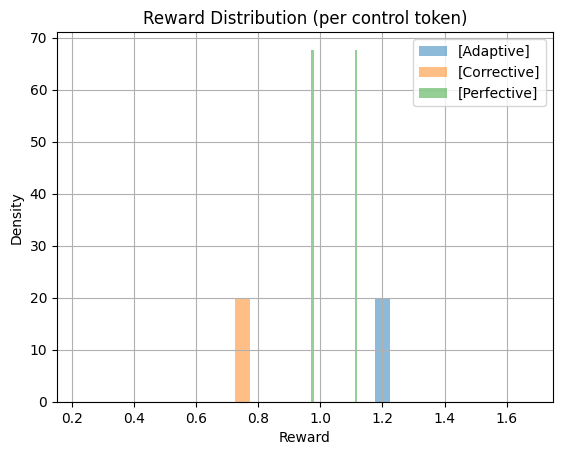

In [33]:
for ctrl_s in ctrl_str:
    vals = [
        r.item()
        for r, t in zip(rewards, task_list)
        if t == ctrl_s
    ]
    if len(vals) > 0:
        plt.hist(
            vals,
            bins=20,
            density=True,
            alpha=0.5,
            label=ctrl_s,
        )

plt.legend(loc="best")
plt.title("Reward Distribution (per control token)")
plt.xlabel("Reward")
plt.ylabel("Density")
plt.grid(True)
plt.show()

## Save model
Finally, we save the model to disk for later usage.

In [34]:
policy.save_pretrained("codet5-msgs-ctrl")
tokenizer.save_pretrained("codet5-msgs-ctrl")

('codet5-msgs-ctrl/tokenizer_config.json',
 'codet5-msgs-ctrl/special_tokens_map.json',
 'codet5-msgs-ctrl/vocab.json',
 'codet5-msgs-ctrl/merges.txt',
 'codet5-msgs-ctrl/added_tokens.json',
 'codet5-msgs-ctrl/tokenizer.json')

In [35]:
#发送多种类型的邮件
from email.mime.multipart import MIMEMultipart
import smtplib

from email.mime.text import MIMEText
msg_from = '915803745@qq.com'  # 发送方邮箱
passwd = 'vcuosuurrgkfbdai'   #就是上面的授权码
 
# to= ['g.zhang@gotion.com', 'j.tong@gotion.com'] #接受方邮箱
to= ['j.tong@gotion.com'] #接受方邮箱
#设置邮件内容
#MIMEMultipart类可以放任何内容
msg = MIMEMultipart()
conntent=f"{'成功'}"
#把内容加进去
msg.attach(MIMEText(conntent,'plain','utf-8'))
 
#设置邮件主题
msg['Subject']="PPO学习模型训练完毕"
 
#发送方信息
msg['From']=msg_from
 
#开始发送
 
#通过SSL方式发送，服务器地址和端口
s = smtplib.SMTP_SSL("smtp.qq.com", 465)
# 登录邮箱
s.login(msg_from, passwd)
#开始发送
s.sendmail(msg_from,to,msg.as_string())
print("强化学习模型训练完毕")

强化学习模型训练完毕
